# mBART50 for Low-Resource Language Translation: ENG -> TGL

- Datasets
  - CulturaX
  - Flores200
  - GlobalVoice2018
  - TED2020
  - QED

# Setup and Dependencies

## Mount MyDrive

In [1]:
from google.colab import drive
drive.mount('/home')

Mounted at /home


##Install Libraries

In [2]:
!pip install datasets
!pip install transformers
!pip install accelerate -U
!pip install sentencepiece
!pip install /home/MyDrive/Colab_Notebooks/BLEU_repo/bleurt

## TPU Docs: https://cloud.google.com/tpu/docs/intro-to-tpu
## Using TPU: https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb#scrollTo=ls3j-EWI2D2v
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00
Processing /home/MyDrive/Colab_Notebooks/BLEU_repo/bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=5deb0df933343b703358ca92968303321abc911da1563820521253b8015ba9c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ym3qadxa/wheels/62/91/0a/d9ec60c47372c14fd33c916db990c26ca55b74e63557172b20
Successfully built BLEURT


## Import Libraries

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import (get_dataset_config_names, load_dataset,
                      get_dataset_split_names, concatenate_datasets,
                      Dataset, DatasetDict)
from transformers import (MBartForConditionalGeneration, MBart50TokenizerFast,
                          Seq2SeqTrainingArguments, Seq2SeqTrainer,
                          DataCollatorForSeq2Seq, EarlyStoppingCallback,
                          TrainerCallback, AdamW,
                          get_linear_schedule_with_warmup,
                          get_constant_schedule_with_warmup,
                          get_cosine_with_hard_restarts_schedule_with_warmup)
from sklearn.model_selection import train_test_split
import sentencepiece

import nltk
import nltk.translate.bleu_score as bleu
from bleurt import score as bleurt

from google.colab import runtime, auth
from google.auth import default
import gspread
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import sys
import time
import timeit
import datetime
import json
import re
import random
import gc
from tqdm import tqdm as std_tqdm, trange
from functools import partial
import xml.etree.ElementTree as ET

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
tqdm = partial(std_tqdm, colour='#0000FF')
%load_ext tensorboard
%config InlineBackend.figure_format = 'retina'

# TMX Parsing Function

- OPUS files are in tmx format.

In [ ]:
def parse_tmx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    translation_dict = {'source_text': [], 'target_text': []}

    ns = {'xml': 'http://www.w3.org/XML/1998/namespace'}

    for tu in tqdm(root.findall('.//tu')):
        source_text = tu.find('.//tuv[@xml:lang="en"]/seg', namespaces=ns).text
        target_text = tu.find('.//tuv[@xml:lang="fil"]/seg', namespaces=ns).text

        translation_dict['source_text'].append(source_text)
        translation_dict['target_text'].append(target_text)

    print('\n')
    return translation_dict

# Downloading Datasets

## CulturaX

### Read CulturaX token from my Drive

In [ ]:
with open("/home/MyDrive/Colab_Notebooks/CulturaX_token.txt", "r") as file:
    TOKEN=file.readline()

### Import CulturaX dataset

In [ ]:
# SOURCE: https://huggingface.co/datasets/uonlp/CulturaX
# SOURCE: https://colab.research.google.com/github/huggingface/datasets/blob/main/notebooks/Overview.ipynb#scrollTo=xxLcdj2yvSU3
# SOURCE: https://huggingface.co/docs/datasets/main/en/load_hub

ds_tl = load_dataset("uonlp/CulturaX",
                     language="tl",
                     token=TOKEN)


Generating train split: 0 examples [00:00, ? examples/s]

### Save raw CulturaX dataset to mydrive

In [ ]:
# Save monolingual tgl dataset to .txt file in mydrive
with open(f'../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_tgl_raw.txt', 'w') as file:
    for string in ds_tl["train"]["text"]:
        file.write(string + '\n')

### Load raw CulturaX dataset from mydrive

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_tgl_raw.txt', 'r') as file:
    culturax_tgl_raw = file.read().splitlines()

### Clean CulturaX dataset

In [ ]:
def filter_and_clean(input_list, truncate_length=100,
                     delimiters=r'\n|[^\x00-\x7F]+|\s\W\s|(?<=\w[.?!-])\s|\s*\.{2,}\s*|(https)|(www.)'):
    """
    Splits text on delimiters and filters the fragments that are
    identified as sentences of length >= truncate_length.

    Inputs:
        - input_list: <list of strings>
        - truncate_length: <int>
        - delimiters: <regex>

    Returns: cleaned list
    """
    print(f'Original list length: {len(input_list)}')

    # Use the patterns to split the strings in list
    list_split_strings = [re.split(delimiters, string) for string in input_list]

    # collapse nested lists
    list_strings = [substring for split_strings in list_split_strings for substring in split_strings if substring != None and len(substring)>truncate_length]

    # filter for strings starting with a capital letter and ending with punctuation
    filtered_list = [re.sub(r'(?<=.)\s[\-](?=\w)', ': ', re.sub(r'\s\.{1,3}','.',string)) for string in list_strings if re.match(r'^[A-Z].*[.?!]$', string)]

    print(f'Clean list length: {len(filtered_list)}\n')
    return filtered_list


In [ ]:
culturax_tgl_clean = split_and_clean(culturax_tgl_raw)

Original list length: 4516102
Clean list length: 2776135



### Save clean CulturaX dataset

In [ ]:
# Save monolingual tgl dataset to .txt file in mydrive
with open(f'../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_tgl_clean.txt', 'w') as file:
    for string in culturax_tgl_clean:
        file.write(string + '\n')

### Load clean CulturaX dataset

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_tgl_clean.txt', 'r') as file:
    culturax_tgl_clean = file.read().splitlines()

In [ ]:
# check loaded data
culturax_tgl_clean[:5]

['Nagbibigay kami ng lahat ng mga uri ng makinarya na pandurog ng bato, tulad ng vibrating feeder, panga pandurog, epekto pandurog, kono pandurog, VSI.',
 'Pangalawa, isang bato ang naibato mula sa tuktok ng Impiyerno at ito ay aabutin ng matagal na panahon upang marating ang ilalim.',
 'Isa sa mga kasamahan ng Propeta (sumakanya nawa ang kapayapaan), ay naglarawan kung paano sila nakaupo kasama ang Propeta at kanilang narinig ang isang bagay na nahuhulog.',
 'Ginagamit ito sa industriya ng konstruksyon, pagmamanupaktura, kemikal at agrikultura sa buong mundo.',
 'Maliban kay Bato ay negatibo ang iba pang senador matapos sumalang sa anti-gen test, Biyernes ng gabi.']

## FloRes200

FLORES-200 consists of translations from 842 distinct web articles, totaling 3001 sentences. These sentences are divided into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 21 words long. There are 41617 different language codes available.

The configurations for this dataset let you download:
1. single languages
2. all languages
3. specific languages pairs (ideal for training)

The `flores_eng_tgl` variable contain English-Tagalog sentense pairs.

Source: https://huggingface.co/datasets/facebook/flores

Source: https://github.com/facebookresearch/flores/blob/main/flores200/README.md

```
# to inspect all the languages available in Flores200
languages = get_dataset_config_names('facebook/flores')
```


### Download data


In [ ]:
# load the Flores200 English-Tagalog sentence pairs
flores200_raw_data = load_dataset('facebook/flores', 'eng_Latn-tgl_Latn')

Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

### Inspect the dataset

Data Fields

- id: Row number for the data entry, starting at 1.
- sentence: The full sentence in the specific language (may have _lang for pairings)
- URL: The URL for the English article from which the sentence was extracted.
- domain: The domain of the sentence.
- topic: The topic of the sentence.
- has_image: Whether the original article contains an image.
- has_hyperlink: Whether the sentence contains a hyperlink.

In [ ]:
flores200_raw_data

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_eng_Latn', 'sentence_tgl_Latn'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence_eng_Latn', 'sentence_tgl_Latn'],
        num_rows: 1012
    })
})

In [ ]:
# combine dev/devtest splits
flores200_eng_tgl = {
    'source_text': flores200_raw_data['dev']['sentence_eng_Latn'] + flores200_raw_data['devtest']['sentence_eng_Latn'],
    'target_text': flores200_raw_data['dev']['sentence_tgl_Latn'] + flores200_raw_data['devtest']['sentence_tgl_Latn']
}

In [ ]:
# call the first english-tagalog pair
[flores200_eng_tgl['source_text'][0], flores200_eng_tgl['target_text'][0]]

['On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.',
 'Noong Lunes, inanunsiyo ng mga siyentipiko mula sa Stanford University School of Medicine ang imbensyon ng panibagong kagamitan sa pag-diagnose na makakauri sa mga cell ayon sa uri: isang maliit na chip na maaaring maprint na maaaring magawa gamit ang standard inkjet na mga printer at posibleng nasa isang U.S. sentimo kada isa.']

### Save/Load raw data

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/FloRes200/flores200_eng_tgl.json', 'w') as json_file:
    json.dump(flores200_eng_tgl, json_file)

In [4]:
# Load raw data into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/FloRes200/flores200_eng_tgl.json', 'r') as json_file:
    flores200_eng_tgl = json.load(json_file)

flores200_eng_tgl.keys()

dict_keys(['source_text', 'target_text'])

In [5]:
len(flores200_eng_tgl['source_text'])

2009

### Load Flores Splits

In [6]:
# Load splits into dictionaries
flores_splits = {
                'train_eng_inputs': None,
                'val_eng_inputs':   None,
                'test_eng_inputs':  None,
                'train_tgl_labels': None,
                'val_tgl_labels':   None,
                'test_tgl_labels':  None
}

for split in flores_splits:
    with open(f'../home/MyDrive/Colab_Notebooks/FloRes200/{split}.txt', 'r') as file:
        flores_splits[split] = file.read().splitlines()

## GlobalVoices2018

Source: https://opus.nlpl.eu/GlobalVoices.php

### Extract/Inspect data

In [ ]:
# Extract raw data from TMX file
gv2018_file_path = '/home/MyDrive/Colab_Notebooks/GlobalVoices2018/GlobalVoices2018_en-fil.tmx'
gv2018_en_fil = parse_tmx(gv2018_file_path)

print(f"Raw data length: {len(gv2018_en_fil['target_text'])}")

100%|██████████| 2478/2478 [00:00<00:00, 103818.58it/s]



Raw data length: 2478


In [ ]:
# inspect raw data
gv2018_en_fil['source_text'][:3], gv2018_en_fil['target_text'][:3]

(['USA: One Step Closer to Lifting HIV Travel Ban · Global Voices ',
  'Last week the U.S. government initiated the final steps required to lift long-standing travel and immigration restrictions imposed on HIV-positive foreigners. ',
  "Under the current ban HIV-positive foreigners, whether they're tourists or business travelers, can't enter the U.S., though in exceptional cases a waiver can be granted. "],
 ['Estados Unidos: Nalalapit Na sa Isang Hakbang Para Alisin ang Kaukulang Paglalakbay Kung May HIV ',
  'Noong huling linggo, ang gobyerno ng Estados Unidos ay nagpasimula ng hakbang para alisin ang pagpapalakbay at paghihigpit ng imigrasyon na pinataw sa mga dayuhang may HIV. ',
  'Sa kasalukuyang pagbawal ng mga dayuhan na may HIV, kahit sila pa ay mga turista o mga mangangalakal, hindi sila makapasok sa Estados Unidos, bagaman maliban na lamang sa mga kaso na ipinagkaloob ng paubaya. '])

In [ ]:
# remove non-standard char from 1st source_text sentence
gv2018_en_fil['source_text'][0] = 'USA: One Step Closer to Lifting HIV Travel Ban.'

In [ ]:
# check for non-strings in dataset
for i, x in enumerate(gv2018_en_fil['source_text']):
  if type(x) != str:
    print(f'element {i} is not a string, it is a {type(x)}')

for i, x in enumerate(gv2018_en_fil['target_text']):
  if type(x) != str:
    print(f'element {i} is not a string, it is a {type(x)}')

element 98 is not a string, it is a <class 'NoneType'>
element 98 is not a string, it is a <class 'NoneType'>


In [ ]:
# cleanup the lists
gv2018_en_fil['source_text'].remove(None)
gv2018_en_fil['target_text'].remove(None)

### Save/Load raw data

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/GlobalVoices2018/gv2018_raw_data.json', 'w') as json_file:
    json.dump(gv2018_en_fil, json_file)

In [ ]:
# Load splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/GlobalVoices2018/gv2018_raw_data.json', 'r') as json_file:
    gv2018_en_fil = json.load(json_file)

gv2018_en_fil.keys()

dict_keys(['source_text', 'target_text'])

## TED2020

Source: https://opus.nlpl.eu/TED2020.php

### Extract/Inspect data

In [ ]:
# Extract raw data from TMX file
ted2020_file_path = '/home/MyDrive/Colab_Notebooks/TED2020/TED2020_en-fil.tmx'
ted2020_en_fil = parse_tmx(ted2020_file_path)

print(f"Raw data length: {len(ted2020_en_fil['source_text'])}")

Raw data length: 3333


In [ ]:
# inspect raw data
ted2020_en_fil['source_text'][:3]

["Hello. My name is Birke Baehr, and I'm 11 years old. ",
 "I came here today to talk about what's wrong with our food system. ",
 "First of all, I would like to say that I'm really amazed at how easily kids are led to believe all the marketing and advertising on TV, at public schools and pretty much everywhere else you look. "]

In [ ]:
# check for non-strings in dataset
for i, x in enumerate(ted2020_en_fil['source_text']):
  if type(x) != str:
    print(f'element {i} is not a string, it is a {type(x)}')

for i, x in enumerate(ted2020_en_fil['target_text']):
  if type(x) != str:
    print(f'element {i} is not a string, it is a {type(x)}')

element 1027 is not a string, it is a <class 'NoneType'>
element 1027 is not a string, it is a <class 'NoneType'>


In [ ]:
# cleanup the lists
ted2020_en_fil['source_text'].remove(None)
ted2020_en_fil['target_text'].remove(None)

### Save/Load raw data

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/TED2020/TED2020_raw_data.json', 'w') as json_file:
    json.dump(ted2020_en_fil, json_file)

In [ ]:
# Load splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/TED2020/TED2020_raw_data.json', 'r') as json_file:
    ted2020_en_fil = json.load(json_file)

ted2020_en_fil.keys()

dict_keys(['source_text', 'target_text'])

## QED

Source: https://opus.nlpl.eu/QED.php

### Extract/Inspect data

In [ ]:
# Extract raw data from TMX file
qed_file_path = '/home/MyDrive/Colab_Notebooks/QED/QED_en-fil.tmx'
qed_en_fil = parse_tmx(qed_file_path)

print(f"Raw data length: {len(qed_en_fil['source_text'])}")

Raw data length: 39464


In [ ]:
# inspect raw data
qed_en_fil['source_text'][:3]

['That meal was a religious experience.',
 "Well, they say... the way to a man's heart is...",
 "Well after a dinner like that, you're going to get a little more than my heart."]

In [ ]:
# check for non-strings in dataset
for i, x in enumerate(qed_en_fil['source_text']):
  if type(x) != str:
    print(f'element {i} is not a string, it is a {type(x)}')

for i, x in enumerate(qed_en_fil['target_text']):
  if type(x) != str:
    print(f'element {i} is not a string, it is a {type(x)}')

### Save/Load raw data

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/QED/QED_raw_data.json', 'w') as json_file:
    json.dump(qed_en_fil, json_file)

In [ ]:
# Load splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/QED/QED_raw_data.json', 'r') as json_file:
    qed_en_fil = json.load(json_file)

qed_en_fil.keys()

dict_keys(['source_text', 'target_text'])

# Train/Test Splits Function

## Custom Function

In [ ]:
def custom_train_test_split(inputs=[None], labels=[None], train_pct=0.9, val_pct=0.1, test_cnt=1000):
    """
    This function create custom splits. First, the test_cnt is
    subtracted from dataset. The remaining data is used to
    create the training and validation splits according to
    the train_pct and val_pct.

    Args:
        - inputs: list of source sentences
        - lables: list of target sentences
        - train_pct: % size of training split
        - val_pct: % size of validation split
        - test_cnt: # count of test split
    Out:
        - Dictionary of train/val/test splits
    """
    random.seed(1234)

    all_data = []
    for i in range(len(inputs)):
        all_data.append([inputs[i], labels[i]])

    # shuffle inputs/labels in-place
    for i in tqdm(range(100)):
        random.shuffle(all_data)

    for i in range(len(all_data)):
        inputs[i], labels[i] = all_data[i][0], all_data[i][1]

    # Create test splits
    temp_eng_inputs, test_eng_inputs, temp_tgl_labels, test_tgl_labels = train_test_split(inputs, labels, test_size=1000, random_state=1234)

    # Create training and validaion splits
    train_eng_inputs, val_eng_inputs, train_tgl_labels, val_tgl_labels = train_test_split(temp_eng_inputs, temp_tgl_labels, train_size=0.9, random_state=1234)

    # dictionary of splits
    data_splits = {
                    'train_eng_inputs': train_eng_inputs,
                    'val_eng_inputs':   val_eng_inputs,
                    'test_eng_inputs':  test_eng_inputs,
                    'train_tgl_labels': train_tgl_labels,
                    'val_tgl_labels':   val_tgl_labels,
                    'test_tgl_labels':  test_tgl_labels
    }
    print('\n')
    return data_splits



# Final Corpora Dataset

## Collate all datasets

In [ ]:
all_eng_inputs = flores200_eng_tgl['flores_eng_inputs'] + gv2018_en_fil['source_text'] + \
                 ted2020_en_fil['source_text'] + qed_en_fil['source_text']
all_tgl_labels = flores200_eng_tgl['flores_tgl_labels'] + gv2018_en_fil['target_text'] + \
                 ted2020_en_fil['target_text'] + qed_en_fil['target_text']

In [ ]:
print(f'Total Dataset Size: {len(all_tgl_labels)}')

Total Dataset Size: 47282


## Create corpora splits

In [ ]:
corpora_splits = custom_train_test_split(inputs=all_eng_inputs, labels=all_tgl_labels,
                                         train_pct=0.9, val_pct=0.1, test_cnt=1000)

100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


In [ ]:
# split lengths
len(corpora_splits['train_eng_inputs']),\
len(corpora_splits['val_eng_inputs']),\
len(corpora_splits['test_eng_inputs'])

(41653, 4629, 1000)

## Save/Load Corpora Dict

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/Collated_Corpora/corpora_splits.json', 'w') as json_file:
    json.dump(corpora_splits, json_file)

In [ ]:
# Load splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/Collated_Corpora/corpora_splits.json', 'r') as json_file:
    corpora_splits = json.load(json_file)

corpora_splits.keys()

dict_keys(['train_eng_inputs', 'val_eng_inputs', 'test_eng_inputs', 'train_tgl_labels', 'val_tgl_labels', 'test_tgl_labels'])

# mBART50 Model Setup

mBART-50 is a multilingual Sequence-to-Sequence model. It was introduced to show that multilingual translation models can be created through multilingual fine-tuning. Instead of fine-tuning on one direction, a pre-trained model is fine-tuned on many directions simultaneously.

Languages trained in mBART:

Arabic (ar_AR), Czech (cs_CZ), German (de_DE), English (en_XX), Spanish (es_XX), Estonian (et_EE), Finnish (fi_FI), French (fr_XX), Gujarati (gu_IN), Hindi (hi_IN), Italian (it_IT), Japanese (ja_XX), Kazakh (kk_KZ), Korean (ko_KR), Lithuanian (lt_LT), Latvian (lv_LV), Burmese (my_MM), Nepali (ne_NP), Dutch (nl_XX), Romanian (ro_RO), Russian (ru_RU), Sinhala (si_LK), Turkish (tr_TR), Vietnamese (vi_VN), Chinese (zh_CN), Afrikaans (af_ZA), Azerbaijani (az_AZ), Bengali (bn_IN), Persian (fa_IR), Hebrew (he_IL), Croatian (hr_HR), Indonesian (id_ID), Georgian (ka_GE), Khmer (km_KH), Macedonian (mk_MK), Malayalam (ml_IN), Mongolian (mn_MN), Marathi (mr_IN), Polish (pl_PL), Pashto (ps_AF), Portuguese (pt_XX), Swedish (sv_SE), Swahili (sw_KE), Tamil (ta_IN), Telugu (te_IN), Thai (th_TH), Tagalog (tl_XX), Ukrainian (uk_UA), Urdu (ur_PK), Xhosa (xh_ZA), Galician (gl_ES), Slovene (sl_SI)

### Assign device (multi)

In [ ]:
# check if TPU/GPU/CPU available to set device
try:
    xm.is_available()
    device = xm.xla_device()
except:
    try:
        if torch.cuda.is_available() == False:
            raise Exception()
        else:
            device = torch.device('cuda')
    except:
        device = torch.device('cpu')

device

device(type='cuda')

## Download model and tokenizer

In [ ]:
# download model and tokenizer from huggingface
model0 = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt").to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

## Save model and tokenizer

In [ ]:
# save model and tokenizer to mydrive cloud
model_path = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
model0.save_pretrained(model_path)
tokenizer0.save_pretrained(model_path)

('../home/MyDrive/Colab_Notebooks/mBART50-Stock/tokenizer_config.json',
 '../home/MyDrive/Colab_Notebooks/mBART50-Stock/special_tokens_map.json',
 '../home/MyDrive/Colab_Notebooks/mBART50-Stock/sentencepiece.bpe.model',
 '../home/MyDrive/Colab_Notebooks/mBART50-Stock/added_tokens.json',
 '../home/MyDrive/Colab_Notebooks/mBART50-Stock/tokenizer.json')

## Load model and tokenizer from mydrive

In [9]:
# load model and tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
model0 = MBartForConditionalGeneration.from_pretrained(path_stock).to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# https://docs.nvidia.com/deeplearning/performance/dl-performance-fully-connected/index.html#batch-size

## in development
def adjust_vocab_embed(model=None, tokenizer=None):
    """
    Following nvidia's suggestion for training optimization by aligning
    the tokenizer's vocabulary size, the model's embedding size, and even
    the length of tokenized sentences to be a multiple of 32.
    """
    current_vocab_size = len(tokenizer)
    padding_needed = 32 - (current_vocab_size % 32)
    padding_tokens = {}
    for i in range(1,padding_needed+1):
        padding_tokens[f'pad_token_{i}'] = f'<pad{i}>'
    tokenizer.additional_special_tokens = [k for k in padding_tokens.keys()]
    tokenizer.add_special_tokens(special_tokens_dict={'pad_token_1':['<pad1>']},
                                 replace_additional_special_tokens=False)
    new_vocab_size = len(tokenizer)

    print(f" Original Vocabulary Size: {current_vocab_size}\n",
          f"New Vocabulary Size (multiple of 32): {new_vocab_size}\n",
          f"Original Token Embedding Size: {model.config.vocab_size}\n",
          f"New Embedding Size: {model.resize_token_embeddings(new_vocab_size)}\n")

    return

### Example: translation

In [ ]:
# english to tagalog
phrase = flores_splits['test_eng_inputs'][10]

tokenizer0.src_lang = "en_XX"

encoded = tokenizer0(phrase, return_tensors="pt")
print(encoded)
generated_tokens = model0.generate(**encoded,
                                  forced_bos_token_id=tokenizer0.lang_code_to_id["tl_XX"])
print(generated_tokens)
tokenizer0.batch_decode(generated_tokens, skip_special_tokens=True)

{'input_ids': tensor([[250004,  38396,     25,      7,   3398,  85018,    674,   2843,  65042,
            297,     70,  27759,     25,      7, 166794,   7228,     23,  11994,
            111,    903,   6602,     47,   9458,   4173,   2258,   1651,   4188,
              5,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}
tensor([[     2, 250047, 250054, 250017, 226365,      6, 194532,  13499,  22998,
         159584,      6,  28982,   8100,      6, 140432,   2196,  10714,      6,
          17044,  12696,  52228,  98532,      6, 137636,  32510, 118182,  57580,
          98532,   8100,  20326,  37864,      6,   7014,      6,   9441,   1160,
          37625,  16054,  39208,  14605, 160827, 100226,      6,  17834,  24411,
          58476,      6,  17834,      6,  17834,   6134,      6,  64904,      6,
          64904,      6,   7548,      6,   7548,      6,   7548,      6,  24540,
              6,   754

['<pad1> ယနေ့ ကြော်ငြာ ချက် က ထပ်မံ ၍ ဒီ နှစ် ၏ မတ် လ တွင် အစိုးရ ၏ ကတိပြု ထား သော အပို သယ်ယူယာဉ် များ ရန်ပုံငွေ ရန် ရန် ကို တိုး တိုး ခဲ့ ခဲ့ ခဲ့ လည်း ခဲ့ ခဲ့ ခဲ့ ခဲ့ ခဲ့.']

In [ ]:
# check against ground truth
flores_splits['test_tgl_labels'][10]

'Ang anunsiyo ngayong araw ay nagpalawig din sa pangakong ginawa ng gobyerno noong Marso ng taong ito na popondohan ang mga karagdagang bagon.'

### Example: training

In [ ]:
def mBART50_training(model_, tokenizer_, splits_dict, foldername, epochs=2,
                     batch_size = 48, src_lang='en_XX', tgt_lang='tl_XX'):
    """
    This function trains mBART50.

    Inputs:
        splits_dict: dataset dictionary must contain these splits
        - train_eng_inputs
        - train_tgl_labels
        - val_eng_inputs
        - val_tgl_labels
        foldername: the name of the folder to save the model and logs
        batch_size: the batch size
        epochs: the number of epochs to train
        scr_lang = the source language code
        trg_lang = the target language code

    Output: The trainer for the model.
    """
    start_time = time.time()

    dir = "../home/MyDrive/Colab_Notebooks"
    path = os.path.join(dir, foldername)
    os.makedirs(path, exist_ok=True)
    global log_dir
    log_dir = os.path.join(path, datetime.datetime.now().strftime("%y%m%d-%H%M%S"))

    tokenizer_.src_lang = src_lang
    tokenizer_.tgt_lang = tgt_lang

    lang_map = {"en_XX": ('eng_inputs', 'tgl_labels'), "tl_XX": ('tgl_labels', 'eng_inputs')}
    src, tgt = lang_map.get(src_lang)

    tokenized_train = tokenizer_(text = splits_dict[f'train_{src}'],
                                    text_target = splits_dict[f'train_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=256)

    tokenized_val = tokenizer_(text = splits_dict[f'val_{src}'],
                                    text_target = splits_dict[f'val_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=256)

    training_dataset = Dataset.from_dict(tokenized_train.to(device))
    validation_dataset = Dataset.from_dict(tokenized_val.to(device))

    sample_size = len(splits_dict[f'train_{src}'])
    total_steps = epochs*sample_size/batch_size if sample_size%batch_size == 0 else (epochs*sample_size//batch_size)+1
    warmup_steps = 0.85 * total_steps/epochs

    training_args = Seq2SeqTrainingArguments(

        # directories
        output_dir=path,
        logging_dir=log_dir,

        # logging settings
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=1,
        logging_strategy="steps",
        logging_steps=1,
        logging_first_step=True,

        # saving settings
        save_strategy="no",
        save_steps=4,
        save_total_limit=5,
        load_best_model_at_end=False,
        metric_for_best_model="eval_loss",
        greater_is_better=False,

        # optimizer settings
        num_train_epochs=epochs,
        lr_scheduler_type='constant_with_warmup',
        learning_rate=2e-4,
        weight_decay=1e-2,
        warmup_steps=warmup_steps,

        # trainer settings
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        predict_with_generate=False,
        tf32=False,
        fp16=False,
        max_steps=-1
    )

    class EarlyStopCallback(TrainerCallback):
        def __init__(self, patience=5, tolerance=0.1):
            # super(EarlyStopCallback, self).__init__()
            self.patience = patience
            self.tolerance = tolerance
            self.counter = 0
            self.train_loss = 0.0
            self.eval_loss = 0.0

        def on_step_end(self, args, state, control, optimizer, **kwargs):
            if len(state.log_history) > 1:
                self.train_loss = state.log_history[-2]["loss"]
                self.eval_loss = state.log_history[-1]["eval_loss"]
                diff = self.eval_loss - self.train_loss

                if diff > self.tolerance:
                    self.counter += 1
                    if self.counter >= self.patience:
                        print('Training stopped early due to lack of improvement in eval_loss.')
                        print(f"Learning Rate at stopping: {optimizer.param_groups[0]['lr']}")
                        control.should_training_stop = True
                else:
                    self.counter = 0

    # optimizer_ = torch.optim.AdamW(model_.parameters(), lr=2e-4, weight_decay=1e-2)

    # scheduler_ = get_linear_schedule_with_warmup(
    #                                         optimizer=optimizer_,
    #                                         num_warmup_steps=warmup_steps,
    #                                         num_training_steps=total_steps)

    # data_collator_ = DataCollatorForSeq2Seq(tokenizer=tokenizer_, model=model_,
    #                                         padding=True, pad_to_multiple_of=32,
    #                                         label_pad_token_id=model0.config.pad_token_id)

    trainer = Seq2SeqTrainer(
        model=model_,
        tokenizer=tokenizer_,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=validation_dataset,
        # data_collator=data_collator_,
        # optimizers=(optimizer_, scheduler_),
        callbacks=[EarlyStopCallback]
    )

    # trainer.place_model_on_device = True
    trainer.train()

    # training_dataset.to('cpu')
    # validation_dataset.to('cpu')
    # model_.to('cpu')
    # del training_dataset, validation_dataset
    # gc.collect()
    # with torch.no_grad():
    #     torch.cuda.empty_cache

    end_time = time.time()
    print(f'Total Training Time: {round((end_time - start_time)/60,3)} mins')
    return trainer

In [ ]:
model0.config.max_position_embeddings

1024

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
try:
    model0, tokenizer0
except:
    print('fail')

In [ ]:
device

device(type='cpu')

In [ ]:
tokenizer0.tgt_lang = 'tl_XX'
tokenized_train = tokenizer0(text = corpora_splits[f'train_eng_inputs'],
                                text_target = corpora_splits[f'train_tgl_labels'],
                                return_tensors="pt", padding=True, pad_to_multiple_of=32,
                                truncation=True, max_length=512)#model0.config.max_position_embeddings)
# training_dataset = Dataset.from_dict(tokenized_train.to(device))

In [ ]:
tokenized_train.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
tokenized_train['input_ids'].shape

torch.Size([41653, 1024])

In [ ]:
tokenized_train['attention_mask'].shape

torch.Size([41653, 1024])

In [ ]:
tokenized_train['labels'].shape

torch.Size([41653, 896])

In [ ]:
tokenized_dataset = {
    'source': [tokenizer0(seq)["input_ids"] for seq in corpora_splits['train_eng_inputs']],
    'labels': [tokenizer0(seq)["input_ids"] for seq in corpora_splits['train_tgl_labels']],
}


In [ ]:
s_len = 0
index = 0
cnt = 0
for i, e in enumerate(tokenized_dataset['labels']):
  if len(e) < 512 and len(e) > 256:
    s_len = len(e)
    index = i
    cnt += 1
    print(index, s_len)
cnt, len(tokenized_dataset['labels']), cnt/len(tokenized_dataset['labels'])

608 447
1696 382
1922 410
2649 432
3379 266
3469 274
4958 293
5118 304
6657 285
7440 260
7782 309
10384 329
10957 450
11385 326
11487 386
11610 313
12717 503
13342 361
14011 260
15428 278
15967 484
16087 505
17487 313
20081 338
20522 352
21268 343
21704 378
22410 338
22450 394
22609 295
25364 334
27109 503
28107 354
29427 436
29446 373
30048 369
30199 336
31089 267
31520 381
31772 511
32560 273
32745 262
35199 334
35836 381
37159 502
37382 346
38994 447
39029 374
39121 260
39559 355
40666 277


(51, 41653, 0.001224401603726022)

In [ ]:
max_len = 0
index = 0
for i, e in enumerate(tokenized_dataset['source']):
  if len(e) > max_len:
    max_len = len(e)
    index = i
    print(index, max_len)

0 9
1 17
2 22
17 26
66 35
120 36
181 44
862 68
1199 72
1403 109
1832 110
2705 114
2731 127
2762 136
2773 161
2779 197
2888 472
3334 954
3338 1022
3345 1097
3362 2197


In [ ]:
qed_en_fil[f'source_text'][3336]

"like their security at it over my work and where antiseptic event there is a favor you could do for me return and return it may be persuaded to lend you the money and or doctor lovell programs and i won't do it on the other hand like andrew favor or forgetting to mention a few things you would want to hear him you'll you'll try that sooner or later when i got to where i want to mr richards come up with you but your best bet is that a couple took china october november what u door to quiet welcome at western coming here doubts but i would require you can take care of myself get tied up here uh... each witness male is letter grades turned places on the steps and harry i'll go to a couple months they're going to probably what got role would go to deliver to real puffy and it's a red herring i believe i told you believe i am not through with mr ritter i think that the caller we get to they've all week"

In [ ]:
qed_en_fil[f'target_text'][2888].count(';')


5

In [ ]:
any(c in '.?!' for c in qed_en_fil[f'source_text'][2888][:-2])


False

In [ ]:
sentences=[x.strip() for x in re.split('[.?!]', corpora_splits[f'train_eng_inputs'][16087]) if x]
len(sentences)

8

In [ ]:
mdl = mBART50_training(model0, tokenizer0, corpora_splits, foldername='mBART50-Corpora',
                       epochs=1, batch_size=32, src_lang='en_XX', tgt_lang='tl_XX')

In [ ]:
del mBART50_training
gc.collect()

8

# Custom Tokenizer

## Custom CulturaX Tokenizer

### Clean data for training

In [ ]:
def tokenizer_data_prep(input_list, truncate_length=50, delimiters=r'\n'):
    """
    Splits text on '\n' and filters the fragments that are
    sentences of length >= truncate_length and contain only
    latin-based characters.

    Inputs:
        - input_list: <list of strings>
        - truncate_length: <int>
        - delimiters: <regex>

    Returns: cleaned data
    """
    print(f'Original list length: {len(input_list)}')

    # Use the patterns to split the strings in list
    list_split_strings = [re.split(delimiters, string) for string in input_list]

    # collapse nested lists
    list_strings = [substring for split_strings in list_split_strings for substring in split_strings if substring != None and len(substring)>truncate_length]

    pattern = re.compile(r'[^\x00-\x7F]+|(https)|(www.)')

    # Filter out strings matching the pattern
    filtered_list = [string for string in list_strings if not pattern.search(string)]

    print(f'Clean list length: {len(filtered_list)}\n')
    return filtered_list


In [ ]:
tokenizer_train_data = tokenizer_data_prep(culturax_tgl_raw)

Original list length: 4516102
Clean list length: 2493522



### Save tokenizer training data

In [ ]:
# Save monolingual tgl dataset to .txt file in mydrive
with open(f'../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_tokenizer_train.txt', 'w') as file:
    for string in tokenizer_train_data:
        file.write(string + '\n')

### Make dataset iterator object

In [ ]:
def training_corpus_iterator(training_corpus):
    for i in range(0, len(training_corpus), 1000):
        yield training_corpus[i:i+1000]


my_corpus_iterator = training_corpus_iterator(tokenizer_train_data)

### Train custom tokenizer

In [ ]:
tokenizer_culturax_custom = tokenizer0.train_new_from_iterator(my_corpus_iterator, 32000)

# Translator Function

In [ ]:
def mBART50_translator(model_=None, tokenizer_=None, inputs=None,
                       src_lang='en_XX', tgt_lang='tl_XX'):
    """
    This function pre-processes source sentences then translates them to target language.

    Inputs:
    model_ = the model to be used for translation
    tokenizer_ = the tokenizer to be used for pre-processing
    inputs = the sentence(s) to be translated.
    scr_lang = the source language
    trg_lang = the target language

    Output: The translated sentences.
    """
    start_time = time.time()

    tokenizer_.src_lang = src_lang
    tokenizer_.tgt_lang = tgt_lang

    # tokenize, encode, translate, decode
    translated_decoded = []
    for input in tqdm(inputs):
        encoded = tokenizer_(input, return_tensors="pt").to(device)
        with torch.no_grad():
            translation_tokens = model_.generate(**encoded,
                                      forced_bos_token_id=tokenizer_.lang_code_to_id[tgt_lang])
        translated_decoded.append(tokenizer_.batch_decode(translation_tokens, skip_special_tokens=True))
        encoded.to('cpu')
        del encoded

    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()
    end_time = time.time()
    print(f'Elasped Time: {round((end_time - start_time)/60,3)} mins')
    return translated_decoded


## FloRes200

### Tokenize & Translate: FloRes200

In [ ]:
predicted_tgl_labels = mBART50_translator(flores_splits['test_eng_inputs'])


Elasped Time: 11.474 mins


### Save FloRes200 Translations from mydrive

In [ ]:
# note: the translated ouput from the model is in list(list(str)) format
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Stock/pred_test_tgl_labels.txt', 'w') as file:
    for string in predicted_tgl_labels:
        file.write(string[0] + '\n')

### Load FloRes200 Translations from mydrive

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Stock/pred_test_tgl_labels.txt', 'r') as file:
    flo_test_tgl_labels = file.read().splitlines()

# Scoring Methods Function

In [ ]:
def bleu_bleurt(predicted_labels=None, true_labels=None, batch=64):
    """
    This function calculates the BLEU and BLEURT scores of predicted
    translations against the true labels.

    Formats:
        predicted_labels: list(list(str))
        true_labels: list(str)
    """

    scores_dict = {'bleu_score': None,
                   'bleurt_score': None}

    # flatten predicted_labels
    predicted_labels = list(map(lambda x: x[0], predicted_labels))

    # scoring with bleu
    smoothing = bleu.SmoothingFunction().method7
    scores_bleu = [bleu.sentence_bleu([str(predicted).split()], str(true).split(), smoothing_function=smoothing)
                    for predicted, true in zip(predicted_labels, true_labels)]
    scores_dict['bleu_score'] = np.mean(scores_bleu)

    # loading the bleurt model: checkpoint 20
    try:
        global bleurt_checkpoint, bleurt_scorer
        bleurt_checkpoint, bleurt_scorer
    except:
            bleurt_checkpoint = "/home/MyDrive/Colab_Notebooks/BLEU_repo/BLEURT-20"
            bleurt_scorer = bleurt.LengthBatchingBleurtScorer(bleurt_checkpoint)

    # scoring with bleurt
    scores_bleurt = []
    for i in std_tqdm(range(0,len(predicted_labels),batch), colour='#0000FF'):
        scores_bleurt.extend(bleurt_scorer.score(references=true_labels[i:i+batch],
                                                candidates=predicted_labels[i:i+batch],
                                                batch_size=batch))
    scores_dict['bleurt_score'] = np.mean(scores_bleurt)

    return scores_dict


### Trial: Scoring

In [ ]:
path_translations =\
"/home/MyDrive/Colab_Notebooks/mBART50-Synthetic_100/231206-055014/synthetic_100_tgl_predictions.txt"

with open(path_translations, 'r') as file:
    translations = file.read().splitlines()

prep_translations = [[x] for x in translations]
prep_translations[:3]

[['Noong 1994, ang etnisyong Armenian na Nagorno-Karabakh region ng Aserbanya ay nagsagawa ng larangan sa mga Azeris.'],
 ['Hindi nakikita si Zayat sa kaguluhan.'],
 ['Ang pinakamalaking lider ng bansa, na si Ayatollah Ali Khamenei, ay opisyal na ang dependensiya sa gasolina ay bilang "isang trape" na nagmula sa panahong huling rebolusyon sa Islamo ng Iran noong 1979 at kung saan dapat lipunan ang bansa na lipunan ang kanyang sarili.']]

In [ ]:
# free up memory
# with torch.no_grad():
#     torch.cuda.empty_cache()
# gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=prep_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


{'bleu_score': 0.23184092223013883, 'bleurt_score': 0.3794847612653799}

## BLEU Scoring

In [ ]:
# example
pred = str('she read the book because she was interested in world history').split()
ref_a = str('she read the book because she was interested in world history').split()

bleu.sentence_bleu([ref_a], pred)

### FlorRes200

In [ ]:
# scoring with bleu
actual_tgl_labels = flores_splits['test_tgl_labels']

scores_eng_tgl = [bleu.sentence_bleu([str(predicted[0]).split()], str(actual).split()) for predicted, actual in zip(predicted_tgl_labels, actual_tgl_labels)]
average_BLEU = sum(scores_eng_tgl) / len(scores_eng_tgl)

print(f"Average BLEU Score: {average_BLEU}")

Average BLEU Score: 0.0015195596206798285


## BLEURT Scoring

Ref: https://github.com/google-research/bleurt#readme

Vid: https://www.youtube.com/watch?v=9lWxwfMKAdM

Inputs:

- predictions (list of strs): List of generated sentences to score.
- references (list of strs): List of references to compare to.
- checkpoint (str): BLEURT checkpoint. Will default to BLEURT-tiny if not specified. Other models that can be chosen are: "bleurt-tiny-128", "bleurt-tiny-512", "bleurt-base-128", "bleurt-base-512", "bleurt-large-128", "bleurt-large-512", "BLEURT-20-D3", "BLEURT-20-D6", "BLEURT-20-D12" and "BLEURT-20".

In [ ]:
# loading the bleurt model
checkpoint = "/home/MyDrive/Colab_Notebooks/BLEU_repo/BLEURT-20"
scorer = score.BleurtScorer(checkpoint)


In [ ]:
# calculating bleu score(s)
actual_tgl_labels = flores_splits['test_tgl_labels']
bleurt_scores = scorer.score(references=actual_tgl_labels, candidates=flo_test_tgl_labels)
average_BLEURT = sum(bleurt_scores) / len(bleurt_scores)

print(f'Average BLEURT score: {average_BLEURT}')

Average BLEURT score: 0.18386367080149366


# Training Function

In [ ]:
def mBART50_training(model_, tokenizer_, splits_dict, foldername, epochs=4,
                     batch_size=48, src_lang='en_XX', tgt_lang='tl_XX'):
    """
    This function trains mBART50.

    Inputs:
        splits_dict: dataset dictionary must contain these splits
        - train_eng_inputs
        - train_tgl_labels
        - val_eng_inputs
        - val_tgl_labels
        foldername: the name of the folder to save the model and logs
        batch_size: the batch size
        epochs: the number of epochs to train
        scr_lang = the source language code
        trg_lang = the target language code

    Returns: The trainer for the model.
    """
    start_time = time.time()

    dir = "../home/MyDrive/Colab_Notebooks"
    path = os.path.join(dir, foldername)
    os.makedirs(path, exist_ok=True)
    global log_dir
    log_dir = os.path.join(path, datetime.datetime.now().strftime("%y%m%d-%H%M%S"))

    tokenizer_.src_lang = src_lang
    tokenizer_.tgt_lang = tgt_lang

    lang_map = {"en_XX": ('eng_inputs', 'tgl_labels'), "tl_XX": ('tgl_labels', 'eng_inputs')}
    src, tgt = lang_map.get(src_lang)

    tokenized_train = tokenizer_(text = splits_dict[f'train_{src}'],
                                    text_target = splits_dict[f'train_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=128)

    tokenized_val = tokenizer_(text = splits_dict[f'val_{src}'],
                                    text_target = splits_dict[f'val_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=128)

    training_dataset = Dataset.from_dict(tokenized_train.to(device))
    validation_dataset = Dataset.from_dict(tokenized_val.to(device))

    sample_size = len(splits_dict[f'train_{src}'])
    total_steps = epochs*sample_size/batch_size if sample_size%batch_size == 0 else (epochs*sample_size//batch_size)+1
    warmup_steps = 0.85 * total_steps/epochs

    training_args = Seq2SeqTrainingArguments(

        # directories
        output_dir=path,
        logging_dir=log_dir,

        # logging settings
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=1,
        logging_strategy="steps",
        logging_steps=1,
        logging_first_step=True,

        # saving settings
        save_strategy="no",
        save_steps=4,
        save_total_limit=5,
        load_best_model_at_end=False,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=False,
        gradient_checkpointing_kwargs=False,

        # optimizer settings
        num_train_epochs=epochs,
        lr_scheduler_type='constant_with_warmup',
        learning_rate=2e-4,
        weight_decay=1e-2,
        warmup_steps=warmup_steps,

        # data loader settings
        sortish_sampler=True,
        group_by_length=True,
        dataloader_pin_memory=True,
        auto_find_batch_size=False,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,

        # trainer settings
        resume_from_checkpoint=None,
        report_to='tensorboard',
        predict_with_generate=False,
        tf32=False,
        fp16=False,
        max_steps=-1
    )

    class EarlyStopCallback(TrainerCallback):
        def __init__(self, patience=5, tolerance=0.1):
            self.patience = patience
            self.tolerance = tolerance
            self.counter = 0
            self.train_loss = 0.0
            self.eval_loss = 0.0

        def on_step_end(self, args, state, control, optimizer, **kwargs):
            if len(state.log_history) > 1:
                self.train_loss = state.log_history[-2]["loss"]
                self.eval_loss = state.log_history[-1]["eval_loss"]
                diff = self.eval_loss - self.train_loss

                if diff > self.tolerance:
                    self.counter += 1
                    if self.counter >= self.patience:
                        print('Training stopped early due to lack of improvement in eval_loss.')
                        print(f"Learning Rate at stopping: {optimizer.param_groups[0]['lr']}")
                        control.should_training_stop = True
                else:
                    self.counter = 0

    data_collator_ = DataCollatorForSeq2Seq(tokenizer=tokenizer_, model=model_,
                                           padding='longest', pad_to_multiple_of=32,
                                           label_pad_token_id = model_.config.pad_token_id)

    optimizer_ = torch.optim.RAdam(model_.parameters(), lr=2e-4, weight_decay=0)

    scheduler_ = get_constant_schedule_with_warmup(optimizer_, num_warmup_steps=warmup_steps)

    trainer = Seq2SeqTrainer(
        model=model_,
        tokenizer=tokenizer_,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=validation_dataset,
        data_collator=data_collator_,
        optimizers=(optimizer_, scheduler_),
        callbacks=[EarlyStopCallback]
    )

    trainer.place_model_on_device = True
    trainer.train()

    tokenized_train.to('cpu')
    tokenized_val.to('cpu')
    del training_dataset, validation_dataset
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    end_time = time.time()
    print(f'Total Training Time: {round((end_time - start_time)/60,3)} mins')

    return trainer

## Development Training Function

**Testing Notes**

- Set max token length to 128
- *maybe*: max batch size to 16
- Replace custom early stopping callback with default class
- Decrease length of samples in CulturaX (and maybe FloRes200)

*To Try First*
- Remove tokenizer from Trainer()
- Remove padding from tokenization of training and validation datasets

*To Try Second*
- Remove tokenizer from Trainer() and use a PyTorch DataLoader() with a DataCollator() passed to it
- Remove padding from tokenization of training and validation datasets

In [ ]:
# testing version
def mBART50_training(model_, tokenizer_, splits_dict, foldername, epochs=4,
                     batch_size=48, src_lang='en_XX', tgt_lang='tl_XX'):
    """
    This function trains mBART50.

    Inputs:
        splits_dict: dataset dictionary must contain these splits
        - train_eng_inputs
        - train_tgl_labels
        - val_eng_inputs
        - val_tgl_labels
        foldername: the name of the folder to save the model and logs
        batch_size: the batch size
        epochs: the number of epochs to train
        scr_lang = the source language code
        trg_lang = the target language code

    Returns: The trainer for the model.
    """
    start_time = time.time()

    dir = "../home/MyDrive/Colab_Notebooks"
    path = os.path.join(dir, foldername)
    os.makedirs(path, exist_ok=True)
    global log_dir
    log_dir = os.path.join(path, datetime.datetime.now().strftime("%y%m%d-%H%M%S"))

    tokenizer_.src_lang = src_lang
    tokenizer_.tgt_lang = tgt_lang

    lang_map = {"en_XX": ('eng_inputs', 'tgl_labels'), "tl_XX": ('tgl_labels', 'eng_inputs')}
    src, tgt = lang_map.get(src_lang)

    tokenized_train = tokenizer_(text = splits_dict[f'train_{src}'],
                                    text_target = splits_dict[f'train_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=128)

    tokenized_val = tokenizer_(text = splits_dict[f'val_{src}'],
                                    text_target = splits_dict[f'val_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=128)

    training_dataset = Dataset.from_dict(tokenized_train.to(device))
    validation_dataset = Dataset.from_dict(tokenized_val.to(device))

    sample_size = len(splits_dict[f'train_{src}'])
    total_steps = epochs*sample_size/batch_size if sample_size%batch_size == 0 else (epochs*sample_size//batch_size)+1
    warmup_steps = 0.85 * total_steps/epochs

    training_args = Seq2SeqTrainingArguments(

        # directories
        output_dir=path,
        logging_dir=log_dir,

        # logging settings
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=1,
        logging_strategy="steps",
        logging_steps=1,
        logging_first_step=True,

        # saving settings
        save_strategy="no",
        save_steps=4,
        save_total_limit=5,
        load_best_model_at_end=False,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=False,
        gradient_checkpointing_kwargs=False,

        # optimizer settings
        num_train_epochs=epochs,
        lr_scheduler_type='constant_with_warmup',
        learning_rate=2e-4,
        weight_decay=1e-2,
        warmup_steps=warmup_steps,

        # data loader settings
        sortish_sampler=True,
        group_by_length=True,
        dataloader_pin_memory=True,
        auto_find_batch_size=False,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,

        # trainer settings
        resume_from_checkpoint=None,
        report_to='tensorboard',
        predict_with_generate=False,
        tf32=False,
        fp16=False,
        max_steps=-1
    )

    class EarlyStopCallback(TrainerCallback):
        def __init__(self, patience=5, tolerance=1e-3):
            self.patience = patience
            self.tolerance = tolerance
            self.counter = 0
            self.prev_eval_loss = float('inf')

        def on_step_end(self, args, state, control, optimizer, **kwargs):
            if len(state.log_history) > 0:
                self.eval_loss = state.log_history[-1]["eval_loss"]
                self.diff = self.prev_eval_loss - self.eval_loss

                if self.diff < self.tolerance:
                    self.counter += 1
                    if self.counter >= self.patience:
                        print('Training stopped early due to lack of improvement in eval_loss.')
                        print(f"Learning Rate at stopping: {optimizer.param_groups[0]['lr']}")
                        control.should_training_stop = True
                else:
                    self.counter = 0

                self.prev_eval_loss = self.eval_loss


    # data_collator_ = DataCollatorForSeq2Seq(tokenizer=tokenizer_, model=model_,
    #                                        padding='longest', pad_to_multiple_of=32,
    #                                        label_pad_token_id = model_.config.pad_token_id)

    # train_dataloader = DataLoader(training_dataset, batch_size=batch_size,
    #                               shuffle=True, collate_fn=data_collator_)

    # eval_dataloader = DataLoader(validation_dataset, batch_size=batch_size,
    #                               shuffle=True, collate_fn=data_collator_)

    optimizer_ = torch.optim.RAdam(model_.parameters(), lr=2e-4, weight_decay=0)

    scheduler_ = get_constant_schedule_with_warmup(optimizer_, num_warmup_steps=warmup_steps)

    trainer = Seq2SeqTrainer(
        model=model_,
        # tokenizer=tokenizer_,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=validation_dataset,
        # data_collator=data_collator_,
        optimizers=(optimizer_, scheduler_),
        callbacks=[EarlyStopCallback]
    )

    trainer.place_model_on_device = True
    trainer.train()

    tokenized_train.to('cpu')
    tokenized_val.to('cpu')
    del training_dataset, validation_dataset
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache
    end_time = time.time()
    print(f'Total Training Time: {round((end_time - start_time)/60,3)} mins')

    return trainer

Miscellaneous `Trainer()` Classes/Functions:



```
   Early_Stopping = EarlyStoppingCallback(early_stopping_patience=4,
                                      early_stopping_threshold=0.02)

    class EarlyStopCallback(TrainerCallback):
        def __init__(self, patience=5, tolerance=0.1):
            self.patience = patience
            self.tolerance = tolerance
            self.counter = 0
            self.train_loss = 0.0
            self.eval_loss = 0.0

        def on_step_end(self, args, state, control, optimizer, **kwargs):
            if len(state.log_history) > 1:
                self.train_loss = state.log_history[-2]["loss"]
                self.eval_loss = state.log_history[-1]["eval_loss"]
                diff = self.eval_loss - self.train_loss

                if diff > self.tolerance:
                    self.counter += 1
                    if self.counter >= self.patience:
                        print('Training stopped early due to lack of improvement in eval_loss.')
                        print(f"Learning Rate at stopping: {optimizer.param_groups[0]['lr']}")
                        control.should_training_stop = True
                else:
                    self.counter = 0   
   
   class SaveTokenizerCallback(TrainerCallback):
       def on_save(self, args, state, control, **kwargs):
           tokenizer.save_pretrained(args.output_dir)

   class SaveMetricsCallback(TrainerCallback):
     def __init__(self):
         self.log_history = []

     def on_evaluate(self, args, state, control, **kwargs):
         # Append current metrics to log_history at the end of each evaluation
         self.log_history.append(state.log_history[-1])

         # Save the log_history to a file
         with open(path+"/history_log.json", "w") as f:
             json.dump(self.log_history, f, indent=2)

   global lr_log; lr_log = []    # uncomment if using LearningRateCallback
   class LearningRateCallback(TrainerCallback):
     def __init__(self):
         super().__init__()

     def on_step_end(self, args, state, control, model, optimizer, **kwargs):
         current_lr = optimizer.param_groups[0]['lr']
         lr_log.append(current_lr)

   optimizer = torch.optim.AdamW(model_.parameters(), lr=2e-4, weight_decay=1e-2)

    scheduler = get_linear_schedule_with_warmup(
                                            optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_, model=model_,
                                          padding=True, pad_to_multiple_of=32)
```



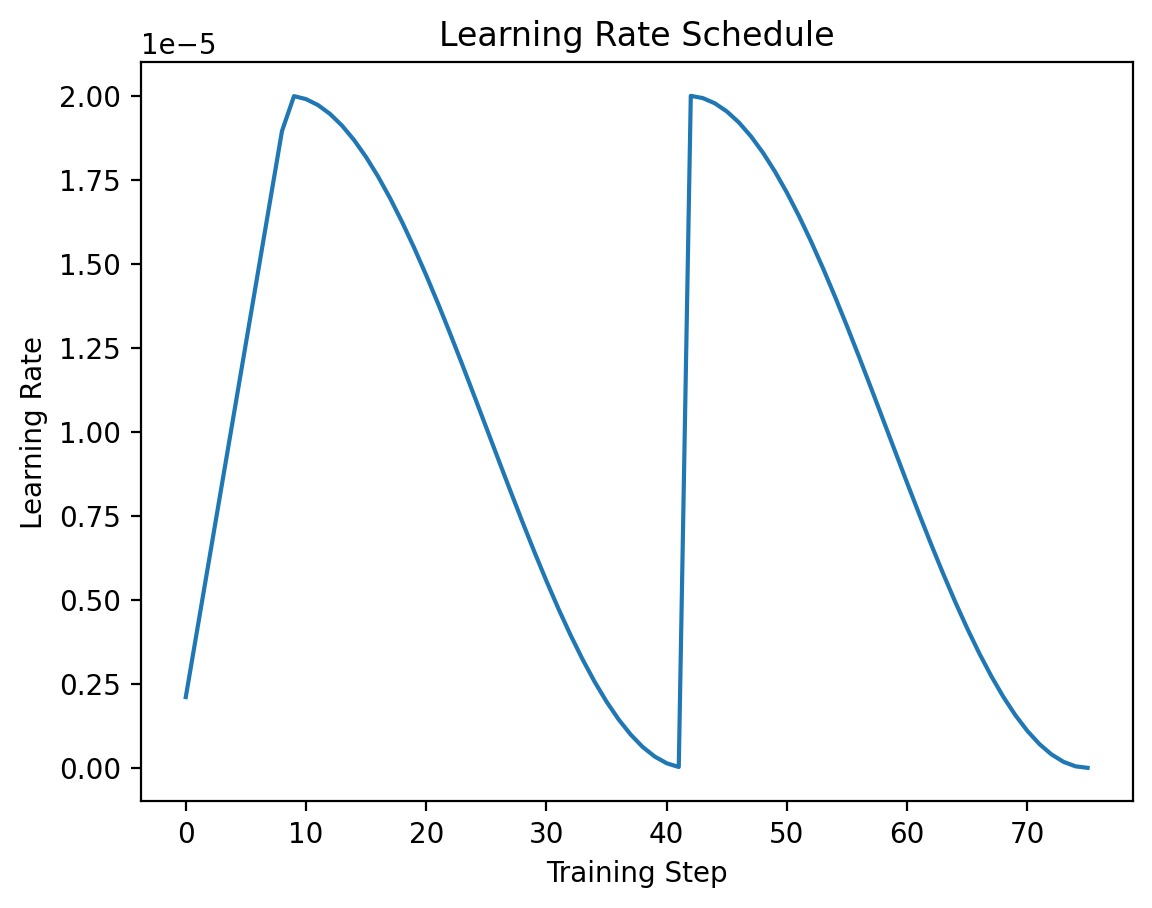

In [ ]:
# plt.plot(lr_log)
# plt.xlabel('Training Step')
# plt.ylabel('Learning Rate')
# plt.title('Learning Rate Schedule')
# plt.show()

## Trial: 100:100 Synthetic:Real Training

In [ ]:
quit()

In [ ]:
del model0, mBART50_training, model_trainer
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load model and tokenizer
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
model0 = MBartForConditionalGeneration.from_pretrained(path_stock).to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
!nvidia-smi

Wed Dec  6 05:45:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    58W / 400W |  31619MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model0 = MBartForConditionalGeneration.from_pretrained(path_stock).to(device)

In [ ]:
len(synthetic_corpora['synth_splits_100']['train_eng_inputs'])

2410

In [ ]:
len(corpora_splits['train_eng_inputs'])

41653

In [ ]:
model_trainer = mBART50_training(model0, tokenizer0, synthetic_corpora['synth_splits_100'],
                                        foldername="mBART50-Flores", epochs=10,
                                        batch_size=48, src_lang='en_XX', tgt_lang='tl_XX')


Step,Training Loss,Validation Loss
1,11.563700,11.481810
2,11.574400,11.481395
3,11.714600,11.480547
4,11.546000,11.479270
5,11.485000,11.477545
6,11.618400,11.396582
7,11.408500,11.277313
8,11.427000,11.124112
9,11.373300,10.954116
10,11.154600,10.787246


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 18.546 mins


## Save Trained Model and Tokenizer

In [ ]:
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Flores/231206-055014'

In [ ]:
# Save the trained model + tokenizer
model_trainer.save_model(log_dir)


# Loss Metric Functions

## Extract Train Metrics Function

In [ ]:
def extract_metrics(trainer):
  """
  Function to retreive training metrics from trainer
  Input: Trainer() class object
  Output: Dictionary with train_loss, val_loss lists
  """
  metrics = {'train_loss': [],
             'val_loss':   []}

  for log in trainer.state.log_history:
      if 'loss' in log.keys():
          metrics['train_loss'].append(log['loss'])
      if 'eval_loss' in log.keys():
          metrics['val_loss'].append(log['eval_loss'])

  return metrics


In [ ]:
metrics = extract_metrics(model_trainer)
metrics.keys()

dict_keys(['train_loss', 'val_loss'])

## Plot Training Metrics Function

In [ ]:
def plot_metrics(metrics, save=False):
    """
    Function to plot training metrics
    Input: Dictionary with train_loss, val_loss lists
        - save: whether to save figure to directory
    Output: Plot of training metrics
    """
    train_loss = metrics['train_loss']
    val_loss = metrics['val_loss']

    steps = [i for i in range(len(train_loss))]
    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_loss, label="Train Loss", marker='o', color='blue')
    plt.plot(steps, val_loss, label="Val Loss", marker='o', color='orange')
    plt.xlabel("Step")
    plt.ylabel("Metrics Value")
    plt.title(f"Training and Validation Metrics: model-{log_dir.split('/')[-1]}")
    plt.xticks(range(0, len(steps), 10), steps[::10])
    plt.legend()
    if save:
        plt.savefig(log_dir+f"loss_curves-model-{log_dir.split('/')[-1]}.png", format='png', dpi=300)
    plt.show()


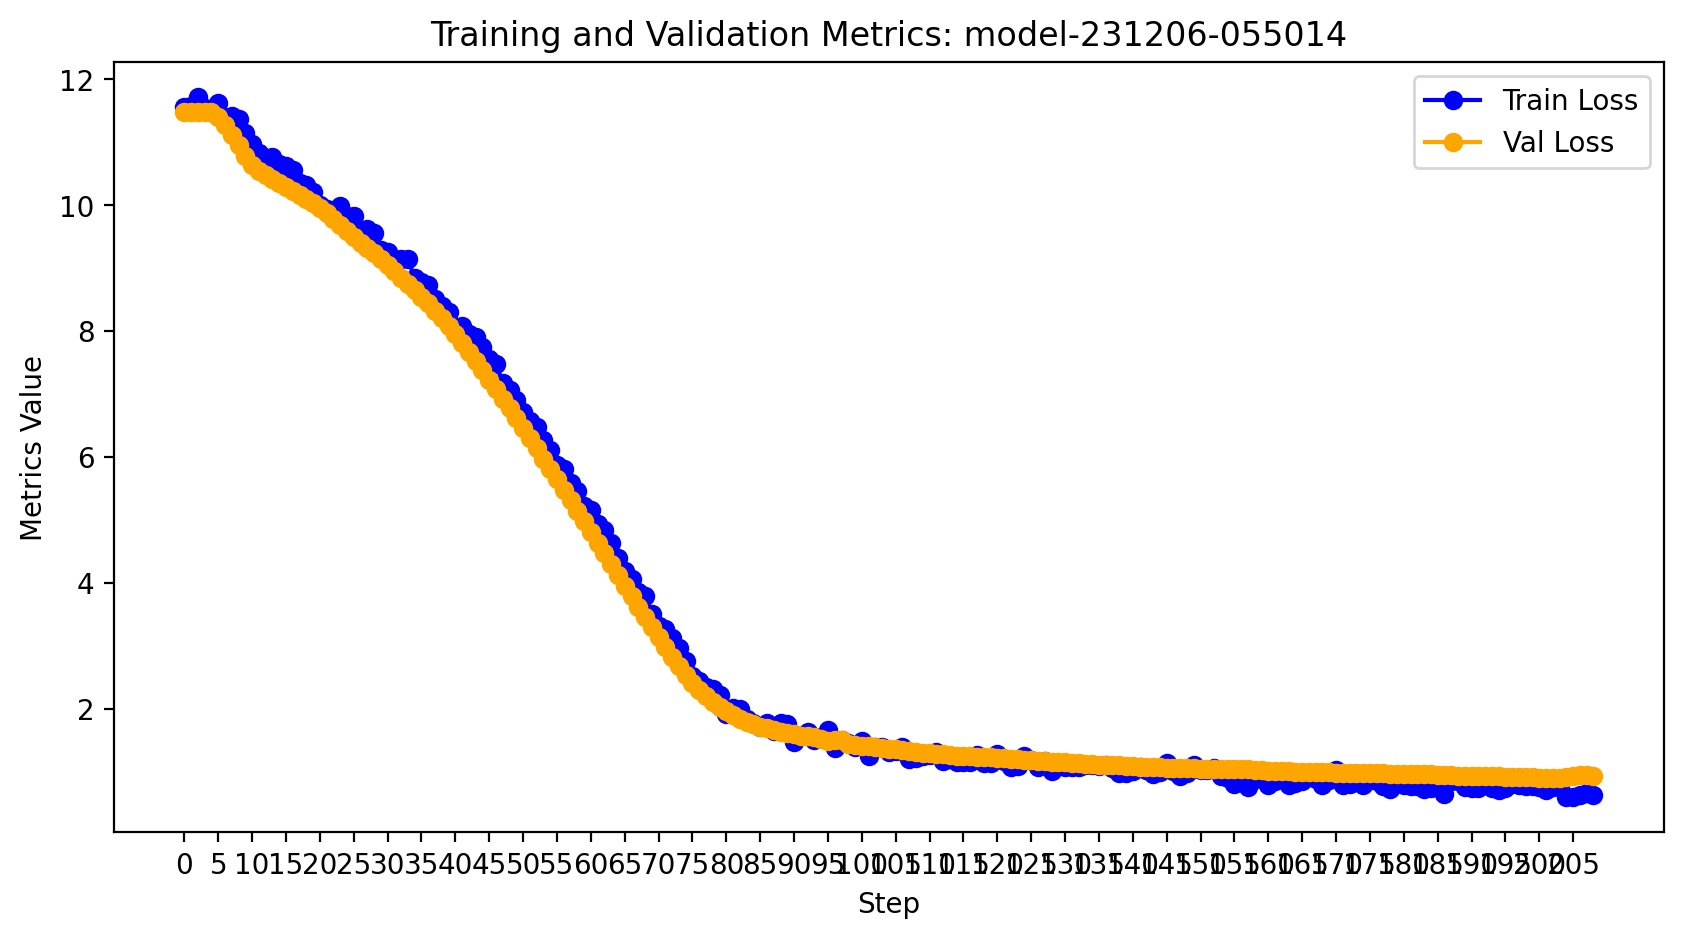

In [ ]:
plot_metrics(metrics) # trained on 100:100 synthetic:real data

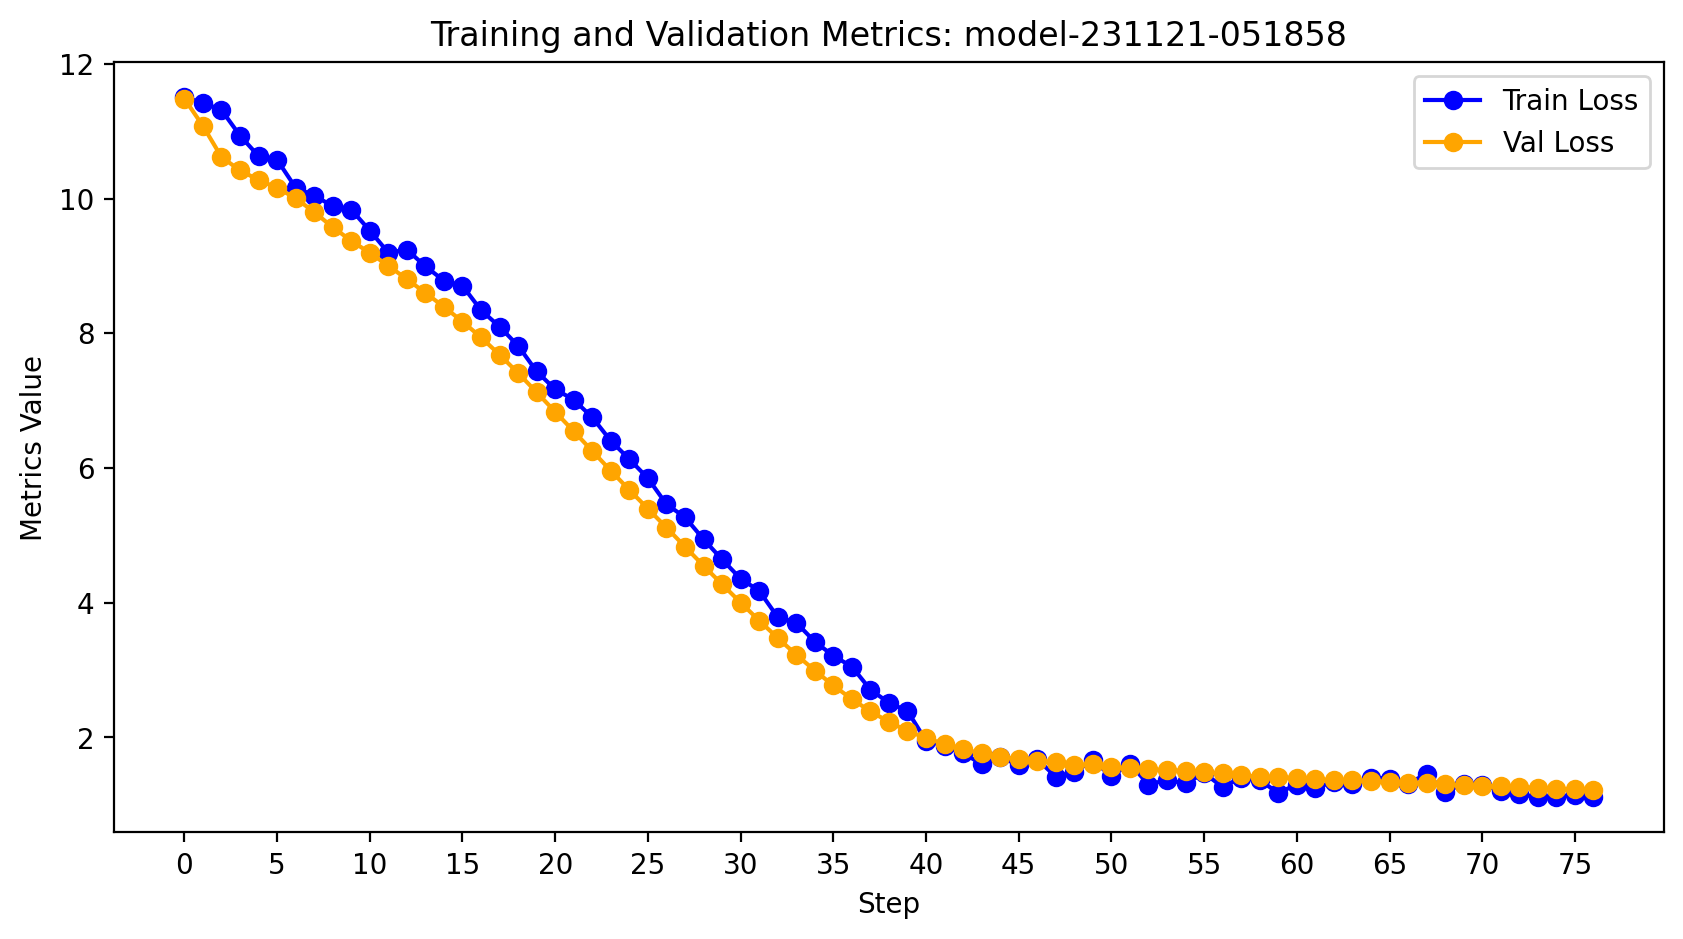

In [ ]:
plot_metrics(metrics) # 2st run, warmup 50%, batch 32, lr 6e-5, stop 77	1.109300	1.224451

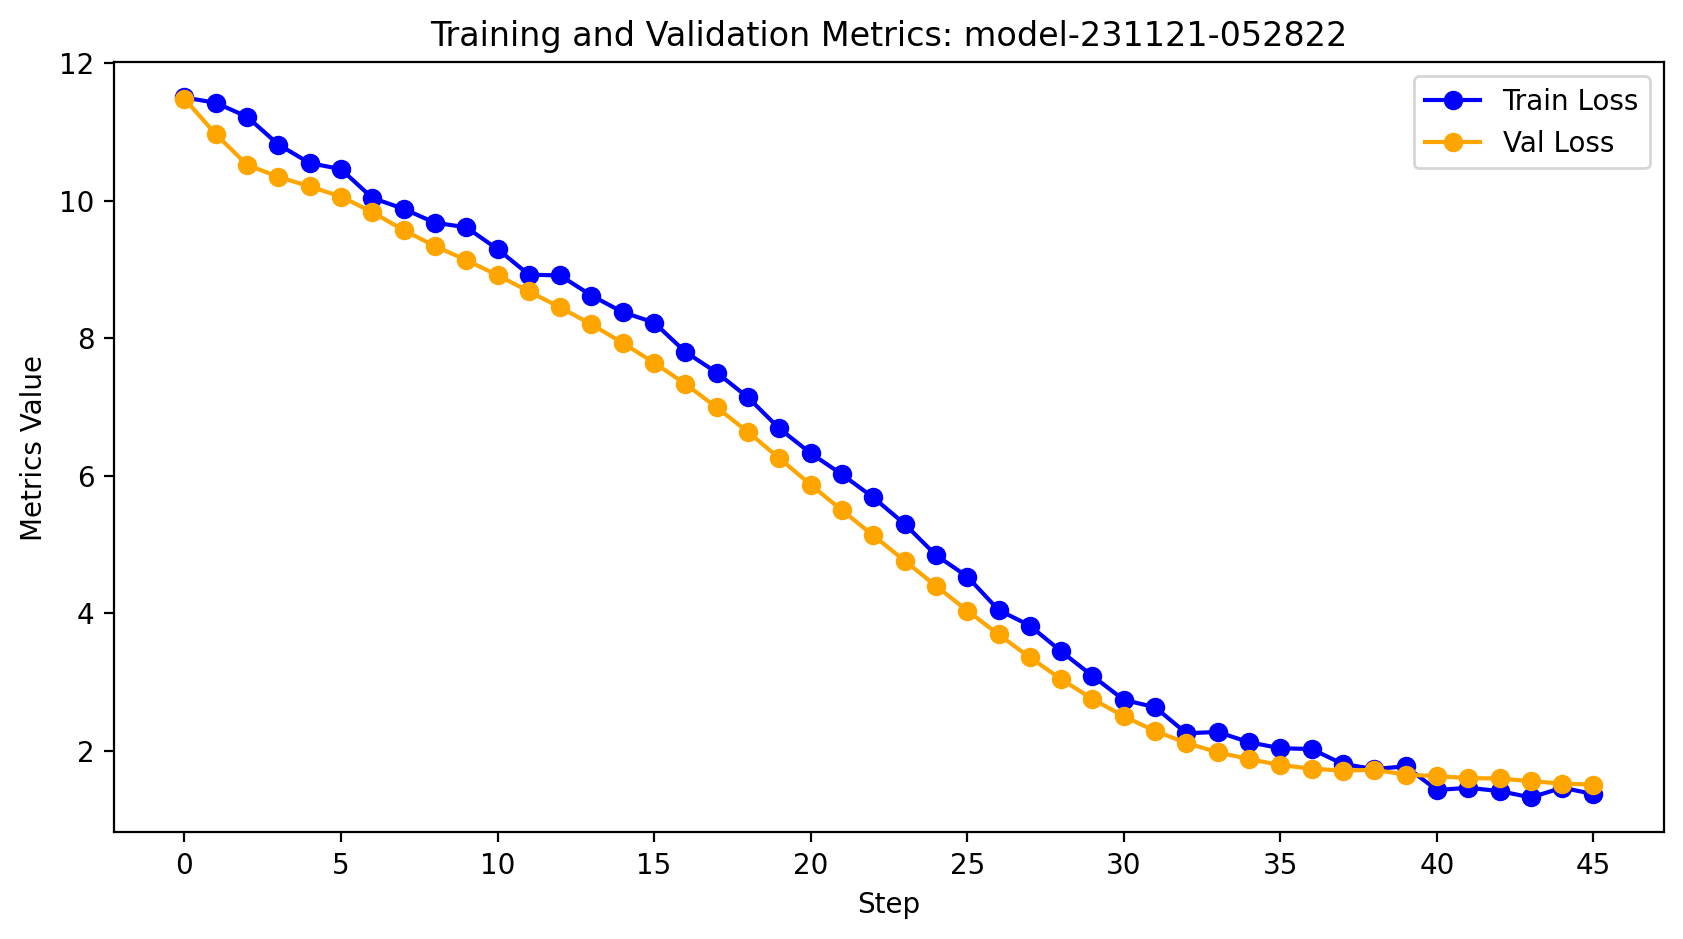

In [ ]:
plot_metrics(metrics) # 3rd run, warmup 50%, batch 32, lr 8e-5, stop 46	1.369000	1.505836

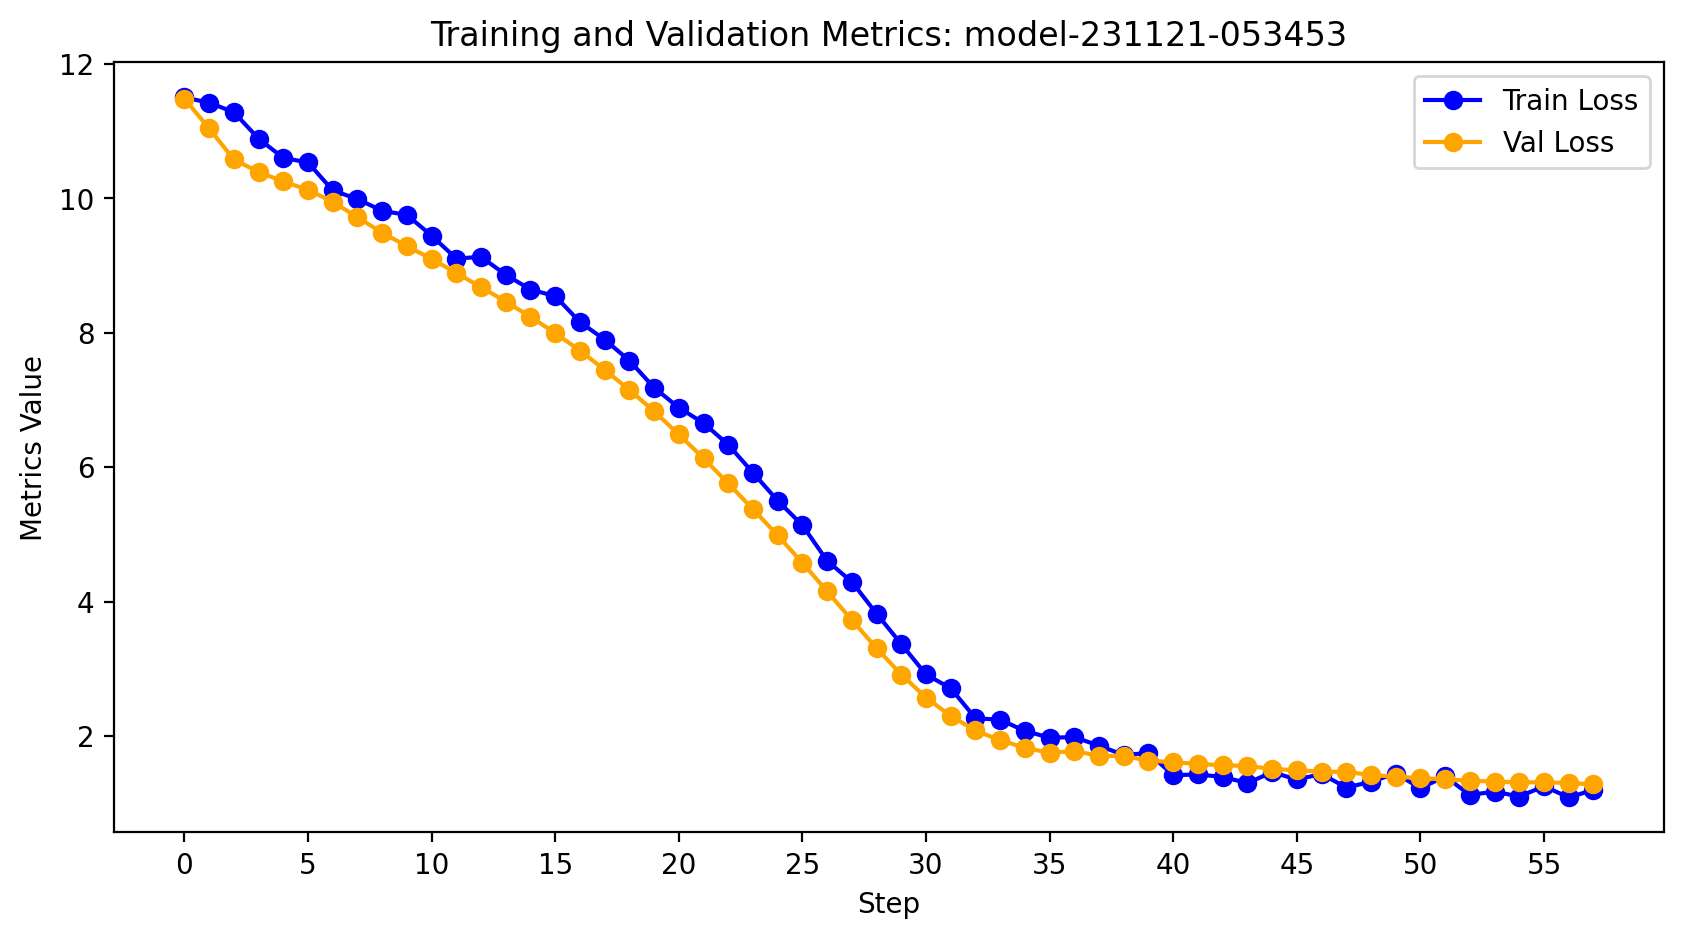

In [ ]:
plot_metrics(metrics) # 4th run, warmup 75%, batch 32, lr 1e-4, stop 58	1.200500	1.281085

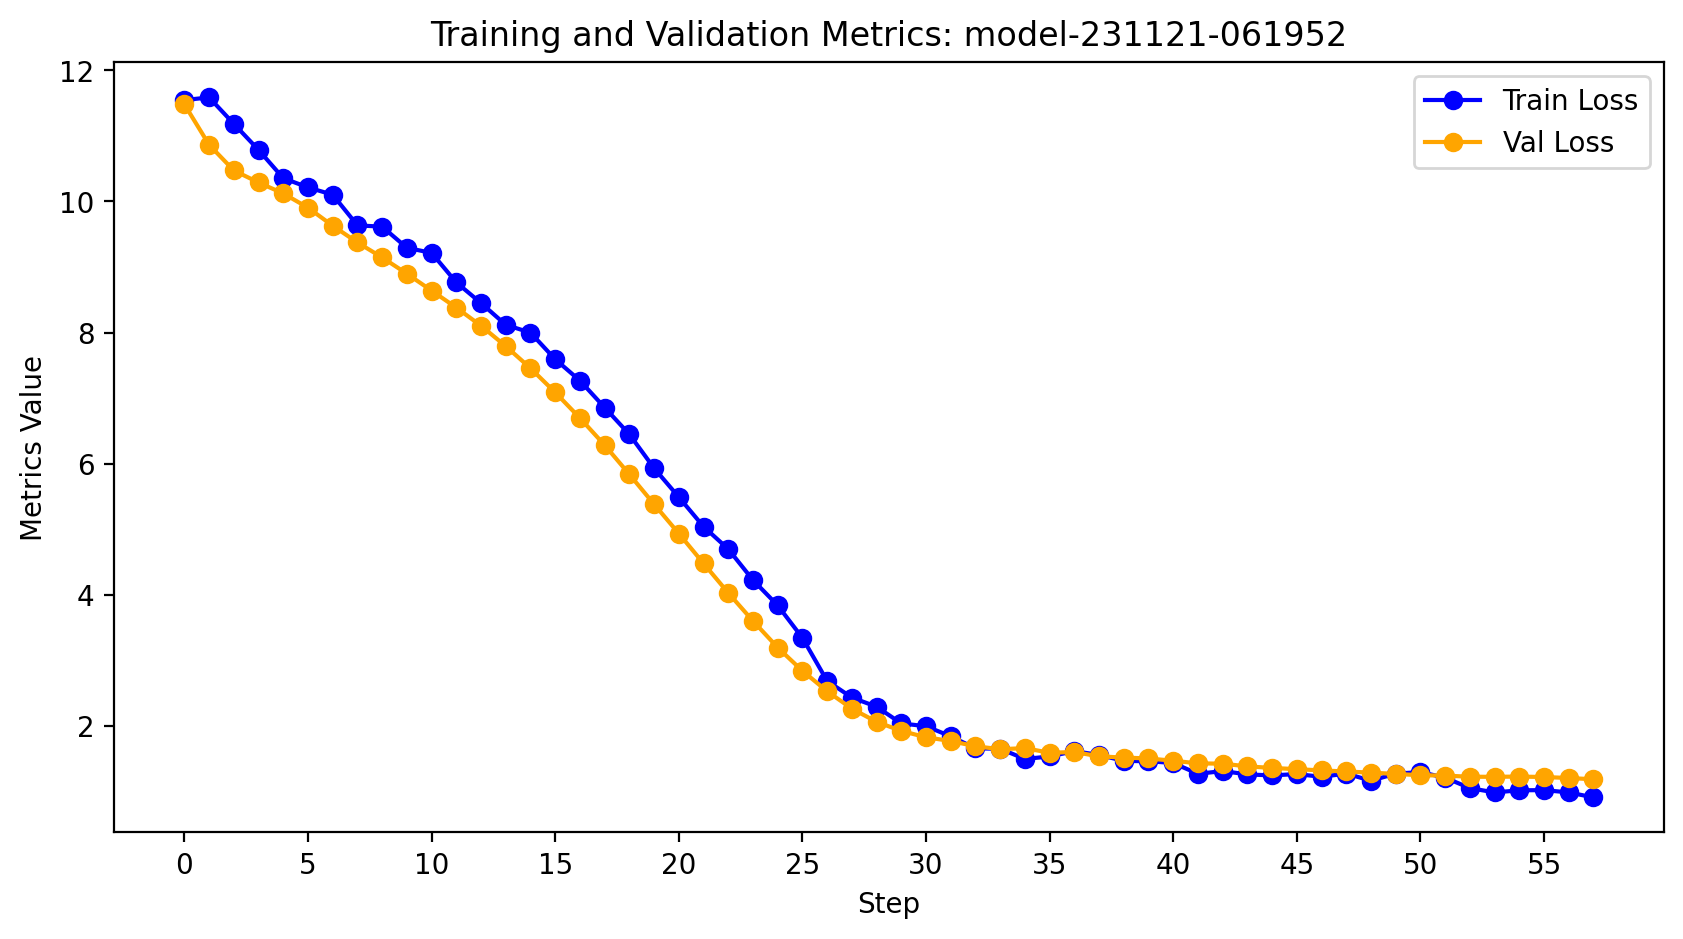

In [ ]:
plot_metrics(metrics) # 5th run, warmup 75%, batch 48, lr 1e-4, stop 58	0.909400	1.186546

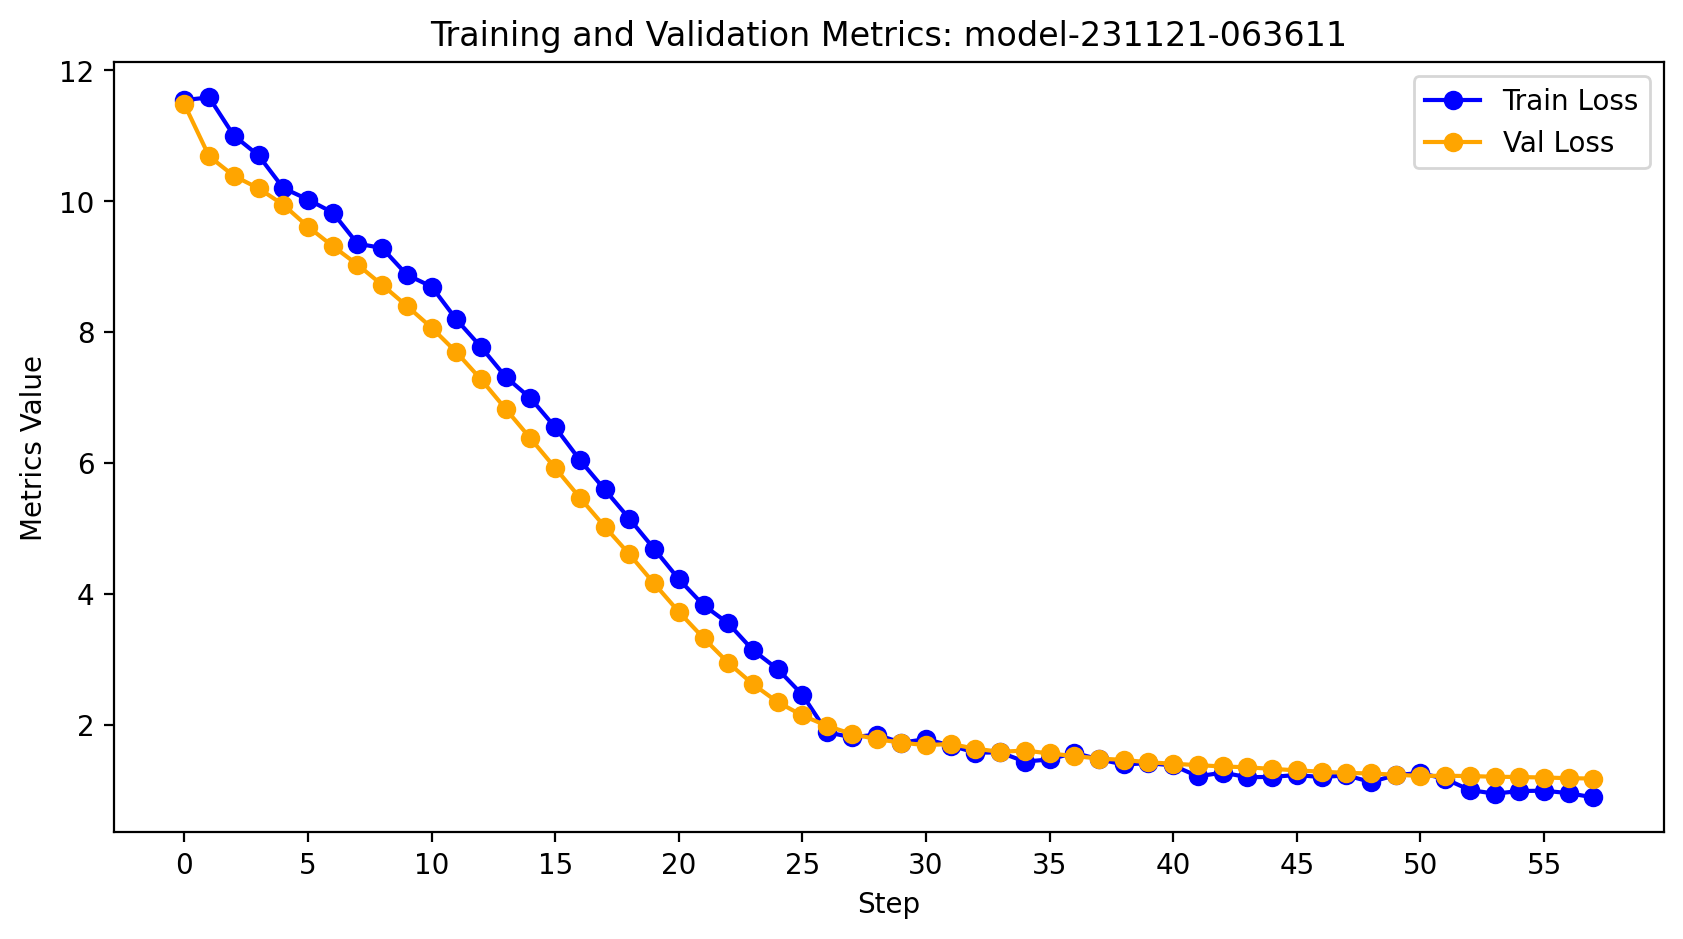

In [ ]:
plot_metrics(metrics) # 6th run, warmup 50%, batch 48, lr 1e-4, stop 58	0.891500	1.179980

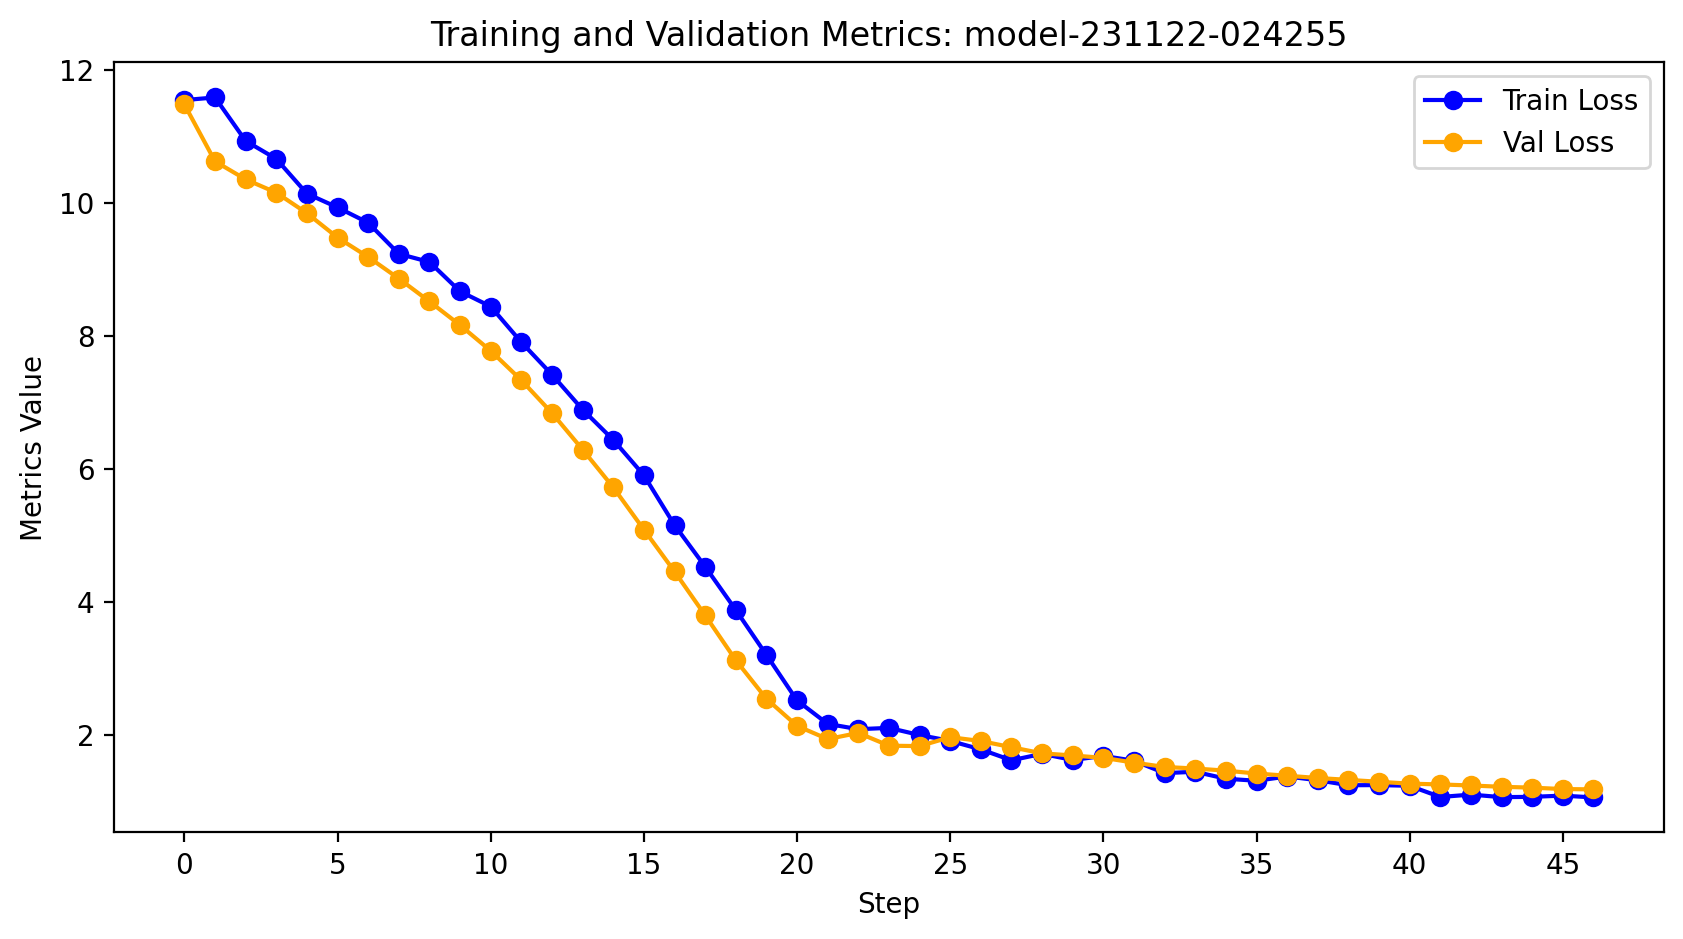

In [ ]:
plot_metrics(metrics) # 7th run, warmup 85%, batch 48, lr 2e-4, stop 47	1.060500	1.182030

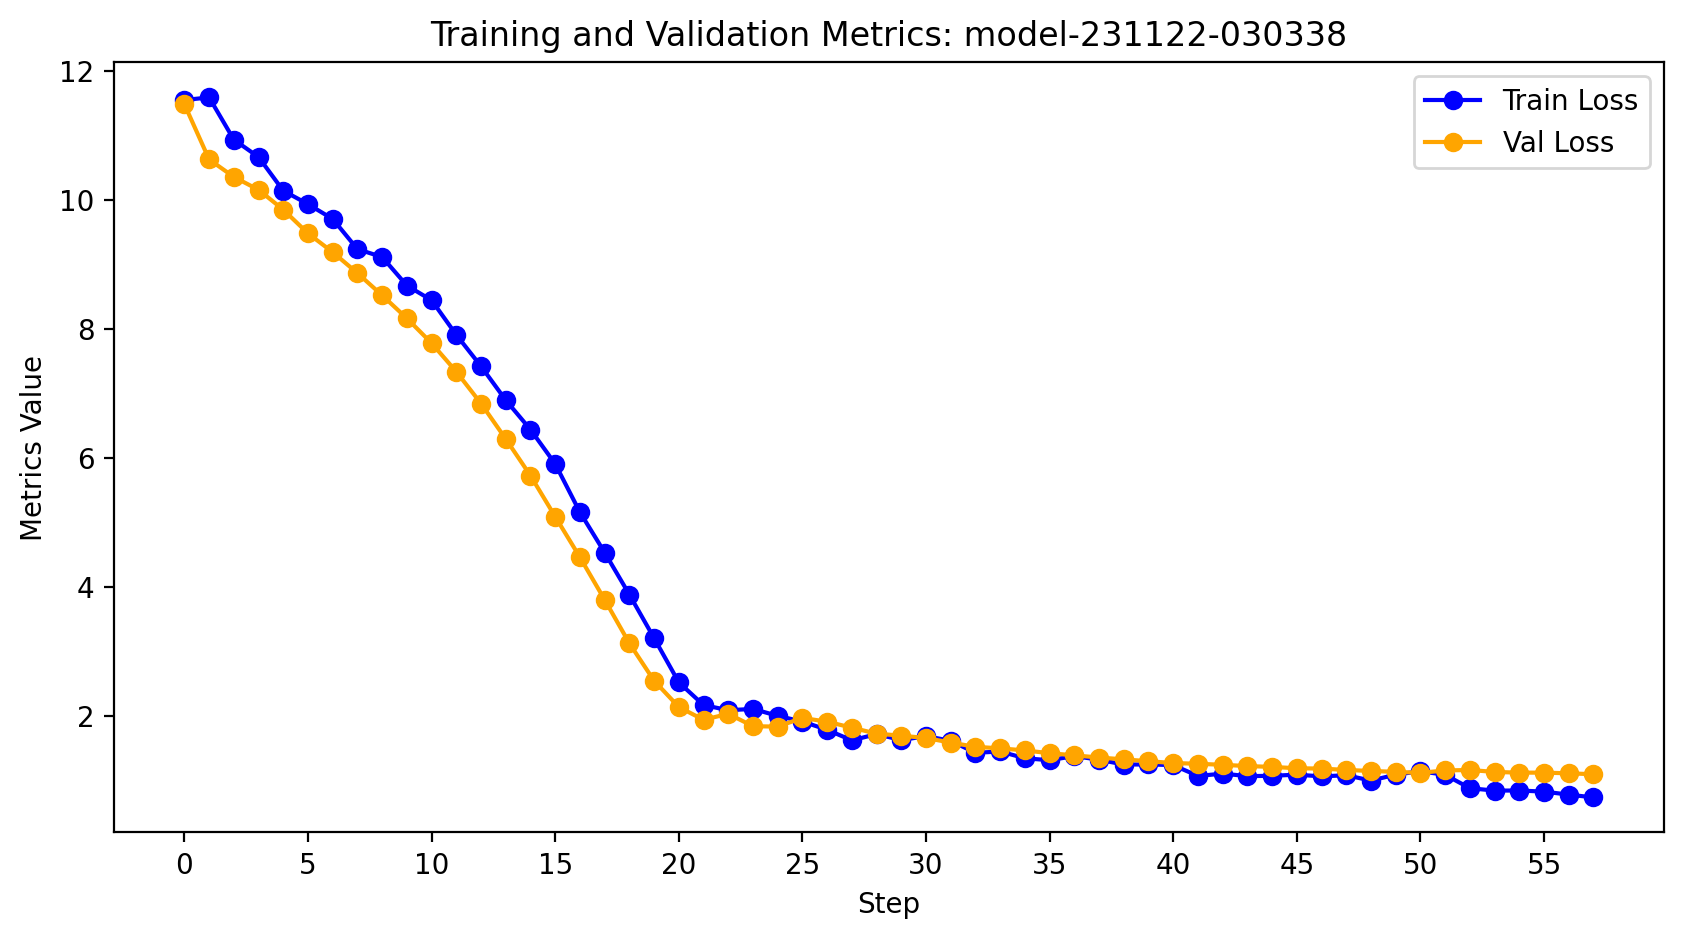

In [ ]:
plot_metrics(metrics) # 8th run, warmup 110%, batch 48, lr 5e-4, stop 58	0.734300	1.094099

In [ ]:
log_dir # model ID/path AFTER hyperparameter tuning

'../home/MyDrive/Colab_Notebooks/mBART50-Flores/231203-030203'

## Trial: Inference and Eval

In [ ]:
model0 = MBartForConditionalGeneration.from_pretrained(log_dir).to(device)

In [ ]:
!nvidia-smi

Sun Dec  3 03:22:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |  12759MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
inference = mBART50_translator(model_=model0, tokenizer_=tokenizer0, inputs=flores_splits['test_eng_inputs'],
                                src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [06:38<00:00,  1.01it/s]


Elasped Time: 6.65 mins


In [ ]:
# save translations from experiement with synthetic 25%
with open('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_100/231206-055014/synthetic_100_tgl_predictions.txt', 'w') as file:
    for string in inference:
        file.write(string[0] + '\n')

In [ ]:
native_inference = mBART50_translator(model_=model0, tokenizer_=tokenizer0, inputs=native_speaker_eval_eng,
                                src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Elasped Time: 0.045 mins


In [ ]:
native_inference

[['Isang botella ay nahulog sa floor at nahulog.'],
 ['Mayroon mo.'],
 ['Sinabi na mag-sorry sa kung ano ang nananatili, hindi ko naniniwalaan ni Hae Ra na mag-iwan ito.'],
 ['CAPULET DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG, DYANG DYANG DYANG!'],
 ['At ano ang Irene Adler?']]

In [ ]:
bleu_bleurt(predicted_labels=inference, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


{'bleu_score': 0.2162340462951096, 'bleurt_score': 0.40385674759374923}

## Tensorboad Visualization

In [ ]:
%reload_ext tensorboard

In [ ]:
!kill 12951

In [ ]:
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-FloRes/231121-043340'

In [ ]:
# visualize training data
%tensorboard --logdir log_dir

In [ ]:
# close runtime; save dem credits ^_^'
runtime.unassign()

# Experiments: Training, Inference, Evaluation

**Model Legend:**
- Model 0: Stock mBART50
- Model 1: Reverse-trained on real tgl-eng corpus
- Model s: Forward-trained on % synthetic eng-tgl corpus

In [ ]:
native_speaker_eval_eng = ['A bottle fell onto the floor and shattered.',
                           'Look at me.',
                           "Saying sorry for what happened, I don't think Hae Ra would want that.",
                           'CAPULET Why, how now, kinsman! wherefore storm you so?',
                           'And what of Irene Adler?']

native_speaker_eval_tgl = ['Bote isang nahulog papunta sa sahig at shattered.',
                           'Tignan mo ako.',
                           'Patawad sa nangyari, tingin ko ayaw mangyari ni Hae Ra yun',
                           'CAPULET Bakit, paano ngayon, kamag-anak! sa ganyan bagyo mo ito?',
                           '"At kung ano ng Irene Adler?"']

## Baseline

In [ ]:
# check if TPU/GPU/CPU available to set device
try:
    xm.is_available()
    device = xm.xla_device()
except:
    try:
        if torch.cuda.is_available() == False:
            raise Exception()
        else:
            device = torch.device('cuda')
    except:
        device = torch.device('cpu')

device

device(type='cuda')

In [ ]:
# load model and tokenizer
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
model0 = MBartForConditionalGeneration.from_pretrained(path_stock).to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# translate with stock model
baseline_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                           inputs=flores_splits['test_eng_inputs'])

100%|██████████| 402/402 [08:50<00:00,  1.32s/it]


Elasped Time: 8.852 mins


In [ ]:
# inspect translations
baseline_translations[0:5]

[['aw) 1994: Aserbaijan declares war against the Azeris (Armenian-Armenian Nagorno-Karabakh region of Azerbaijan declares war against the Azeris).'],
 ['aw was unhurt in the accident.'],
 ['ini, Ayatollah Ali Khamenei, has described the dependency on oil as "a trap" dating from before Iran\'s Islamic revolution in 1979 and from which the country should free itself from which the country should free itself.'],
 ['inien was relatively peaceful and defense was only required against small bands of roving marauders In the 1480s, when its construction was started by Lord Hastings, the country was relatively peaceful and defense was relatively peaceful and defense was relatively peaceful and defense was relatively.'],
 ["aar's guests were mostly citizens of the United Arab Emirates."]]

In [ ]:
# ground truth
flores_splits['test_tgl_labels'][0:5]

['Noong 1994, ang katutubong Armenian na rehiyon ng Nagorno-Karabakh sa Azerbaija ay nagsagawa ng digmaan laban sa mga taga-Azeri.',
 'Hindi nasaktan si Zayat sa naturang aksidente.',
 'Ang supremong pinuno ng bansa, si Ayatollah Ali Khamenei, ay inilarawan ang pagpapakalinga sa langis bilang "isang bitag" na nagsimula bago ang rebolusyong Islamic ng Iran noong 1979 at kung kailan pinalaya ng bansa ang sarili nito.',
 'Noong dekada ng 1480, nang simulan ni Lord Hastings ang pagtatayo nito, ang bansa ay tila mapayapa at ang pagdedepensa ay kinakailangan lamang laban sa maliliit na pangkat ng mga naglilibot na mandarambong.',
 'Karamihan sa mga bisita ng ostel ay mga mamamayan ng Pinag-isang Mga Emiradong Arabo.']

In [ ]:
# save baseline translations
with open("../home/MyDrive/Colab_Notebooks/mBART50-Stock/pred_test_tgl_labels.txt", 'w') as file:
    for string in baseline_translations:
        file.write(string[0] + '\n')

In [ ]:
# native-speaker eval
mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                    inputs=native_speaker_eval_eng)

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Elasped Time: 0.038 mins


[['ini: A bottle fell on the floor and shattered.'],
 ['ini: Look at me.'],
 ["ini: Promitting for what happened, I don't think Hae Ra would want that."],
 ['ini: Why, how now, kinsman! why storm you so?'],
 ['ini: And what of Irene Adler?']]

In [ ]:
# calculate scores
bleu_bleurt(predicted_labels=baseline_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


{'bleu_score': 0.041953283223732374, 'bleurt_score': 0.18386366218328476}


## Standard Fine-tuning

In [ ]:
quit()

In [ ]:
!nvidia-smi

Sun Dec  3 04:01:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |  18755MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# check if TPU/GPU/CPU available to set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# load model and tokenizer
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
model0 = MBartForConditionalGeneration.from_pretrained(path_stock).to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [56]:
# custom model configeration for inference
model0.generation_config.group_beam_search = 5
model0.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1
}

In [ ]:
# train baseline model
model_trainer_en_tl = mBART50_training(model0, tokenizer0, flores_splits,
                                       foldername='mBART50-Flores', epochs=10,
                                       src_lang='en_XX', tgt_lang='tl_XX')

You're using a MBart50TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
1,11.524100,11.481810
2,11.577300,11.480988
3,11.576800,11.479298
4,11.648700,11.476776
5,11.652300,11.473383
6,11.625400,11.313205
7,11.499400,11.093689
8,11.437500,10.856112
9,11.100300,10.657290
10,10.941700,10.529473


Step,Training Loss,Validation Loss
1,11.524100,11.481810
2,11.577300,11.480988
3,11.576800,11.479298
4,11.648700,11.476776
5,11.652300,11.473383
6,11.625400,11.313205
7,11.499400,11.093689
8,11.437500,10.856112
9,11.100300,10.657290
10,10.941700,10.529473


KeyboardInterrupt: ignored

In [ ]:
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Flores/231203-030203'

In [ ]:
# Save the trained model + tokenizer
model_trainer_en_tl.save_model(log_dir)

In [ ]:
metrics = extract_metrics(model_trainer_en_tl)
metrics.keys()

dict_keys(['train_loss', 'val_loss'])

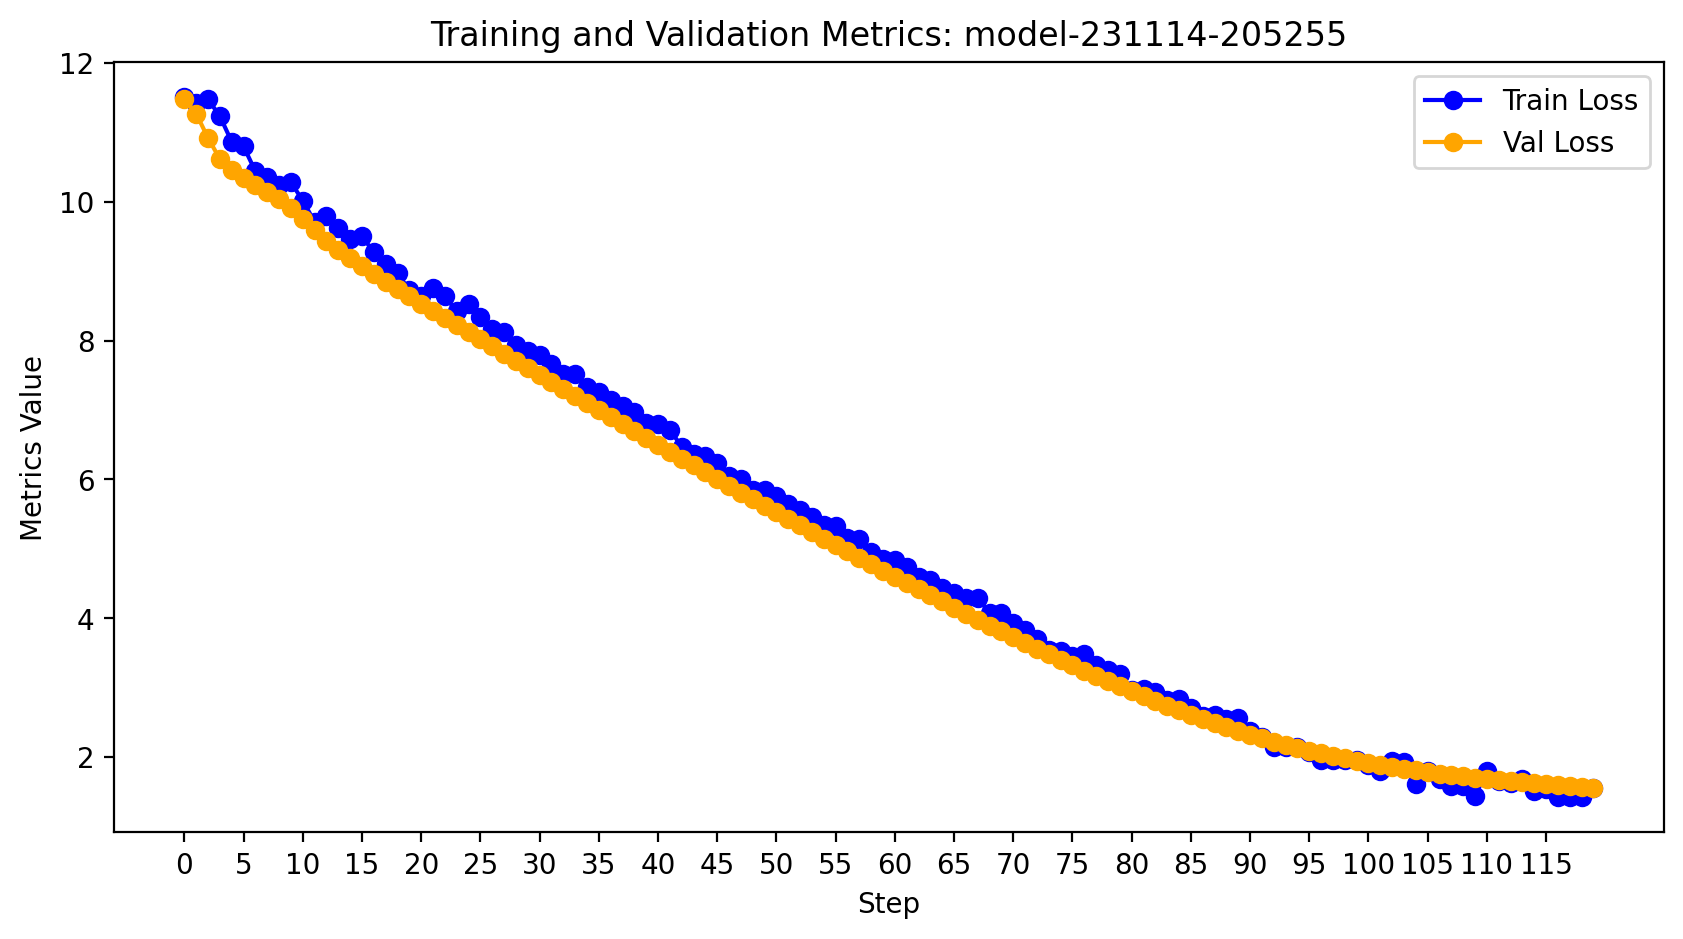

In [ ]:
plot_metrics(metrics)

In [ ]:
# visualize training data
%tensorboard --logdir log_dir

In [ ]:
del mBART50_training, model0, tokenizer0
gc.collect()
with torch.no_grad():
        torch.cuda.empty_cache

In [ ]:
# model predictions
standard_translations = mBART50_translator(model0, tokenizer0, inputs=flores_splits['test_eng_inputs'],
                       src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [09:50<00:00,  1.47s/it]


Elasped Time: 9.853 mins


In [ ]:
# inspect translations
standard_translations[0:5]

[['Noong 1994, ang etnically Armenian Nagorno-Karabakh region ng Azerbaijan ay nagtagawa ng digmaan sa mga Azeris.'],
 ['Ang Zayat ay hindi naiulat sa kaganasan.'],
 ['Ang nag-ayon na lider ng, na si Ayatollah Ali Khamenei, ay opis na ang dependensiya sa otlo bilang "ang trape" na na naiulat mula sa loob ng revolusyon Islamo ng Iran noong 1979 at naiulat mula sa ito na ang ay'],
 ['Noong 1480s, kung ang pag-abangkop ng mga ito ni Lord Hastings, ang mga landa ay parehong maharapin at ang pag-abangkop ay naimpreyable sa malawak na banda ng mga malawak na marauder.'],
 ['Karamihan ang mga tagapag-holy ng hostel ang mga pilon ng United Arab Emirates.']]

In [ ]:
# ground truth
flores_splits['test_tgl_labels'][0:5]

['Noong 1994, ang katutubong Armenian na rehiyon ng Nagorno-Karabakh sa Azerbaija ay nagsagawa ng digmaan laban sa mga taga-Azeri.',
 'Hindi nasaktan si Zayat sa naturang aksidente.',
 'Ang supremong pinuno ng bansa, si Ayatollah Ali Khamenei, ay inilarawan ang pagpapakalinga sa langis bilang "isang bitag" na nagsimula bago ang rebolusyong Islamic ng Iran noong 1979 at kung kailan pinalaya ng bansa ang sarili nito.',
 'Noong dekada ng 1480, nang simulan ni Lord Hastings ang pagtatayo nito, ang bansa ay tila mapayapa at ang pagdedepensa ay kinakailangan lamang laban sa maliliit na pangkat ng mga naglilibot na mandarambong.',
 'Karamihan sa mga bisita ng ostel ay mga mamamayan ng Pinag-isang Mga Emiradong Arabo.']

In [ ]:
# save predictions (translated sentences) to file
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in standard_translations:
        file.write(string[0] + '\n')

In [ ]:
# caluclate scores
bleu_bleurt(predicted_labels=standard_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


{'bleu_score': 0.15341722622950046, 'bleurt_score': 0.27111377733856884}

In [ ]:
# native-speaker eval
native_eval_0 = mBART50_translator(model_=model1, tokenizer_=tokenizer0,
                                   inputs=native_speaker_eval_eng)
native_eval_0

100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Elasped Time: 0.054 mins


[['Ang botella ay tumigit sa palabas at naiulat.'],
 ['Matapos na min.'],
 ['Ang pag-ayon para sa apa na nagtatagpuan, hindi naiulat na ni Hae Ra ang may mongolyo.'],
 ['Ang kapulot, kung ano, ito, karanasan! kung ano nagtagawa ng ito?'],
 ['Ang si Irene Adler?']]

In [ ]:
# close runtime; save dem credits ^_^'
runtime.unassign()

## Back-translation Fine-tuning

### Train Reverse Direction on Model 0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# load model and tokenizer from mydrive
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"

model0 = MBartForConditionalGeneration.from_pretrained(path_flores).to(device)
try:
    tokenizer0
except:
    tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# backtraining model with flores data

model_trainer_tl_en = mBART50_training(model0, tokenizer0, flores_splits,
                                          foldername='mBART50-Flores_Reverse', epochs=10,
                                          src_lang='tl_XX', tgt_lang='en_XX')


You're using a MBart50TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
1,9.271000,9.309220
2,9.329800,9.308550
3,9.230200,9.307165
4,9.507800,9.305061
5,9.460400,9.302238
6,9.408500,9.092001
7,9.394400,8.921062
8,9.445000,8.818653
9,8.922900,8.754171
10,8.950800,8.703459


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 8.494 mins


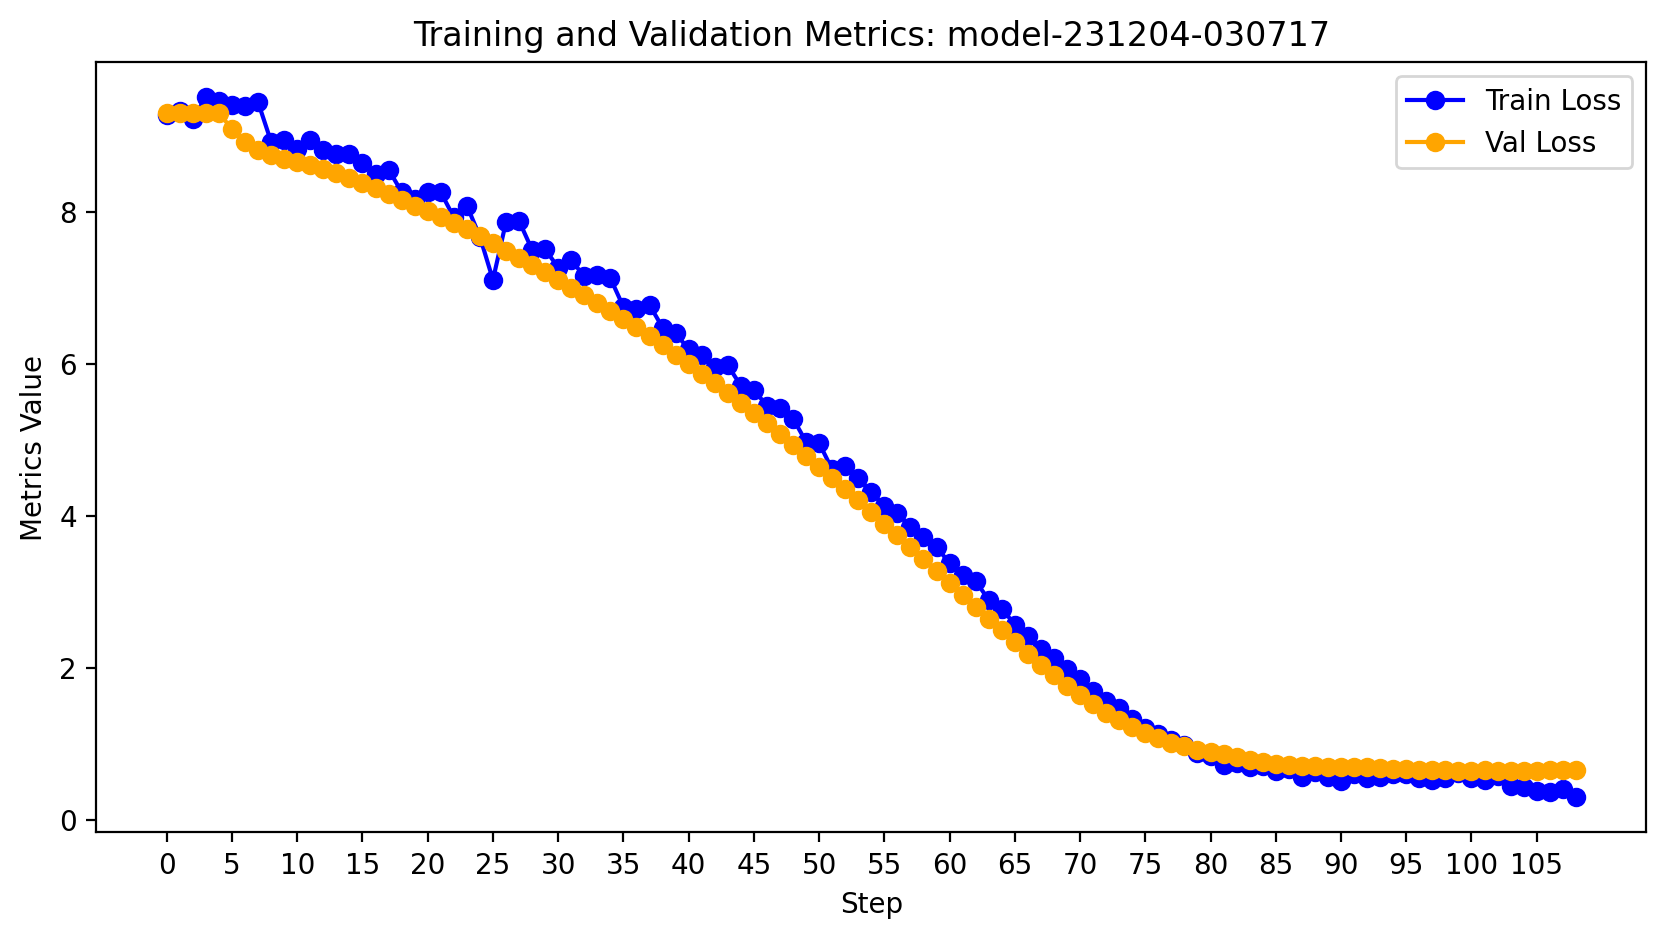

In [ ]:
metrics = extract_metrics(model_trainer_tl_en)
plot_metrics(metrics)

In [ ]:
log_dir # baseline training in backward direction

'../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717'

In [ ]:
# save the trained model + tokenizer
model_trainer_tl_en.save_model(log_dir)

In [ ]:
# load reverse-trained model and tokenizer from mydrive
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
path_reverse = "../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717"

model0 = MBartForConditionalGeneration.from_pretrained(path_reverse).to(device)
try:
    tokenizer0
except:
    tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# translate native_eng_eval in reverse direction
back_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                        inputs=native_speaker_eval_tgl,
                                        src_lang='tl_XX', tgt_lang='en_XX')

# save reverse translations
with open(os.path.join(path_reverse, 'pred_native_eng_eval.txt'), 'w') as file:
    for string in back_translations:
        file.write(string[0] + '\n')

100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


Elasped Time: 0.601 mins


In [ ]:
back_translations

[['Bote a rock climbing the river and shattered.'],
 ["I'll be fine."],
 ['Fortunately for the moment, Hae Raun was killed.'],
 ['CAPULET Let us, from now on, marvel! in what sense is this?'],
 ['"And what of Irene Adler?"']]

In [ ]:
native_speaker_eval_eng

['A bottle fell onto the floor and shattered.',
 'Look at me.',
 "Saying sorry for what happened, I don't think Hae Ra would want that.",
 'CAPULET Why, how now, kinsman! wherefore storm you so?',
 'And what of Irene Adler?']

In [ ]:
# translate flores in reverse direction
flores_back_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                        inputs=flores_splits['test_tgl_labels'],
                                        src_lang='tl_XX', tgt_lang='en_XX')

# save reverse translations
with open(os.path.join(path_reverse, 'pred_test_eng_inputs.txt'), 'w') as file:
    for string in flores_back_translations:
        file.write(string[0] + '\n')

# calculate scores
bleu_bleurt(predicted_labels=flores_back_translations, true_labels=flores_splits['test_eng_inputs'])

100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


{'bleu_score': 0.1932164531051749, 'bleurt_score': 0.5439118797061455}

In [ ]:
# load OLD real tgl samples for synthetic eng sample creation
with open('../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_splits.json', 'r') as json_file:
    culturax_splits = json.load(json_file)

In [ ]:
# validate length of monolingual set before translating
if len(culturax_splits['train_tgl_labels']) != len(flores_splits['train_eng_inputs']):
    raise ValueError('Incorrect monolingual tgl sample size!')

culturax_back_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                        inputs=culturax_splits['train_tgl_labels'],
                                        src_lang='tl_XX', tgt_lang='en_XX')

100%|██████████| 1205/1205 [14:50<00:00,  1.35it/s]


Elasped Time: 14.844 mins


In [ ]:
# flatten translation ouputs
culturax_back_translations = np.array(culturax_back_translations).flatten().tolist()

In [ ]:
# save english backtranslations
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/synthetic_eng_samples.txt', 'w') as file:
    for string in culturax_back_translations:
        file.write(string + '\n')

In [ ]:
# load english backtranslations
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/synthetic_eng_samples.txt', 'r') as file:
    culturax_back_translations = file.read().splitlines()

In [ ]:
# make dictionary of synth english and real monolingual tagalog
culturax_splits['train_eng_inputs'] = culturax_back_translations

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/CulturaX_splits.json', 'w') as json_file:
    json.dump(culturax_splits, json_file)

In [47]:
# Load CulturaX splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/CulturaX_splits.json', 'r') as json_file:
    culturax_splits = json.load(json_file)

culturax_splits.keys()

dict_keys(['train_eng_inputs', 'train_tgl_labels'])

In [48]:
for k,i in culturax_splits.items():
    print(k,len(i))

train_eng_inputs 1205
train_tgl_labels 1205


#### Expand Synthetic Corpora

In [ ]:
## make additional culturx backtranslations for larger synthetic corpus
# get 3615 tgl samples for 200/300/400 real:synthetic dataset
new_culturax = []
for i in range(len(culturax_tgl_clean)):
    s = random.sample(culturax_tgl_clean,1)
    if s[0] not in culturax_splits['train_tgl_labels']:
        new_culturax.append(s[0])
    if len(new_culturax) == 3615:
        break

# save the additional samples
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/extra_tgl_samples.txt', 'w') as file:
    for string in new_culturax:
        file.write(string + '\n')

In [ ]:
# make back translations
culturax_back_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                                inputs=new_culturax,
                                                src_lang='tl_XX', tgt_lang='en_XX')

# save english backtranslations
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/synthetic_eng_samples_2.txt', 'w') as file:
    for string in culturax_back_translations:
        file.write(string[0] + '\n')

# flatten translation ouputs
culturax_back_translations = np.array(culturax_back_translations).flatten().tolist()

# make dictionary of synth english and real monolingual tagalog
culturax_splits = {'train_eng_inputs': culturax_back_translations,
                   'train_tgl_labels': new_culturax,
}

# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/CulturaX_splits_2.json', 'w') as json_file:
    json.dump(culturax_splits, json_file)

100%|██████████| 3615/3615 [1:03:29<00:00,  1.05s/it]


Elasped Time: 63.49 mins


In [38]:
# Load CulturaX splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/CulturaX_splits_2.json', 'r') as json_file:
    culturax_splits = json.load(json_file)

culturax_splits.keys()

dict_keys(['train_eng_inputs', 'train_tgl_labels'])

In [39]:
for k,i in culturax_splits.items():
    print(k,len(i))

train_eng_inputs 3615
train_tgl_labels 3615


In [ ]:
def corpus_collator(real_splits, synth_splits, frac=1.0):
    """
    Funtion to add `frac` of synthetic data to real data,
    and return combined splits dictionary.

    Args:
        - real_splits: dict of real data splits
        - synth_splits: dict of synthetic data splits
        - frac: fraction of synthetic data to incorporate
    Returns:
        dictionary of collated data
    """
    random.seed(1234)

    sample_size = int(round(len(real_splits['train_eng_inputs']) * frac, 0))

    real_pairs = []
    for i in range(len(real_splits['train_eng_inputs'])):
        real_pairs.append([real_splits['train_eng_inputs'][i], real_splits['train_tgl_labels'][i]])

    synth_pairs = []
    for i in range(len(synth_splits['train_eng_inputs'])):
        synth_pairs.append([synth_splits['train_eng_inputs'][i], synth_splits['train_tgl_labels'][i]])

    # sample from synth dict
    synth_pair_samples = random.sample(synth_pairs, sample_size)

    mixed_pairs = synth_pair_samples + real_pairs

    # shuffle mixed samples in-place
    for i in range(100):
        random.shuffle(mixed_pairs)

    mixed_eng_inputs = []
    mixed_tgl_labels = []
    for i in range(len(mixed_pairs)):
        mixed_eng_inputs.append(mixed_pairs[i][0])
        mixed_tgl_labels.append(mixed_pairs[i][1])

    combined_splits = {
        'train_eng_inputs': mixed_eng_inputs,
        'val_eng_inputs':   real_splits['val_eng_inputs'],
        'train_tgl_labels': mixed_tgl_labels,
        'val_tgl_labels':   real_splits['val_tgl_labels']
    }

    return combined_splits


In [ ]:
## create additional synthetic corpora with 200/300/400 by joining to first synthetic corpora
new_synthetic_corpora = {
                f'synth_splits_{frac}': corpus_collator(flores_splits, culturax_splits, frac=frac/100)
                for frac in [i for i in range(100,301,100)]
}

new_synthetic_corpora.keys()

dict_keys(['synth_splits_100', 'synth_splits_200', 'synth_splits_300'])

In [ ]:
for k,i in new_synthetic_corpora['synth_splits_300'].items():
    print(k,len(i))

train_eng_inputs 3615
val_eng_inputs 402
train_tgl_labels 3615
val_tgl_labels 402


In [ ]:
# save additional synthetic corpora as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/Synthetic_corpora_2.json', 'w') as json_file:
    json.dump(new_synthetic_corpora, json_file)

In [ ]:
# load additional synthetic corpora from .json file
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/Synthetic_corpora_2.json', 'r') as json_file:
    new_synthetic_corpora = json.load(json_file)

new_synthetic_corpora.keys()

dict_keys(['synth_splits_100', 'synth_splits_200', 'synth_splits_300'])

In [ ]:
## merge original and additinal synthetic corpora to make new synthetic corpora

# original synthetic train samples
orig_train_eng = orig_synthetic_corpora['synth_splits_100']['train_eng_inputs']
orig_train_tgl = orig_synthetic_corpora['synth_splits_100']['train_tgl_labels']

# add them to new dicts
new_synthetic_corpora['synth_splits_100']['train_eng_inputs'] += orig_train_eng
new_synthetic_corpora['synth_splits_100']['train_tgl_labels'] += orig_train_tgl
new_synthetic_corpora['synth_splits_200']['train_eng_inputs'] += orig_train_eng
new_synthetic_corpora['synth_splits_200']['train_tgl_labels'] += orig_train_tgl
new_synthetic_corpora['synth_splits_300']['train_eng_inputs'] += orig_train_eng
new_synthetic_corpora['synth_splits_300']['train_tgl_labels'] += orig_train_tgl

# collate the new and the old
orig_synthetic_corpora['synth_splits_200'] = new_synthetic_corpora['synth_splits_100']
orig_synthetic_corpora['synth_splits_300'] = new_synthetic_corpora['synth_splits_200']
orig_synthetic_corpora['synth_splits_400'] = new_synthetic_corpora['synth_splits_300']

orig_synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100', 'synth_splits_200', 'synth_splits_300', 'synth_splits_400'])

In [ ]:
# create original synthetic corpora with varying ratios of real:synth samples
synthetic_corpora = {
                f'synth_splits_{frac}': corpus_collator(flores_splits, culturax_splits, frac=frac/100)
                for frac in [i for i in range(0,101,25)]
}

synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100'])

In [ ]:
# save original synthetic corpora as .json file in mydrive
# os.makedirs('../home/MyDrive/Colab_Notebooks/Synthetic', exist_ok=True)

with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/Synthetic_corpora.json', 'w') as json_file:
    json.dump(synthetic_corpora, json_file)

In [ ]:
# load original synthetic corpora from .json file
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/Synthetic_corpora.json', 'r') as json_file:
    orig_synthetic_corpora = json.load(json_file)

orig_synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100'])

In [ ]:
# save new synthetic corpora as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/Synthetic_corpora_new.json', 'w') as json_file:
    json.dump(orig_synthetic_corpora, json_file)


In [ ]:
for k,i in orig_synthetic_corpora['synth_splits_400'].items():
    print(k,len(i))

train_eng_inputs 6025
val_eng_inputs 402
train_tgl_labels 6025
val_tgl_labels 402


#### Load Synthetic Corpora

In [ ]:
# load additional synthetic corpora from .json file
with open('../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717/Synthetic_corpora_new.json', 'r') as json_file:
    synthetic_corpora = json.load(json_file)

synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100', 'synth_splits_200', 'synth_splits_300', 'synth_splits_400'])

### Train Reverse Direction on Model 1 [deprecated]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# clear up some memory
del model0, model_trainer_en_tl, tokenizer0, mBART50_training
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
!nvidia-smi

Sun Dec  3 22:37:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |   8547MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# load model and tokenizer from mydrive
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
path_flores= "../home/MyDrive/Colab_Notebooks/mBART50-Flores/231203-030203"

model1 = MBartForConditionalGeneration.from_pretrained(path_flores).to(device)
try:
    tokenizer0
except:
    tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# custom model configeration for inference
model1.generation_config.group_beam_search = 5
model1.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "group_beam_search": 5,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1
}

In [ ]:
# backtraining model with flores data for synth eng generation

model_trainer_tl_en = mBART50_training(model1, tokenizer0, flores_splits,
                                          foldername='mBART50-CulturaX', epochs=10,
                                          src_lang='tl_XX', tgt_lang='en_XX')


You're using a MBart50TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
1,1.511000,1.513132
2,1.476700,1.513091
3,1.546400,1.513000
4,1.381700,1.512858
5,1.411300,1.512664
6,1.484500,1.472033
7,1.356700,1.416422
8,1.288200,1.349962
9,1.350900,1.279209
10,1.251200,1.211292


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 5.726 mins


In [ ]:
metrics = extract_metrics(model_trainer_tl_en)
metrics.keys()

dict_keys(['train_loss', 'val_loss'])

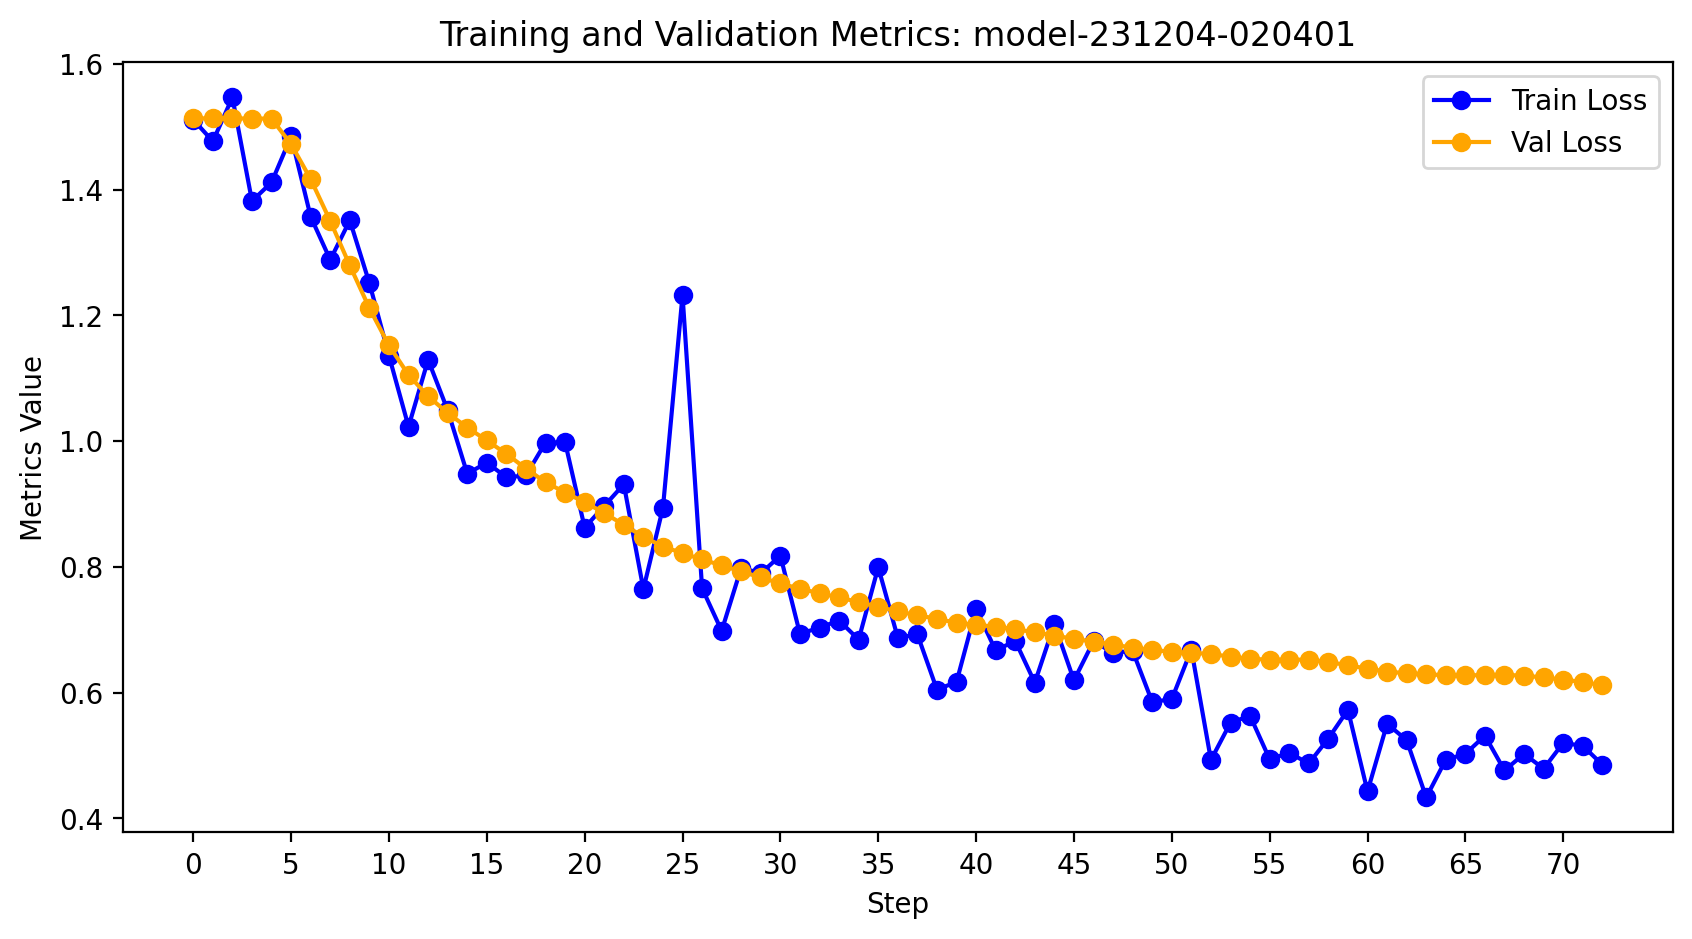

In [ ]:
plot_metrics(metrics)

In [ ]:
# visualize training data
%tensorboard --logdir log_dir

In [ ]:
log_dir # reverse-trained model on flores, will be used to create eng data from culturax

'../home/MyDrive/Colab_Notebooks/mBART50-CulturaX/231204-020401'

In [ ]:
# Save the backtrained model + tokenizer
model_trainer_tl_en.save_model(log_dir)

In [ ]:
# clear up some memory if needed
del model_trainer_tl_en, model1, mBART50_training
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load model and tokenizer from mydrive - a sanity check
path_culurax_reverse = "../home/MyDrive/Colab_Notebooks/mBART50-CulturaX/231204-020401"

model2 = MBartForConditionalGeneration.from_pretrained(path_culurax_reverse).to(device)
try:
    tokenizer0
except:
    tokenizer0 = MBart50TokenizerFast.from_pretrained(stock_path)

In [ ]:
model2.generation_config.group_beam_search = 5

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "group_beam_search": 5,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1
}

In [ ]:
# back-translation predictions on test set - a sanity check
back_translations = mBART50_translator(model_=model1, tokenizer_=tokenizer0,
                                       inputs=flores_splits['test_tgl_labels'],
                                       src_lang='tl_XX', tgt_lang='en_XX')

100%|██████████| 402/402 [04:39<00:00,  1.44it/s]


Elasped Time: 4.66 mins


In [ ]:
# inspect back-translations - a sanity check
back_translations[0:5]

[['In 1994, the main Armenian region of Nagorno-Karabakh in Azerbaijan was invaded by the Azeris.'],
 ['Zayat was not caught in a natural accident.'],
 ['The country\'s supreme ruler, Ayatollah Ali Khamenei, described the war as "a war" which began after the Iranian Islamic Revolution in 1979 and when the country lost its independence.'],
 ['In the decade of 1480, when Lord Hastings made his announcement, the country was in ruins and reconstruction needed only a small force of independent rulers.'],
 ['Most of the guests of the ostel are members of the Royal Arab Emirates.']]

In [ ]:
# ground truth for back-translations - a sanity check
flores_splits['test_eng_inputs'][0:5]

['In 1994, the ethnically Armenian Nagorno-Karabakh region of Azerbaijan waged war against the Azeris.',
 'Zayat was unhurt in the accident.',
 'The country\'s supreme leader, Ayatollah Ali Khamenei, has described the dependency on oil as "a trap" dating from before Iran\'s Islamic revolution in 1979 and from which the country should free itself.',
 'In the 1480s, when its construction was begun by Lord Hastings, the country was relatively peaceful and defense was only required against small bands of roving marauders.',
 "The hostel's guests were mostly citizens of the United Arab Emirates."]

In [ ]:
# caluclate back-translation scores - a sanity check
bleu_bleurt(predicted_labels=back_translations, true_labels=flores_splits['test_eng_inputs'])

100%|██████████| 7/7 [00:06<00:00,  1.17it/s]


{'bleu_score': 0.19358392629302806, 'bleurt_score': 0.5469324036468914}

In [ ]:
# close runtime; save dem credits ^_^'
runtime.unassign()

### Generate Synthetic English

In [ ]:
# clear up some memory if needed
del model_trainer_tl_en, model2, tokenizer1, mBART50_training
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# check memory usage
!nvidia-smi

Sun Dec  3 23:02:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |  12965MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# load model and tokenizer from mydrive, note: update checkpoint-id in path
path_culurax_reverse = "../home/MyDrive/Colab_Notebooks/mBART50-CulturaX/231203-224243"

model2 = MBartForConditionalGeneration.from_pretrained(path_culurax_reverse).to(device)
try:
    tokenizer0
except:
    tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# get real tgl samples for synthetic eng sample creation
tgl_real_len = len(culturax_tgl_clean)
eng_synth_len = len(flores_splits['train_eng_inputs'])
train_sample_intv = (tgl_real_len // eng_synth_len) + 1
culturax_samples = culturax_tgl_clean[0:tgl_real_len:train_sample_intv]

# validate length of monolingual set before translating
if len(culturax_samples) != eng_synth_len:
    raise ValueError('Incorrect monolingual tgl sample size!')

culturax_back_translations = mBART50_translator(model_=model2, tokenizer_=tokenizer0,
                                inputs=culturax_samples, src_lang='tl_XX', tgt_lang='en_XX')

100%|██████████| 1205/1205 [14:39<00:00,  1.37it/s]


Elasped Time: 14.666 mins


### Save/Load Synthetic English

In [ ]:
# flatten translation ouputs
culturax_back_translations = np.array(culturax_back_translations).flatten().tolist()

In [ ]:
# save english backtranslations
with open('../home/MyDrive/Colab_Notebooks/mBART50-CulturaX/231203-224243/synthetic_eng_samples.txt', 'w') as file:
    for string in culturax_back_translations:
        file.write(string + '\n')

In [ ]:
# load english backtranslations
with open('../home/MyDrive/Colab_Notebooks/mBART50-CulturaX/231203-224243/synthetic_eng_samples.txt', 'r') as file:
    culturax_back_translations = file.read().splitlines()

### Make Back-translated Parallel Corpus

In [ ]:
# make dictionary of synth english and real monolingual tagalog
culturax_splits = {
                    'train_eng_inputs': culturax_back_translations,
                    'train_tgl_labels': culturax_samples
}

### Save/Load Back-translated Parallel Corpus

In [ ]:
# Save splits as .json file in mydrive
with open('../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_splits.json', 'w') as json_file:
    json.dump(culturax_splits, json_file)

In [ ]:
# Load CulturaX splits into dictionary of lists
with open('../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_splits.json', 'r') as json_file:
    culturax_splits = json.load(json_file)

culturax_splits.keys()

dict_keys(['train_eng_inputs', 'train_tgl_labels'])

In [ ]:
count = 0
for string in culturax_splits['train_eng_inputs']:
    if len(string) == 0:
      count += 1
print(count)


0


### Combine Real & Synthetic Splits

In [ ]:
def corpus_collator(real_splits, synth_splits, frac=1.0):
    """
    Funtion to add `frac` of synthetic data to real data,
    and return combined splits dictionary.

    Args:
        - real_splits: dict of real data splits
        - synth_splits: dict of synthetic data splits
        - frac: fraction of synthetic data to incorporate
    Returns:
        dictionary of collated data
    """
    random.seed(1234)

    slice_idx = int(round(len(real_splits['train_eng_inputs']) * frac, 0))

    combined_splits = {
        'train_eng_inputs': real_splits['train_eng_inputs'] + synth_splits['train_eng_inputs'][:slice_idx],
        'val_eng_inputs':   real_splits['val_eng_inputs'],
        'train_tgl_labels': real_splits['train_tgl_labels'] + synth_splits['train_tgl_labels'][:slice_idx],
        'val_tgl_labels':   real_splits['val_tgl_labels']
    }

    return combined_splits

In [ ]:
# create synthetic corpora with varying ratios of real:synth samples
synthetic_corpora = {
                f'synth_splits_{frac}': corpus_collator(flores_splits, culturax_splits, frac=frac/100)
                for frac in [i for i in range(0,101,25)]
}

synthetic_corpora.keys()

### Save/Load Synthetic Corpora

In [ ]:
# Save synthetic corpora as .json file in mydrive
os.makedirs('../home/MyDrive/Colab_Notebooks/Synthetic', exist_ok=True)
with open('../home/MyDrive/Colab_Notebooks/Synthetic/Synthetic_corpora.json', 'w') as json_file:
    json.dump(synthetic_corpora, json_file)

In [ ]:
# Load synthetic corpora from .json file
with open('../home/MyDrive/Colab_Notebooks/Synthetic/Synthetic_corpora.json', 'r') as json_file:
    synthetic_corpora = json.load(json_file)

synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100'])

### Forward-train w/Synthetic Corpora 0%

In [ ]:
quit()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# load model and tokenizer
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
model0 = MBartForConditionalGeneration.from_pretrained(path_stock).to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# custom model configeration for inference
model0.generation_config.group_beam_search = 5
model0.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "group_beam_search": 5,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1
}

In [ ]:
!nvidia-smi

Mon Dec  4 04:03:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |   3569MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Do NOT Use, call training function for each key in synthetic_corpora separately

## create model trainers of model2 for each synthetic corpus ratio
# trainers = {
#     f'trainer_synth_{frac}': mBART50_training(model2, tokenizer0,
#                                               synthetic_corpora[f'synth_splits_{frac}'],
#                                               foldername=f'mBART50-Synthetic/Synthetic_{frac}',
#                                               epochs=10, src_lang='en_XX', tgt_lang='tl_XX')
#     for frac in [i for i in range(0,101,25)]
# }

In [ ]:
# forward train with synthetic corpora 0%
model_trainer_en_tl_synth_0 = mBART50_training(model0, tokenizer0,
                                              synthetic_corpora['synth_splits_0'],
                                              foldername='mBART50-Synthetic_0',
                                              epochs=10, src_lang='en_XX', tgt_lang='tl_XX')


You're using a MBart50TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
1,11.524100,11.481810
2,11.577300,11.480988
3,11.576800,11.479298
4,11.648700,11.476776
5,11.652300,11.473383
6,11.625400,11.313205
7,11.499400,11.093689
8,11.437500,10.856112
9,11.100300,10.657290
10,10.941700,10.529473


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 9.488 mins


### Save/Load model

In [ ]:
# directory where logging data was saved, saved model/tokenizer there too
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_0/231204-040554'

In [ ]:
# Save the trained model + tokenizer
model_trainer_en_tl_synth_0.save_model('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_0/231204-040554')

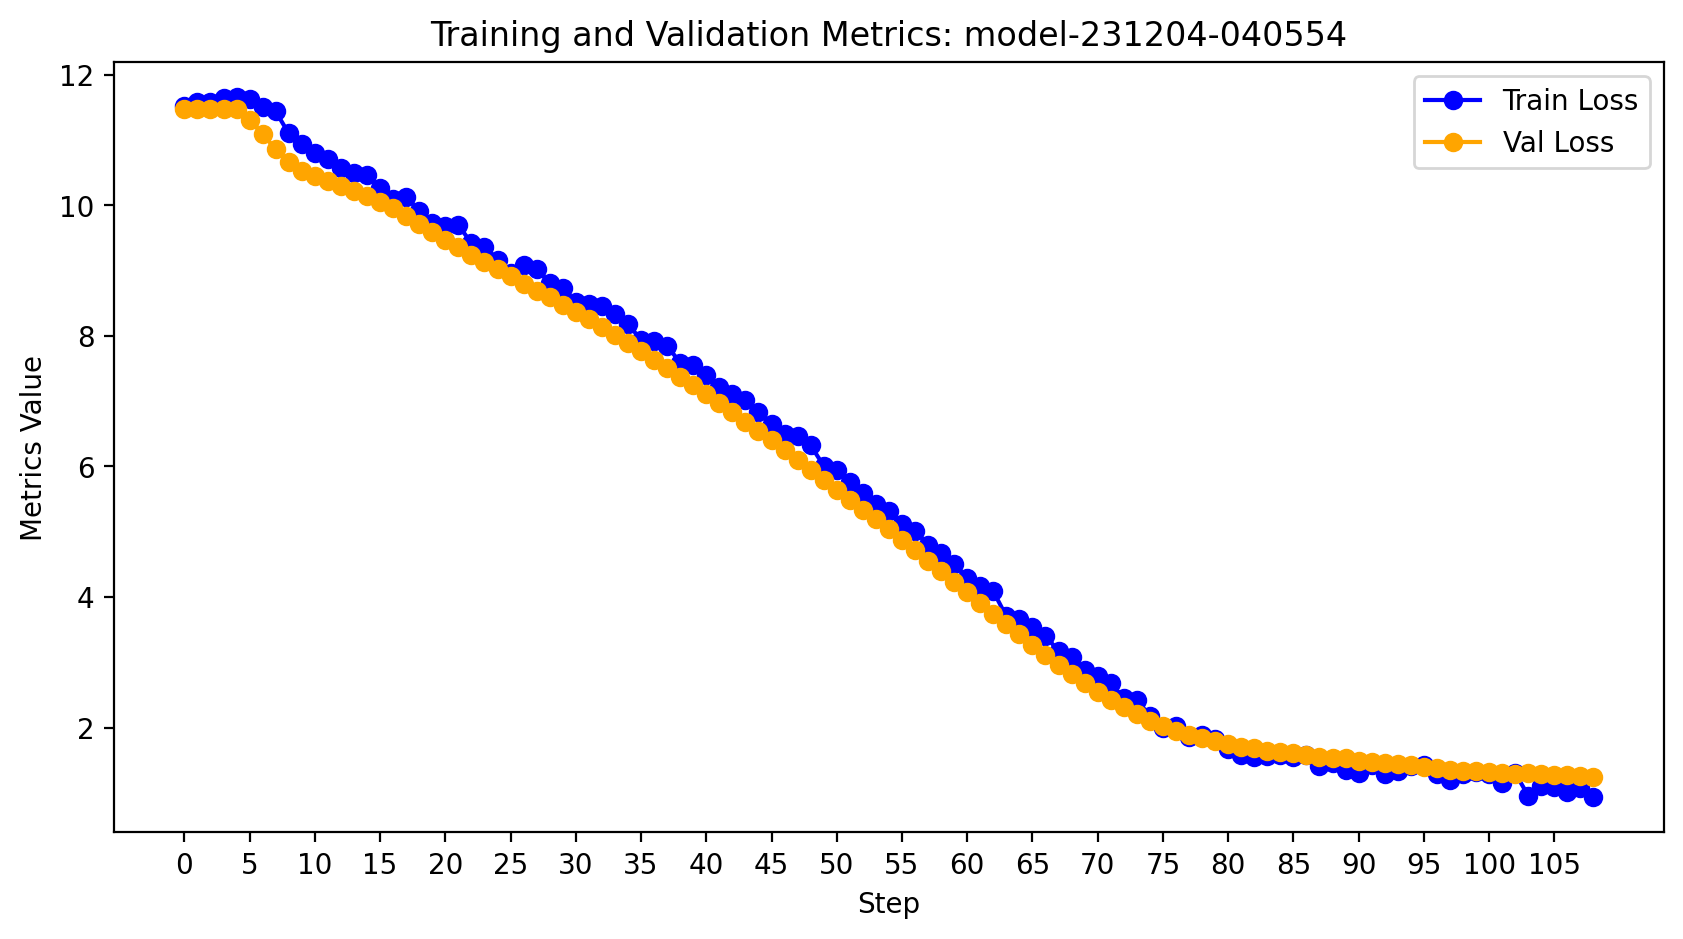

In [ ]:
# visualize loss curve
metrics = extract_metrics(model_trainer_en_tl_synth_0)
plot_metrics(metrics)

### Inference & Evaluation

In [ ]:
# translations after training w/0% synthetic:real parallel corpus
synthetic_0_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                inputs=flores_splits['test_eng_inputs'], src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [10:07<00:00,  1.51s/it]


Elasped Time: 10.124 mins


In [ ]:
synthetic_0_translations[:10]

[['Noong 1994, ang etnically Armenian Nagorno-Karabakh region ng Azerbaijan ay nagtagawa ng digmaan sa mga Azeris.'],
 ['Ang Zayat ay hindi naiulat sa kaganasan.'],
 ['Ang nag-ayon na lider ng, na si Ayatollah Ali Khamenei, ay opis na ang dependensiya sa otlo bilang "ang trape" na na naiulat mula sa loob ng revolusyon Islamo ng Iran noong 1979 at naiulat mula sa ito na ang ay'],
 ['Noong 1480s, kung ang pag-abangkop ng mga ito ni Lord Hastings, ang mga landa ay hindi malalasang hilalang-alang at ang pag-apagan ay naimpreyable sa malawak na banda ng mga malawak na marauder.'],
 ['Karamihan ang mga tagapag-holy ng hostel ang mga pilon ng United Arab Emirates.'],
 ['Gayunpaman, magtagawa ng mga radyo mula sa mga awtoridad, nagtagawa ng mga sinaw, at nagtagawa ng mga palabas para sa seguridad.'],
 [''],
 ['Ang Israel ay nag-aalik ng nag-ibang presence na militaro sa dalyo para sa loob ng isang dekada nang nanatili ng unanimidad nang ang PA ay nag-agredo na mag-ibang presence ng mga ito par

In [ ]:
flores_splits['test_tgl_labels'][:10]

['Noong 1994, ang katutubong Armenian na rehiyon ng Nagorno-Karabakh sa Azerbaija ay nagsagawa ng digmaan laban sa mga taga-Azeri.',
 'Hindi nasaktan si Zayat sa naturang aksidente.',
 'Ang supremong pinuno ng bansa, si Ayatollah Ali Khamenei, ay inilarawan ang pagpapakalinga sa langis bilang "isang bitag" na nagsimula bago ang rebolusyong Islamic ng Iran noong 1979 at kung kailan pinalaya ng bansa ang sarili nito.',
 'Noong dekada ng 1480, nang simulan ni Lord Hastings ang pagtatayo nito, ang bansa ay tila mapayapa at ang pagdedepensa ay kinakailangan lamang laban sa maliliit na pangkat ng mga naglilibot na mandarambong.',
 'Karamihan sa mga bisita ng ostel ay mga mamamayan ng Pinag-isang Mga Emiradong Arabo.',
 'Gayunpaman, sundin ang payo ng mga awtoridad, sundin ang lahat ng karatula, at bigyang atensyon ang mga babalang pangkaligtasan.',
 'Pwede ka ring magkaroon ng mga haluang metal na may kahalong kaunting mga di-metalikong elemento gaya ng karbon.',
 'Hinihiling ng Israel ang p

In [ ]:
# save translations from experiement with synthetic 0%
with open('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_0/231204-040554/synthetic_0_tgl_predictions.txt', 'w') as file:
    for string in synthetic_0_translations:
        file.write(string[0] + '\n')

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_0/231204-040554/synthetic_0_tgl_predictions.txt', 'r') as file:
    synthetic_0_translations = file.read().splitlines()

In [ ]:
len(synthetic_0_translations)

402

In [ ]:
cnt=0
for string in synthetic_0_translations:
    if len(string) == 0:
        cnt+=1
print(cnt)

22


In [ ]:
# prompt: what are the indices of strings with length 0 in this list synthetic_0_translations

blanks = [index for index, string in enumerate(synthetic_0_translations) if len(string) == 0]


In [ ]:
len(synthetic_0_translations), len(blanks)

(402, 22)

In [ ]:
# prompt: How to remove elements from list give a list of indices?

clean_translations = [x for i, x in enumerate(synthetic_0_translations) if i not in blanks]


In [ ]:
len(clean_translations)

380

In [ ]:
adjusted_test_set = [x for i, x in enumerate(flores_splits['test_tgl_labels']) if i not in blanks]

In [ ]:
# prompt: turn a list of elements in to a list of lists of elements

prep_translations = [[x] for x in clean_translations]


In [ ]:
# caluclate scores
bleu_bleurt(predicted_labels=prep_translations, true_labels=adjusted_test_set)

100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


{'bleu_score': 0.16215568885949538, 'bleurt_score': 0.2826473792524714}

In [ ]:
# native-speaker eval
native_eval_0 = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                   inputs=native_speaker_eval_eng)
native_eval_0

100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Elasped Time: 0.054 mins


[['Ang botella ay tumigit sa palabas at naiulat.'],
 ['Matapos na min.'],
 ['Ang pag-ayon para sa apa na nagtatagpuan, hindi naiulat na ni Hae Ra ang may mongolyo.'],
 ['Ang kapulot, kung ano, ito, karanasan! kung ano nagtagawa ng ito?'],
 ['Ang si Irene Adler?']]

## Training w/ 25% Synthetic Corpora

In [ ]:
quit()

In [ ]:
# clear up some memory if needed
del model1, mBART50_training
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!nvidia-smi

Wed Dec  6 10:59:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    56W / 400W |  40297MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# forward train with synthetic corpora 25%
model_trainer_en_tl_synth_25 = mBART50_training(model0, tokenizer0,
                                              synthetic_corpora['synth_splits_25'],
                                              foldername='mBART50-Synthetic_25',
                                              epochs=10, src_lang='en_XX', tgt_lang='tl_XX')


Step,Training Loss,Validation Loss
1,11.740800,11.481810
2,11.520500,11.481156
3,11.631500,11.479830
4,11.661800,11.477794
5,11.540900,11.475050
6,11.586000,11.346009
7,11.431700,11.161918
8,11.337100,10.948153
9,11.169000,10.745140
10,11.029300,10.594776


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 17.375 mins


In [ ]:
# directory where logging data was saved, saved model/tokenizer there too
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231206-082945'

In [ ]:
# Save the trained model + tokenizer
model_trainer_en_tl_synth_25.save_model('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231206-082945')

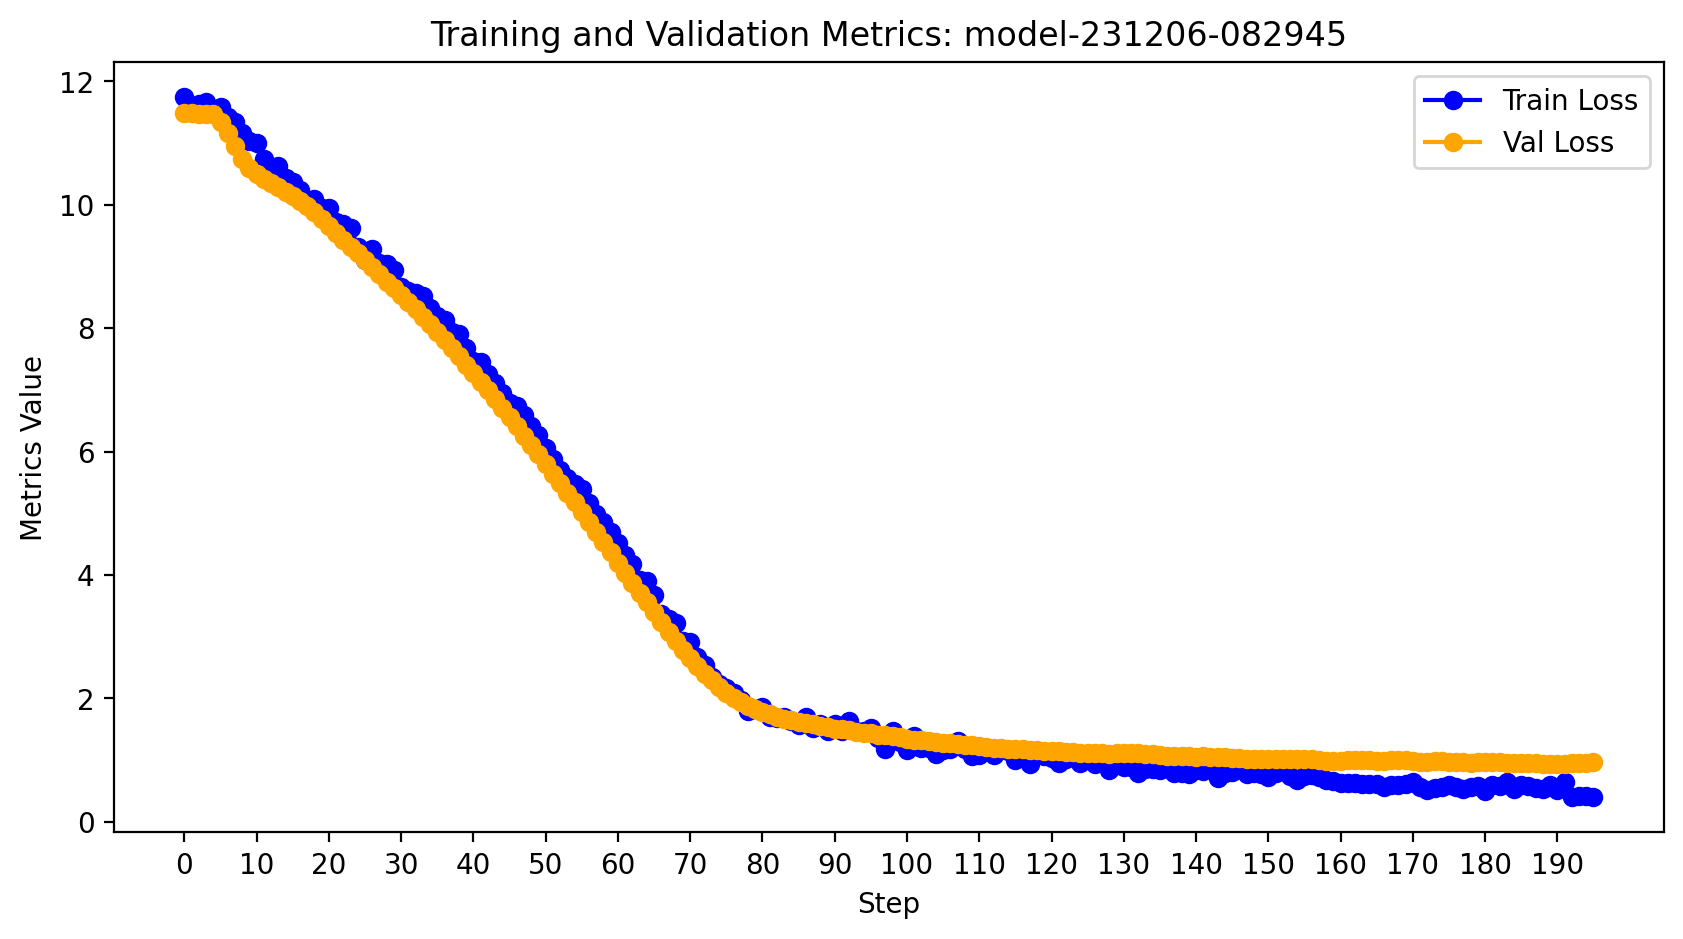

In [ ]:
# visualize loss curve
metrics = extract_metrics(model_trainer_en_tl_synth_25)
plot_metrics(metrics)

In [ ]:
# translations after training w/25% synthetic parallel corpus
synthetic_25_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                inputs=flores_splits['test_eng_inputs'],
                                src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [06:45<00:00,  1.01s/it]

Elasped Time: 6.763 mins


In [ ]:
# save translations from experiement with synthetic 25%
with open('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231206-082945/synthetic_25_tgl_predictions.txt', 'w') as file:
    for string in synthetic_25_translations:
        file.write(string[0] + '\n')

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231206-082945/synthetic_25_tgl_predictions.txt', 'r') as file:
    synthetic_25_translations = file.read().splitlines()

In [ ]:
cnt=0
for string in synthetic_25_translations:
    if len(string) == 0:
        cnt+=1
print(cnt)

0


In [ ]:
prep_translations = [[x] for x in synthetic_25_translations]

In [ ]:
# caluclate scores
bleu_bleurt(predicted_labels=synthetic_25_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


{'bleu_score': 0.2325955074882454, 'bleurt_score': 0.4111980912993796}

In [ ]:
# native-speaker eval
native_eval_0 = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                   inputs=native_speaker_eval_eng)
native_eval_0

100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Elasped Time: 0.041 mins


[['Ang isang bote ay tumaklong sa ilahok at bitigil.'],
 ['Matapos sa akin.'],
 ['Ang magsalita para sa kung ano ang naganayon, hindi ko naiwan ng Hae Ra ang ito.'],
 ['CAPULET iyan, kung ano, ngayon, taong kinakain! kung saan ganoon mo ito?'],
 ['Ang si Irene Adler?']]

## Training w/ 50% Synthetic Corpora

In [ ]:
# forward train with synthetic corpora 50%
model_trainer_en_tl_synth_50 = mBART50_training(model0, tokenizer0,
                                              synthetic_corpora['synth_splits_50'],
                                              foldername='mBART50-Synthetic_50',
                                              epochs=10, src_lang='en_XX', tgt_lang='tl_XX')


Step,Training Loss,Validation Loss
1,11.745600,11.481810
2,11.747600,11.481258
3,11.487100,11.480132
4,11.485300,11.478418
5,11.435300,11.476118
6,11.635200,11.368152
7,11.401800,11.212151
8,11.442500,11.024147
9,11.229500,10.831470
10,10.985600,10.666753


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 17.337 mins


In [ ]:
# directory where logging data was saved, saved model/tokenizer there too
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_50/231206-074822'

In [ ]:
# Save the trained model + tokenizer
model_trainer_en_tl_synth_50.save_model('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_50/231206-074822')

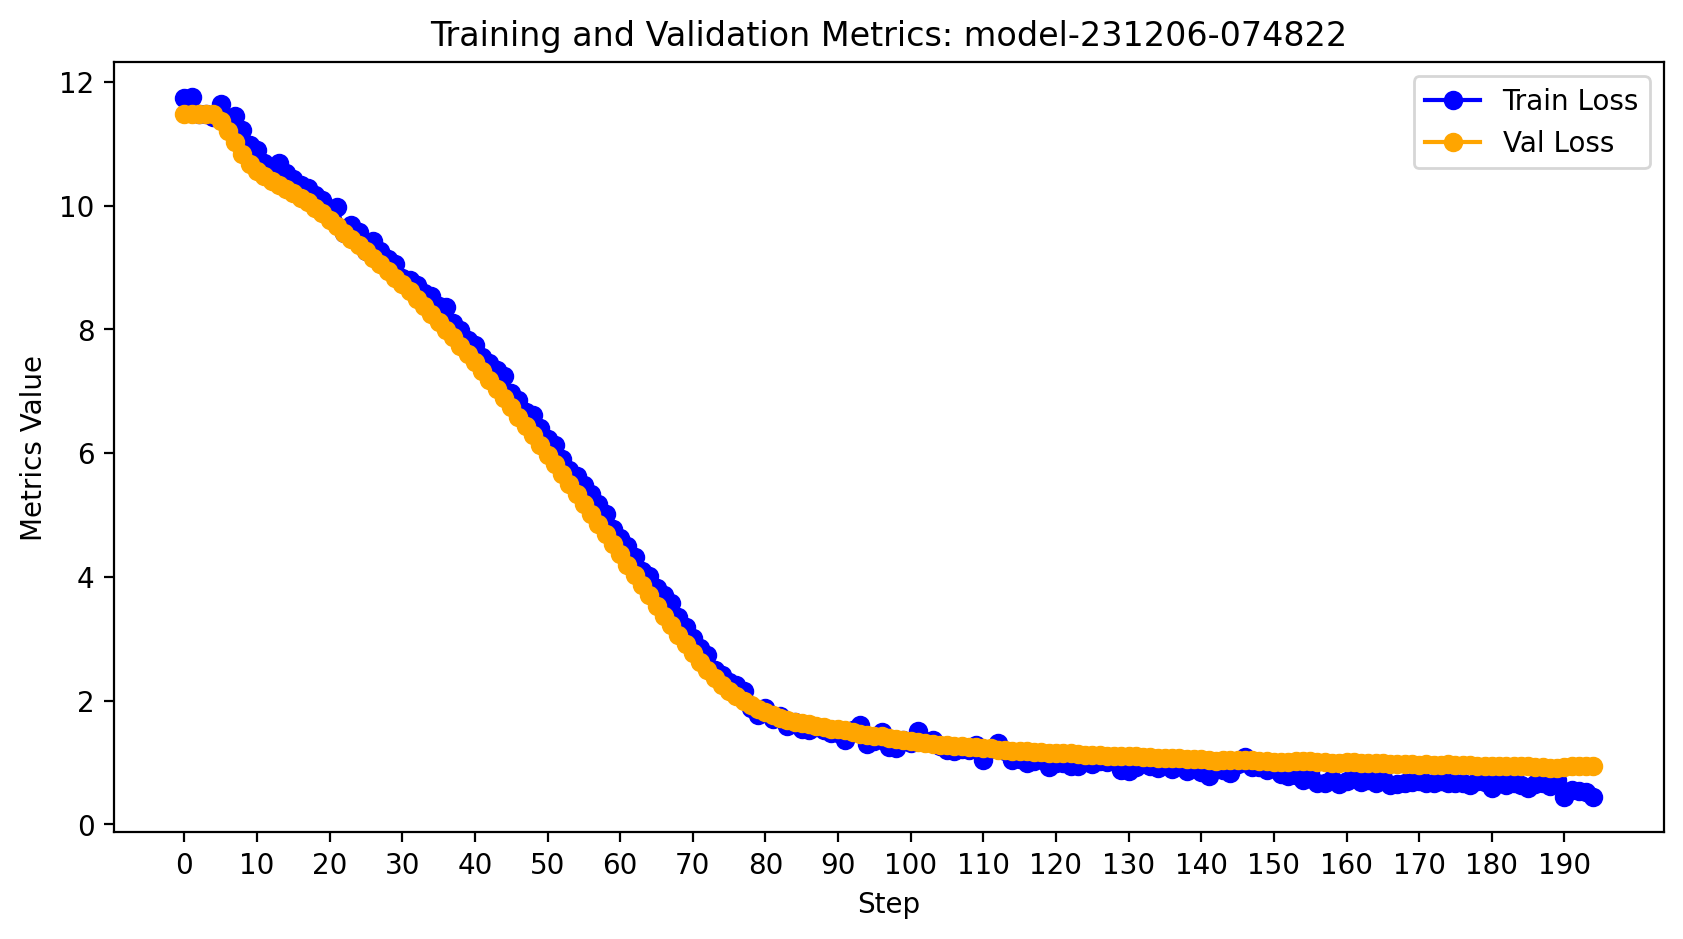

In [ ]:
# visualize loss curve
metrics = extract_metrics(model_trainer_en_tl_synth_50)
plot_metrics(metrics)

In [ ]:
# translations after training w/50% synthetic parallel corpus
synthetic_50_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                inputs=flores_splits['test_eng_inputs'],
                                src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [06:36<00:00,  1.01it/s]


Elasped Time: 6.619 mins


In [ ]:
# save translations from experiement with synthetic 50%
with open('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_50/231206-074822/synthetic_50_tgl_predictions.txt', 'w') as file:
    for string in synthetic_50_translations:
        file.write(string[0] + '\n')

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_50/231206-074822/synthetic_50_tgl_predictions.txt', 'r') as file:
    synthetic_50_translations = file.read().splitlines()

In [ ]:
prep_translations = [[x] for x in clean_translations]

In [ ]:
cnt=0
for string in synthetic_50_translations:
    if len(string[0]) == 0:
        cnt+=1
print(cnt)

4


In [ ]:
# caluclate scores
bleu_bleurt(predicted_labels=synthetic_50_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


{'bleu_score': 0.2197402981944059, 'bleurt_score': 0.39404528513921433}

In [ ]:
# native-speaker eval
native_eval_0 = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                   inputs=native_speaker_eval_eng)
native_eval_0

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Elasped Time: 0.093 mins


[['Ang isang bote ay nahulog sa ilaw at nahulog.'],
 ['Liking mata ko.'],
 ['Nagsalita ng mainam para sa kung ano ang nananatili, hindi ko ntingin naiwan ni Hae Ra na ito.'],
 ['CAPULET YAMAN, DYANG DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG DYANG, DYANG DYANG DYANG DYANG'],
 ['E ba ang Irene Adler?']]

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Training w/ 75% Synthetic Corpora

In [ ]:
# forward train with synthetic corpora 50%
model_trainer_en_tl_synth_75 = mBART50_training(model0, tokenizer0,
                                              synthetic_corpora['synth_splits_75'],
                                              foldername='mBART50-Synthetic_75',
                                              epochs=10, src_lang='en_XX', tgt_lang='tl_XX')


In [ ]:
# directory where logging data was saved, saved model/tokenizer there too
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_75/231206-070838'

In [ ]:
# Save the trained model + tokenizer
model_trainer_en_tl_synth_75.save_model('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_75/231206-070838')

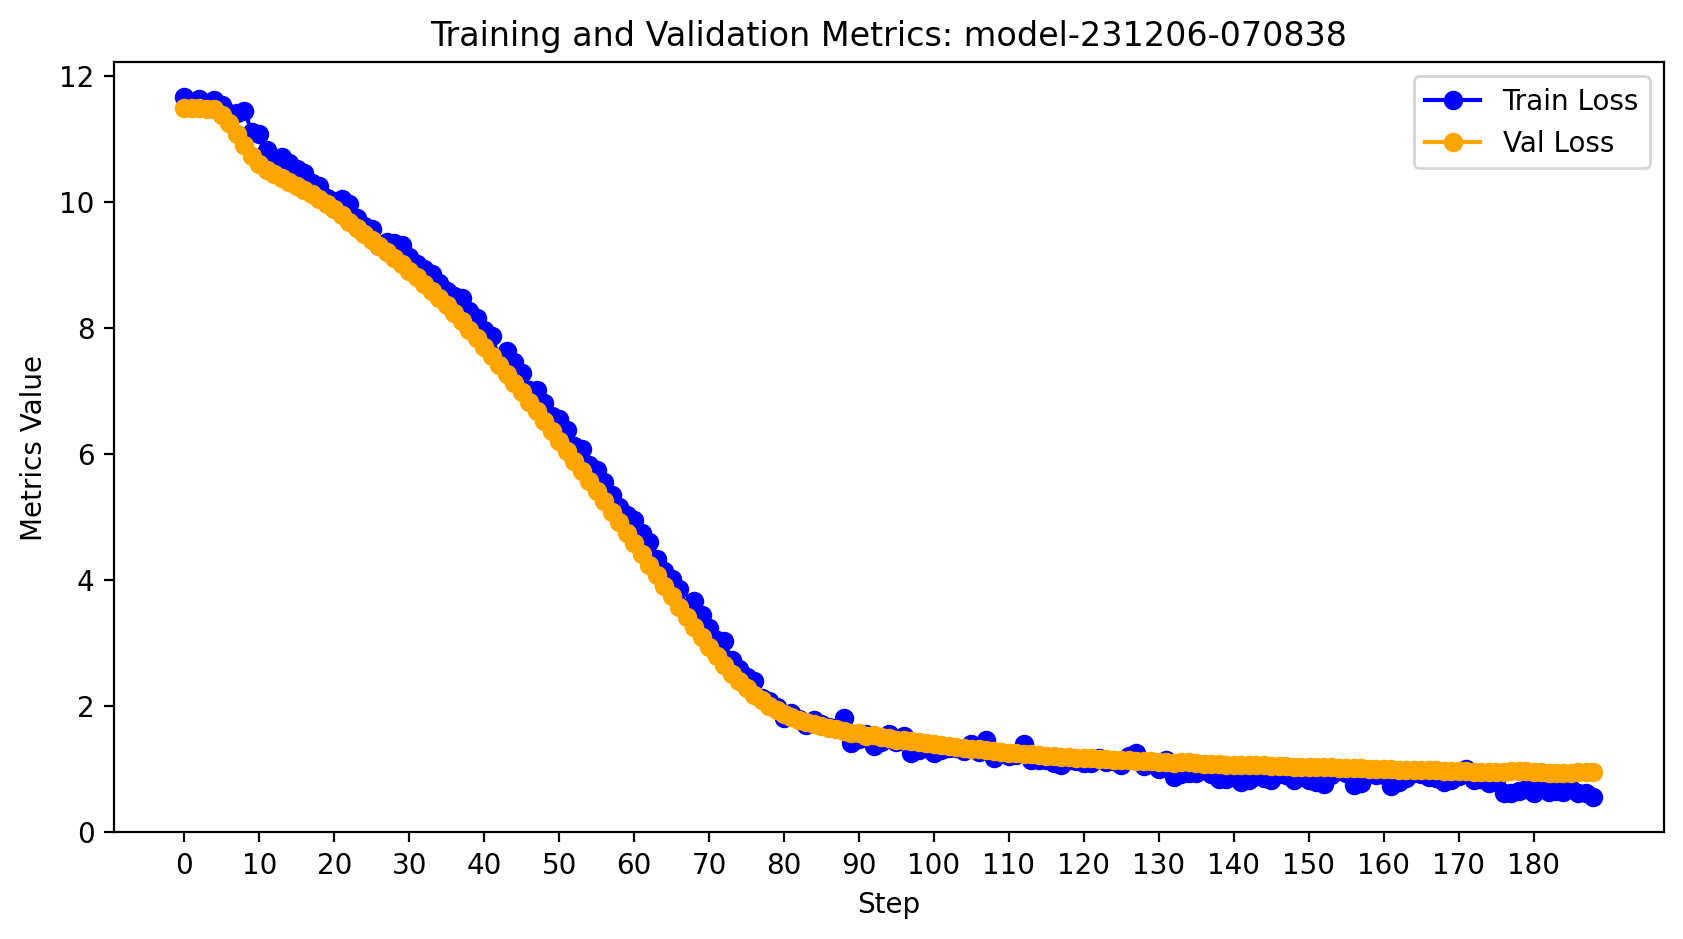

In [ ]:
# visualize loss curve
metrics = extract_metrics(model_trainer_en_tl_synth_75)
plot_metrics(metrics)

In [ ]:
# translations after training w/50% synthetic parallel corpus
synthetic_75_translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                inputs=flores_splits['test_eng_inputs'],
                                src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [07:03<00:00,  1.05s/it]


Elasped Time: 7.055 mins


In [ ]:
# save translations from experiement with synthetic 50%
with open('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_75/231206-070838/synthetic_75_tgl_predictions.txt', 'w') as file:
    for string in synthetic_75_translations:
        file.write(string[0] + '\n')

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_75/231206-070838/synthetic_75_tgl_predictions.txt', 'r') as file:
    synthetic_75_translations = file.read().splitlines()

In [ ]:
# native-speaker eval
native_eval_0 = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                   inputs=native_speaker_eval_eng)
native_eval_0

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Elasped Time: 0.047 mins


[['Isang bote ay bumagsak sa lupa at bumuo.'],
 ['Likha mo.'],
 ['Nag-ayon sa pag-ayon para sa kung ano ang naayos, hindi ko naniniwalang binigyan ni Hae Ra ang ito.'],
 ['CAPULET YON, DYANG DYANG DYANG DYANG DYANG DYANG DYANG DYANG DYANG DYANG DYANG DYANG?'],
 ['At ano ang Irene Adler?']]

In [ ]:
# caluclate scores
bleu_bleurt(predicted_labels=synthetic_75_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


{'bleu_score': 0.2103792220016669, 'bleurt_score': 0.3795466785555455}

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
quit()

## Reverse-trained then forward-train with Synthetic 25%

In [ ]:
!nvidia-smi

Thu Dec  7 07:10:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    43W / 350W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# load model and tokenizer
path_stock = "../home/MyDrive/Colab_Notebooks/mBART50-Stock"
path_flores = "../home/MyDrive/Colab_Notebooks/mBART50-Flores_Reverse/231204-030717"

model1 = MBartForConditionalGeneration.from_pretrained(path_flores).to(device)
tokenizer0 = MBart50TokenizerFast.from_pretrained(path_stock)

In [ ]:
# custom model configeration for inference
model1.generation_config.group_beam_search = 5
model1.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "group_beam_search": 5,
  "max_length": 200,
  "num_beams": 5,
  "pad_token_id": 1
}

In [ ]:
# forward train with synthetic corpora 25%
model_trainer_en_tl_synth_25 = mBART50_training(model1, tokenizer0,
                                              synthetic_corpora['synth_splits_25'],
                                              foldername='mBART50-Synthetic_25',
                                              epochs=10, src_lang='en_XX', tgt_lang='tl_XX')


Step,Training Loss,Validation Loss
1,5.403100,5.691556
2,5.472400,5.690438
3,5.393900,5.688190
4,4.701800,5.684788
5,5.867000,5.680221
6,5.097200,5.506509
7,5.387700,5.247313
8,5.409000,4.906902
9,4.793200,4.507663
10,4.218900,4.098204


Total Training Time: 16.076 mins


In [ ]:
# directory where logging data was saved, saved model/tokenizer there too
log_dir

'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231207-071218'

In [ ]:
# Save the trained model + tokenizer
model_trainer_en_tl_synth_25.save_model('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231207-071218')

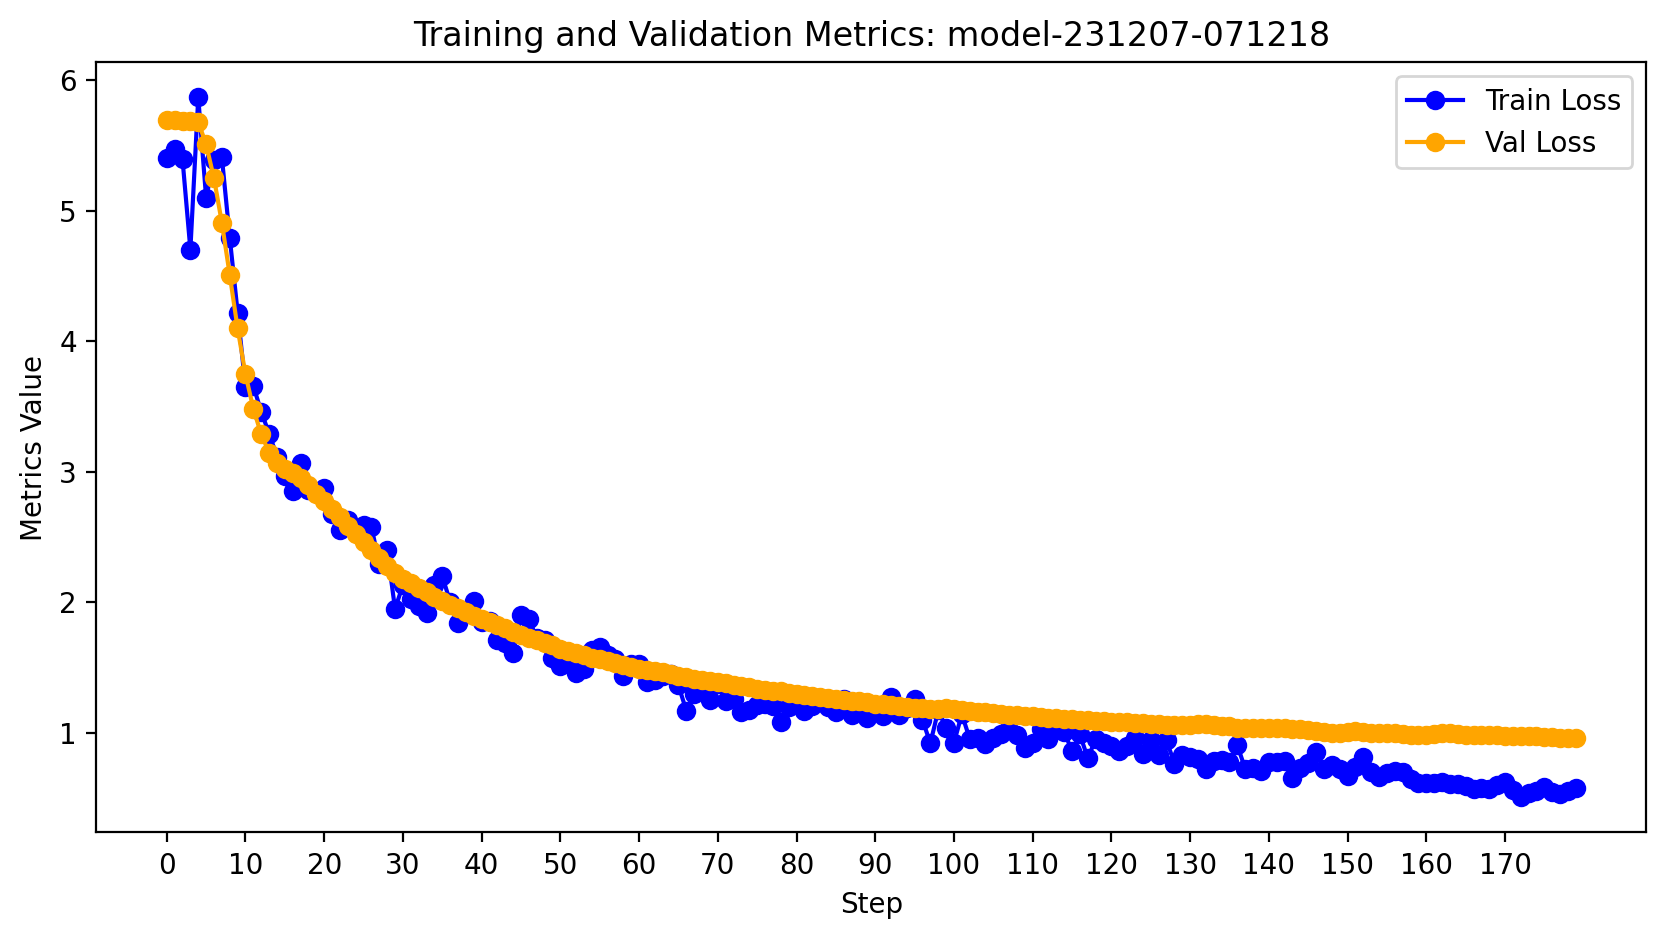

In [ ]:
# visualize loss curve
metrics = extract_metrics(model_trainer_en_tl_synth_25)
plot_metrics(metrics)

In [ ]:
# translations after training w/25% synthetic:real parallel corpus
synthetic_25_translations = mBART50_translator(model_=model1, tokenizer_=tokenizer0,
                                inputs=flores_splits['test_eng_inputs'], src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [06:15<00:00,  1.07it/s]


Elasped Time: 6.262 mins


In [ ]:
# save translations from experiement with synthetic 25%
with open('../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231207-071218/synthetic_25_tgl_predictions.txt', 'w') as file:
    for string in synthetic_25_translations:
        file.write(string[0] + '\n')

In [ ]:
with open(f'../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_25/231207-071218/synthetic_25_tgl_predictions.txt', 'r') as file:
    synthetic_25_translations = file.read().splitlines()

In [ ]:
prep_translations = [[x] for x in synthetic_25_translations]

In [ ]:
# native-speaker eval
mBART50_translator(model_=model1, tokenizer_=tokenizer0,inputs=native_speaker_eval_eng)

100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Elasped Time: 0.091 mins


[['Ang isang botella ay nahulog sa lupa at nahulog.'],
 ['Lihim sa akin.'],
 ['Nagsasalita ng kasoran para sa kung ano ang paglalakad, Hindi na si Hae Ra ay mong ito.'],
 ['CAPULET '],
 ['Ewan pa si Irene Adler?']]

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# caluclate scores
bleu_bleurt(predicted_labels=synthetic_25_translations, true_labels=flores_splits['test_eng_inputs'])

100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


{'bleu_score': 0.06059396903345605, 'bleurt_score': 0.2927833668776412}

## Training with 200% Synthetic Corpora

In [ ]:
# train model, return model trainer
model_trainer = mBART50_training(model0, tokenizer0, synthetic_corpora['synth_splits_200'],
                                 foldername='mBART50-Synthetic_200', epochs=10,
                                 batch_size=48, src_lang='en_XX', tgt_lang='tl_XX')

Step,Training Loss,Validation Loss
1,11.597000,11.481810
2,11.712800,11.481543
3,11.625100,11.481003
4,11.498800,11.480184
5,11.640700,11.479074
6,11.533800,11.425692
7,11.596000,11.345192
8,11.620800,11.238730
9,11.358200,11.110852
10,11.335700,10.970409


Total Training Time: 16.06 mins


Training directory:
	../home/MyDrive/Colab_Notebooks/mBART50-Synthetic_200/231207-045631



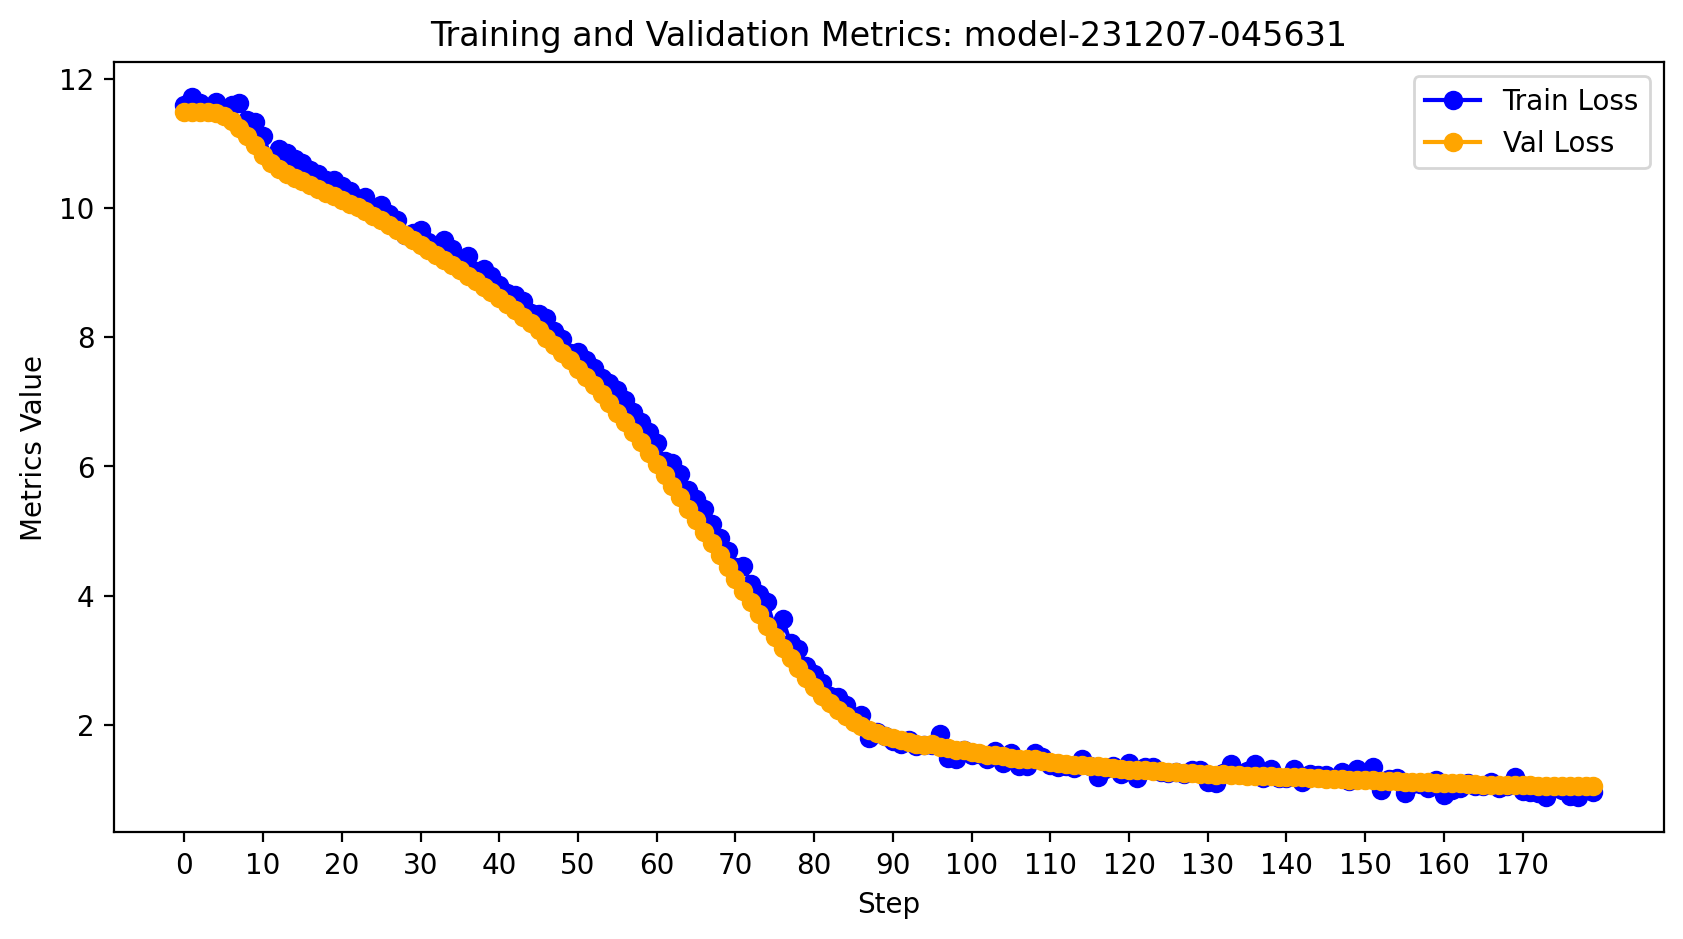

In [ ]:
# training directory
print(f'Training directory:\n\t{log_dir}\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                                  inputs=flores_splits['test_eng_inputs'],
                                  src_lang='en_XX', tgt_lang='tl_XX')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
mBART50_translator(model_=model0, tokenizer_=tokenizer0,
                    inputs=native_speaker_eval_eng,
                    src_lang='en_XX', tgt_lang='tl_XX')

100%|██████████| 402/402 [06:35<00:00,  1.02it/s]


Elasped Time: 6.598 mins


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Elasped Time: 0.042 mins


[['Ang isang botella ay nagtatagpuan sa lupa at nagtatagpuan.'],
 ['Bumutukoy mo.'],
 ['Ang pag-aayos para sa pag-aayos, hindi mo nating ni Hae Ra ang maut na ito.'],
 ['CAPULET Naniniwala, kung ano ang katanungan mo, katanungan mo! kung ano ang buhangin mo na ito?'],
 ['And what about Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


{'bleu_score': 0.18956461021476032, 'bleurt_score': 0.3172473664307476}

In [ ]:
quit()

# Experimental Results

## Import gsheet Function

In [ ]:
def import_gsheet(file=None, sheet=None):
    '''
    import a .gsheet file into a dataframe

    Parameters
    ----------
    file:  name of .gsheet file
    sheet: name of sheet in .gsheet file

    Returns
    -------
    dataframe
    '''
    # Assertions
    assert isinstance(file, str), 'Pass gsheet filename as string'
    assert '.' not in file, 'Pass .gsheet filename only'

    # Authenticate with Google Sheets API
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the Google Sheet
    sh = gc.open(file)
    worksheet = sh.sheet1 if sheet is None else sh.worksheet(sheet)

    # Get all values in the sheet
    values = worksheet.get_all_values()

    # Convert the values to a DataFrame
    df = pd.DataFrame(values)
    df = df.rename(columns=df.iloc[0]).drop(0).reset_index(drop=True)

    print(f'{len(df)} rows imported')

    return df


## Plotting

In [ ]:
df = import_gsheet(file='experiment_results')


14 rows imported


In [ ]:
df

,Model,Experiment,BLEU,BLEURT
0,mBART50,Baseline,4.20,18.39
1,mBART50,Fine-tune (1:0),16.38,25.18
2,mBART50,Fine-tune (4:1),25.01,38.81
3,mBART50,Fine-tune (2:1),23.58,37.44
4,mBART50,Fine-tune (4:3),22.61,35.50
5,mBART50,Fine-tune (1:1),23.18,37.95
6,mBART50,Fine-tune (1:2),18.96,31.72
7,M2M100,Baseline,18.28,36.89
8,M2M100,Fine-tune (1:0),25.67,40.75
9,M2M100,Fine-tune (4:1),27.37,43.41


In [ ]:
# re-level columns
experiments = ["Baseline",
                "Fine-tune (1:0)",
                "Fine-tune (4:1)",
                "Fine-tune (2:1)",
                "Fine-tune (4:3)",
                "Fine-tune (1:1)",
                "Fine-tune (1:2)"]
models = ["mBART50",
          "M2M100"]

df['Experiment'] = pd.Categorical(df['Experiment'], categories=experiments, ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=models, ordered=True)
df = df.sort_values('Model')
df = df.sort_values('Experiment')

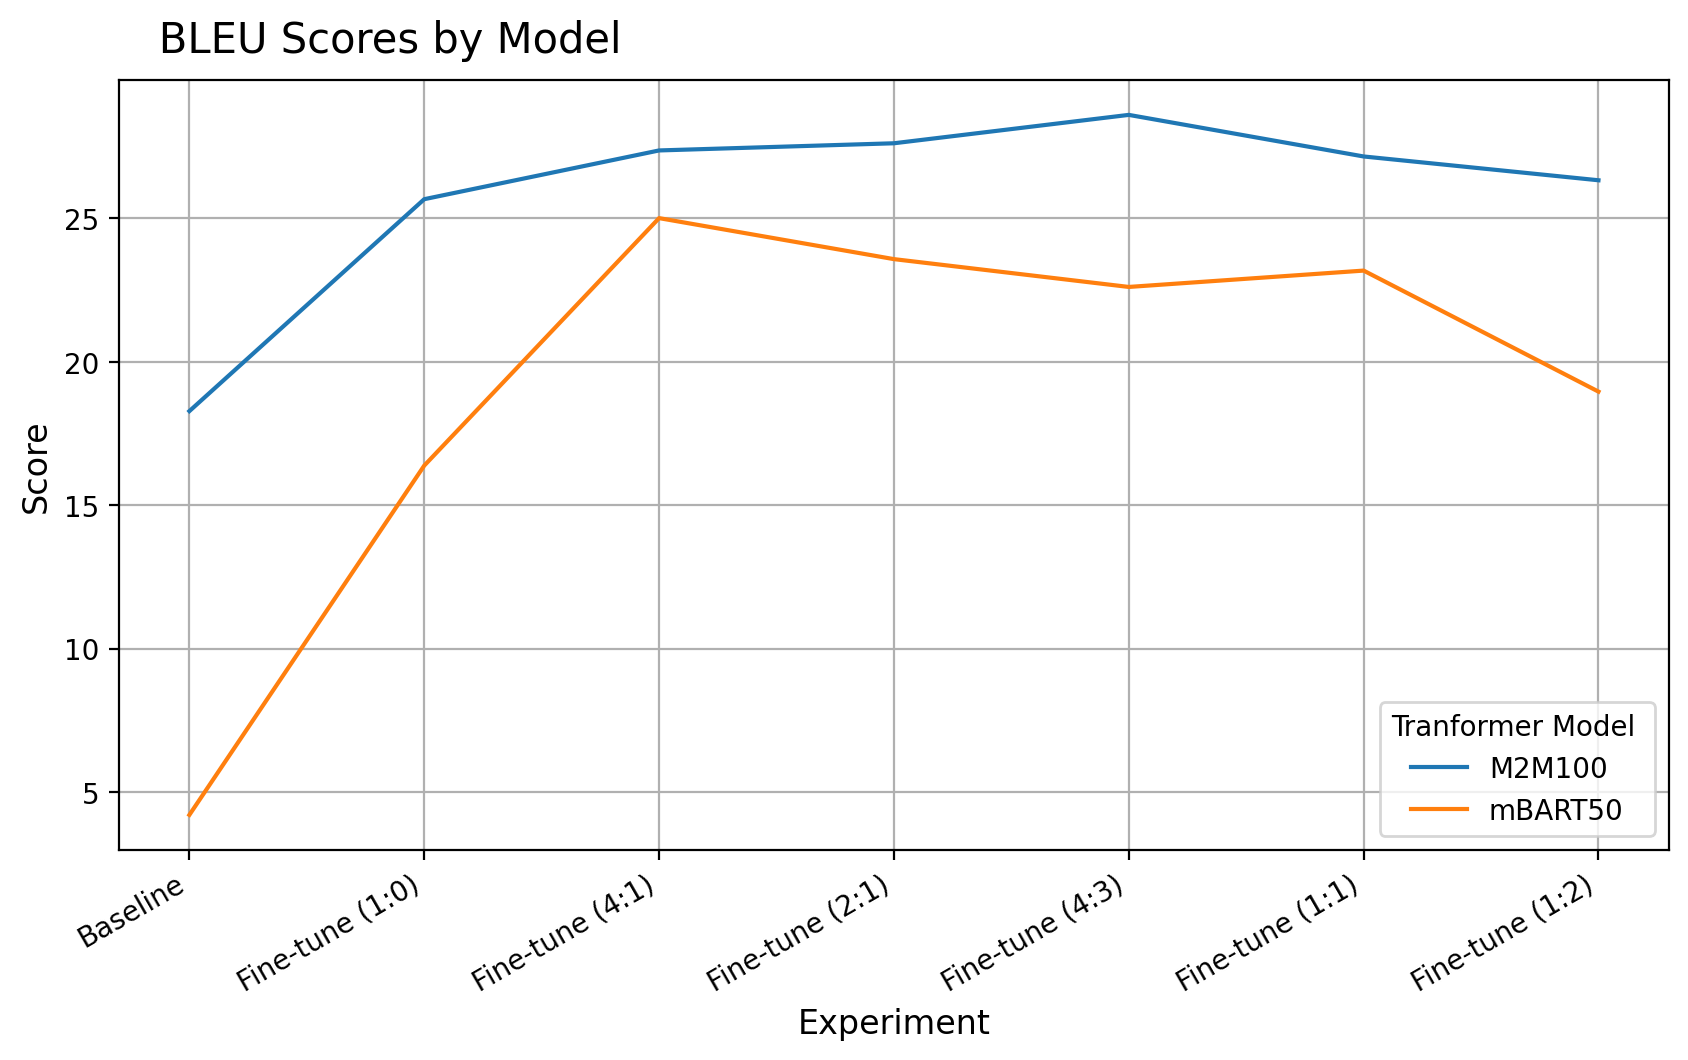

<Figure size 640x480 with 0 Axes>

In [ ]:
# BLEU scores by experiment
df.pivot_table(values='BLEU', index='Experiment', columns='Model').plot(figsize=(10,5))

plt.xticks(ha='right', rotation=30)
plt.xlabel("Experiment", size=12)
plt.ylabel("Score", size=12)
plt.title("   BLEU Scores by Model",
          pad=10, loc='left', size=15)
plt.legend(title="Tranformer Model ", loc='lower right')
plt.grid()
plt.show()

# plt.savefig(os.path.join("/home/MyDrive/Colab_Notebooks", 'bleu_score_by_experiment'),
#             format='png', dpi=300)

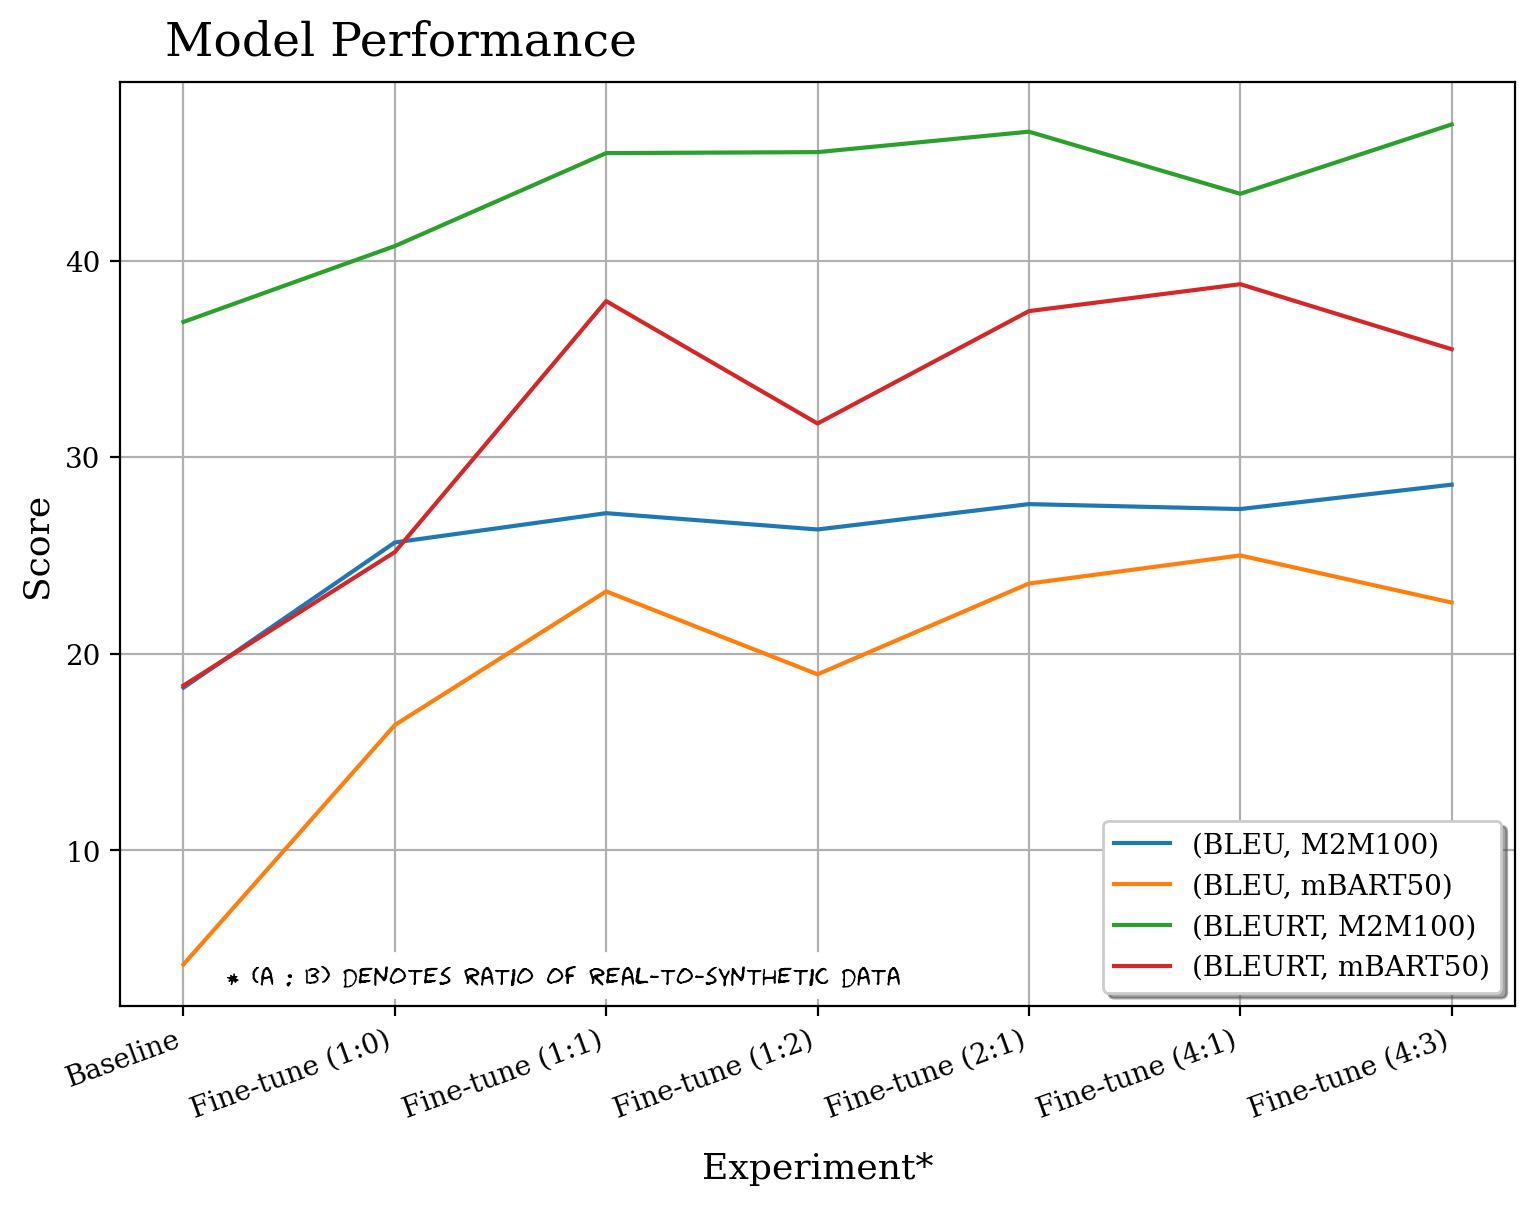

In [ ]:
# Model performance
df.pivot_table(values=['BLEU','BLEURT'], index='Experiment', columns='Model').plot(figsize=(9,6))

plt.xticks(ha='right', rotation=20, fontfamily='serif')
plt.xlabel("Experiment*", size=13, labelpad=10, fontfamily='serif')
plt.yticks(fontfamily='serif')
plt.ylabel("Score", size=13, fontfamily='serif')
plt.title("   Model Performance", pad=10, loc='left', size=17, fontfamily='serif')
plt.legend(title="", loc='lower right', fancybox=True, shadow=True, fontsize=10,
           prop=dict(family='serif'))#, style='italic', weight='bold'))
caption_text = "* (a : b) denotes ratio of real-to-synthetic data"
plt.text(0.2, 3.65, caption_text, ha='left', va='center', fontsize=9, color='black',
         alpha=1, backgroundcolor='white', fontfamily='fantasy', animated=True)
plt.grid()
# plt.savefig(os.path.join("/home/MyDrive/Colab_Notebooks", 'model_performance.png'),
#             dpi=300)
plt.show()


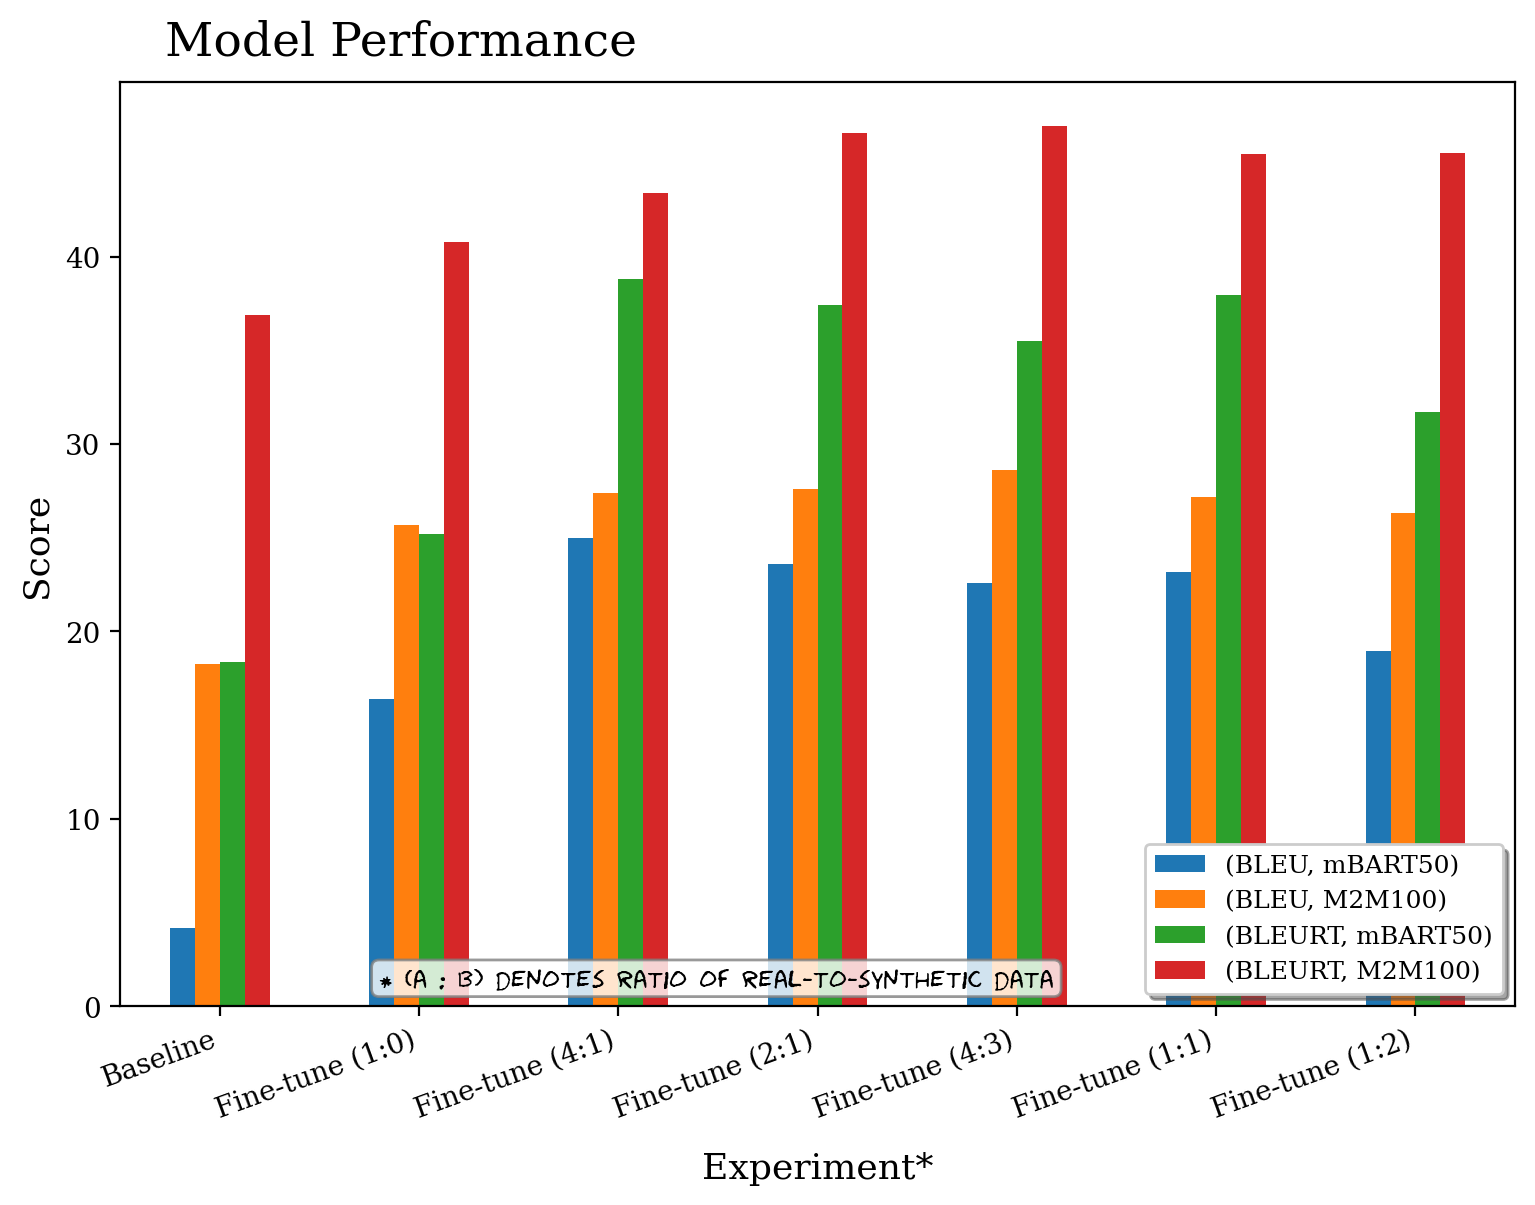

In [ ]:
# Model performance
df.pivot_table(values=['BLEU','BLEURT'], index='Experiment', columns='Model').plot(kind='bar', figsize=(9,6))

plt.xticks(ha='right', rotation=20, fontfamily='serif')
plt.xlabel("Experiment*", size=13, labelpad=10, fontfamily='serif')
plt.yticks(fontfamily='serif')
plt.ylabel("Score", size=13, fontfamily='serif')
plt.title("   Model Performance", pad=10, loc='left', size=17, fontfamily='serif')
plt.legend(title="", loc='lower right', fancybox=True, shadow=True, fontsize=10,
           prop=dict(family='serif', size=9))#, style='italic', weight='bold'))
caption_text = "* (a : b) denotes ratio of real-to-synthetic data"
plt.text(0.8, 1.5, caption_text, ha='left', va='center', fontsize=9, color='black',
         alpha=1, backgroundcolor='white', fontfamily='fantasy', animated=True,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey', boxstyle='round'))
# plt.grid()
# plt.savefig(os.path.join("/home/MyDrive/Colab_Notebooks", 'model_performance_bar.png'),
#             dpi=300)
plt.show()


# End of Notebook

In [ ]:
# close runtime; save dem credits ^_^'
runtime.unassign()